In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2020/ANESTESIOLOGIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 9 questions
Page 1, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=172.3, y1=110.4
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 474
Page 1, Q1, A: Yellow percentage: 0.0%


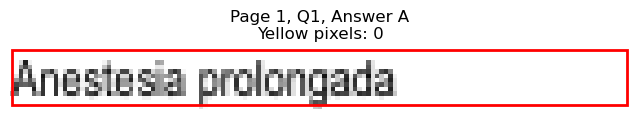

Page 1, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=126.6, y1=123.0
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 221
Page 1, Q1, B: Yellow percentage: 0.0%


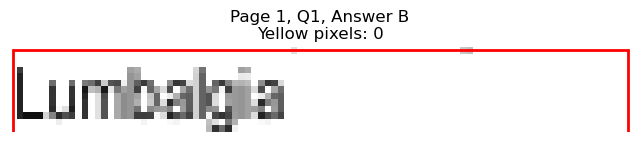

Page 1, Q1 - C: Detected box: x0=82.9, y0=122.9, x1=183.7, y1=135.6
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 476
Page 1, Q1, C: Yellow percentage: 0.0%


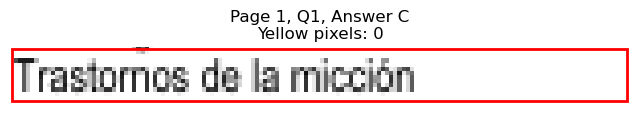

Page 1, Q1 - D: Detected box: x0=334.6, y0=97.7, x1=451.5, y1=110.4
Page 1, Q1, D: Yellow pixels: 1562
Page 1, Q1, D: Total non-white pixels: 2352
Page 1, Q1, D: Yellow percentage: 66.4%


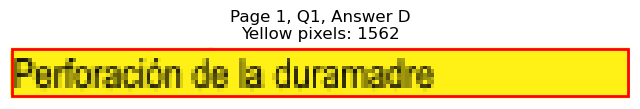

Page 1, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=384.3, y1=123.0
Page 1, Q1, E: Yellow pixels: 0
Page 1, Q1, E: Total non-white pixels: 354
Page 1, Q1, E: Yellow percentage: 0.0%


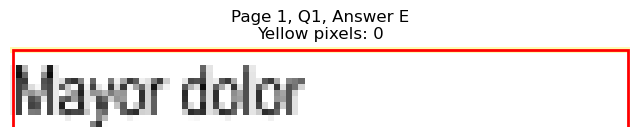


Page 1, Q1 - Selected Answer: D (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=82.5, y0=160.8, x1=191.3, y1=173.5
Page 1, Q2, A: Yellow pixels: 160
Page 1, Q2, A: Total non-white pixels: 707
Page 1, Q2, A: Yellow percentage: 22.6%


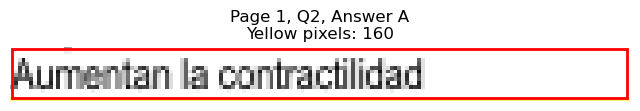

Page 1, Q2 - B: Detected box: x0=229.7, y0=173.4, x1=275.1, y1=186.1
Page 1, Q2, B: Yellow pixels: 445
Page 1, Q2, B: Total non-white pixels: 665
Page 1, Q2, B: Yellow percentage: 66.9%


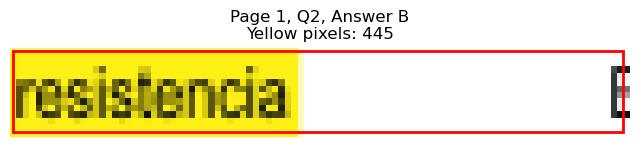

Page 1, Q2 - C: Detected box: x0=82.9, y0=198.6, x1=97.0, y1=211.3
Page 1, Q2, C: Yellow pixels: 65
Page 1, Q2, C: Total non-white pixels: 332
Page 1, Q2, C: Yellow percentage: 19.6%


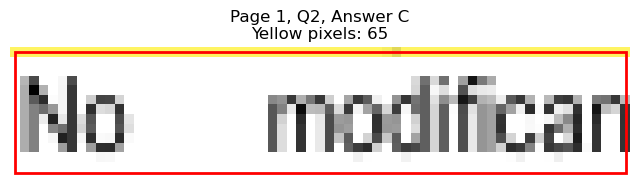

Page 1, Q2 - D: Detected box: x0=334.6, y0=160.8, x1=484.7, y1=173.5
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 745
Page 1, Q2, D: Yellow percentage: 0.0%


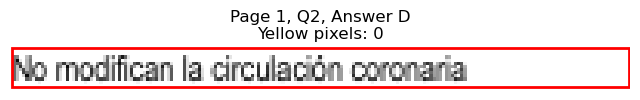

Page 1, Q2 - E: Detected box: x0=334.1, y0=173.4, x1=493.7, y1=186.1
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 769
Page 1, Q2, E: Yellow percentage: 0.0%


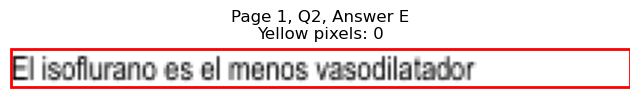


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=82.5, y0=249.1, x1=118.6, y1=261.8
Page 1, Q3, A: Yellow pixels: 1000
Page 1, Q3, A: Total non-white pixels: 1131
Page 1, Q3, A: Yellow percentage: 88.4%


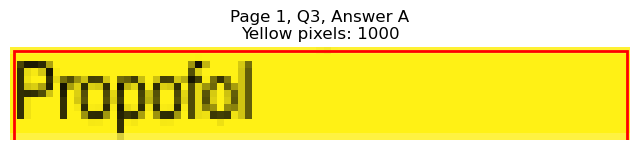

Page 1, Q3 - B: Detected box: x0=82.5, y0=261.7, x1=138.1, y1=274.4
Page 1, Q3, B: Yellow pixels: 107
Page 1, Q3, B: Total non-white pixels: 372
Page 1, Q3, B: Yellow percentage: 28.8%


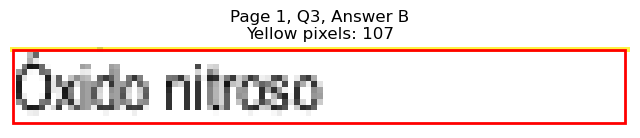

Page 1, Q3 - C: Detected box: x0=82.9, y0=274.5, x1=121.7, y1=287.1
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 195
Page 1, Q3, C: Yellow percentage: 0.0%


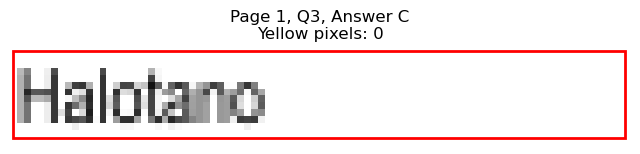

Page 1, Q3 - D: Detected box: x0=334.6, y0=249.1, x1=375.8, y1=261.8
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 200
Page 1, Q3, D: Yellow percentage: 0.0%


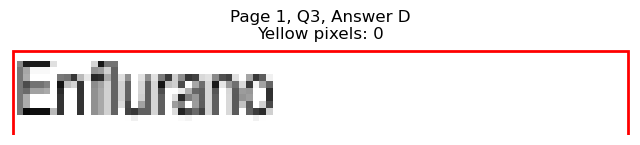

Page 1, Q3 - E: Detected box: x0=334.1, y0=261.7, x1=374.8, y1=274.4
Page 1, Q3, E: Yellow pixels: 0
Page 1, Q3, E: Total non-white pixels: 209
Page 1, Q3, E: Yellow percentage: 0.0%


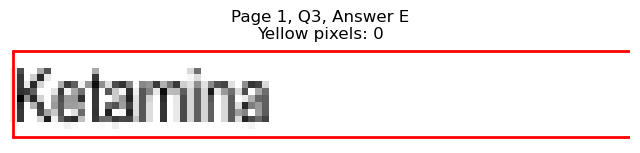


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=82.5, y0=324.9, x1=165.3, y1=337.5
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 398
Page 1, Q4, A: Yellow percentage: 0.0%


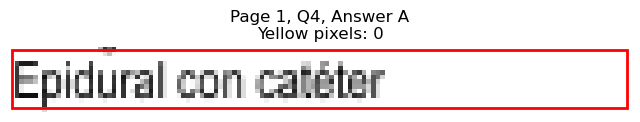

Page 1, Q4 - B: Detected box: x0=82.5, y0=337.5, x1=162.3, y1=350.1
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 376
Page 1, Q4, B: Yellow percentage: 0.0%


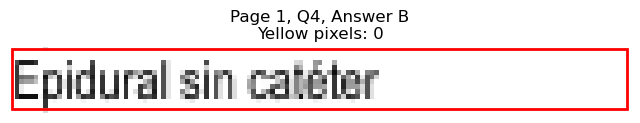

Page 1, Q4 - C: Detected box: x0=82.9, y0=350.2, x1=115.1, y1=362.9
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 145
Page 1, Q4, C: Yellow percentage: 0.0%


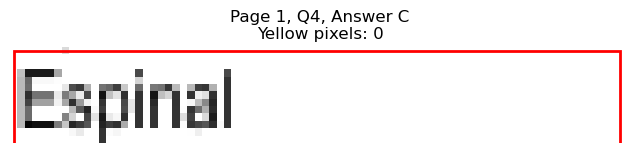

Page 1, Q4 - D: Detected box: x0=334.6, y0=324.9, x1=509.1, y1=337.5
Page 1, Q4, D: Yellow pixels: 192
Page 1, Q4, D: Total non-white pixels: 1042
Page 1, Q4, D: Yellow percentage: 18.4%


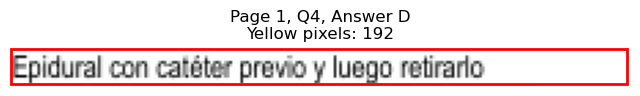

Page 1, Q4 - E: Detected box: x0=334.1, y0=337.5, x1=368.7, y1=350.1
Page 1, Q4, E: Yellow pixels: 962
Page 1, Q4, E: Total non-white pixels: 1190
Page 1, Q4, E: Yellow percentage: 80.8%


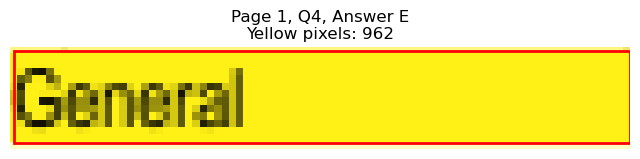


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=70.8, y0=400.6, x1=79.3, y1=413.3
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 68
Page 1, Q5, A: Yellow percentage: 0.0%


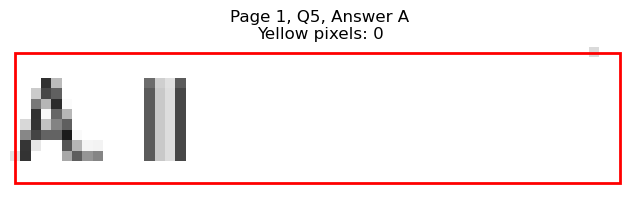

Page 1, Q5 - B: Detected box: x0=82.5, y0=413.3, x1=92.5, y1=426.0
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 109
Page 1, Q5, B: Yellow percentage: 0.0%


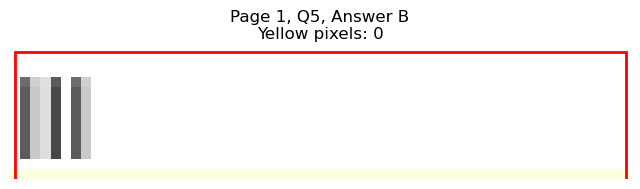

Page 1, Q5 - C: Detected box: x0=82.9, y0=425.9, x1=94.0, y1=438.6
Page 1, Q5, C: Yellow pixels: 777
Page 1, Q5, C: Total non-white pixels: 868
Page 1, Q5, C: Yellow percentage: 89.5%


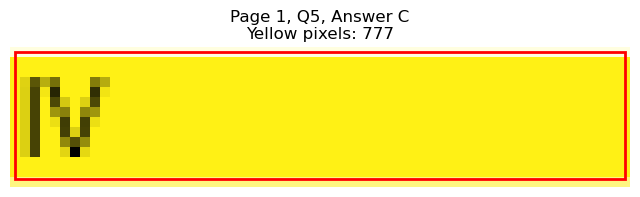

Page 1, Q5 - D: Detected box: x0=322.5, y0=400.6, x1=331.5, y1=413.3
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 59
Page 1, Q5, D: Yellow percentage: 0.0%


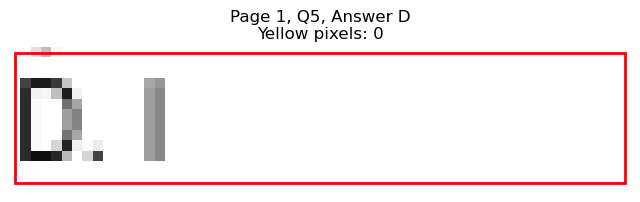

Page 1, Q5 - E: Detected box: x0=334.1, y0=413.3, x1=343.7, y1=426.0
Page 1, Q5, E: Yellow pixels: 0
Page 1, Q5, E: Total non-white pixels: 38
Page 1, Q5, E: Yellow percentage: 0.0%


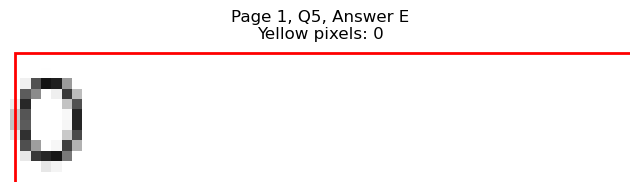


Page 1, Q5 - Selected Answer: C (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=82.5, y0=476.3, x1=126.1, y1=489.0
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 214
Page 1, Q6, A: Yellow percentage: 0.0%


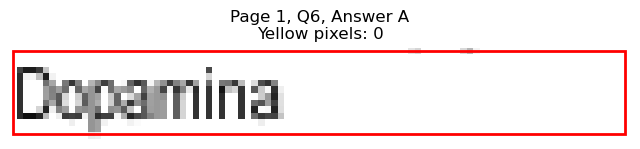

Page 1, Q6 - B: Detected box: x0=82.5, y0=489.1, x1=127.1, y1=501.7
Page 1, Q6, B: Yellow pixels: 1063
Page 1, Q6, B: Total non-white pixels: 1248
Page 1, Q6, B: Yellow percentage: 85.2%


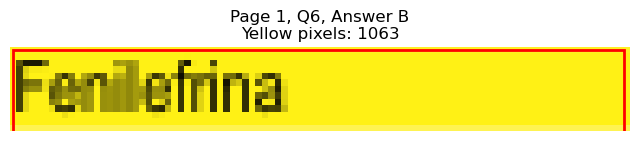

Page 1, Q6 - C: Detected box: x0=82.9, y0=501.7, x1=128.5, y1=514.3
Page 1, Q6, C: Yellow pixels: 97
Page 1, Q6, C: Total non-white pixels: 340
Page 1, Q6, C: Yellow percentage: 28.5%


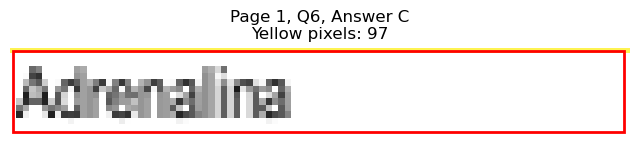

Page 1, Q6 - D: Detected box: x0=334.6, y0=476.3, x1=393.8, y1=489.0
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 315
Page 1, Q6, D: Yellow percentage: 0.0%


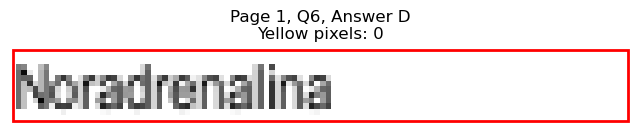

Page 1, Q6 - E: Detected box: x0=334.1, y0=489.1, x1=385.3, y1=501.7
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 272
Page 1, Q6, E: Yellow percentage: 0.0%


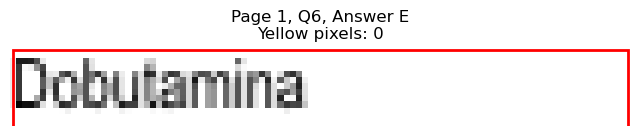


Page 1, Q6 - Selected Answer: B (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=82.5, y0=249.1, x1=118.6, y1=261.8
Page 1, Q7, A: Yellow pixels: 1000
Page 1, Q7, A: Total non-white pixels: 1131
Page 1, Q7, A: Yellow percentage: 88.4%


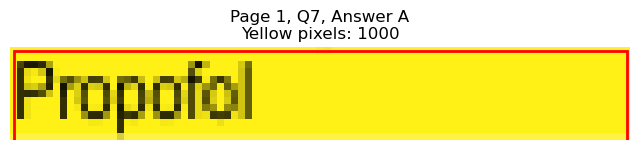

Page 1, Q7 - B: Detected box: x0=82.5, y0=552.2, x1=121.1, y1=564.8
Page 1, Q7, B: Yellow pixels: 1028
Page 1, Q7, B: Total non-white pixels: 1170
Page 1, Q7, B: Yellow percentage: 87.9%


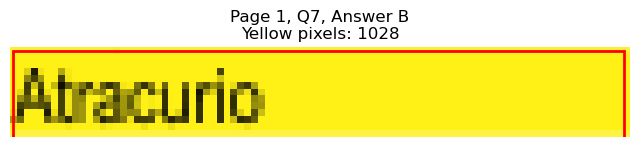

Page 1, Q7 - C: Detected box: x0=82.9, y0=564.8, x1=122.5, y1=577.4
Page 1, Q7, C: Yellow pixels: 91
Page 1, Q7, C: Total non-white pixels: 283
Page 1, Q7, C: Yellow percentage: 32.2%


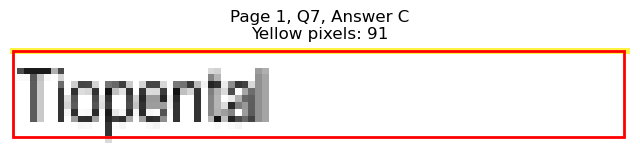

Page 1, Q7 - D: Detected box: x0=334.6, y0=539.5, x1=391.9, y1=552.1
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 302
Page 1, Q7, D: Yellow percentage: 0.0%


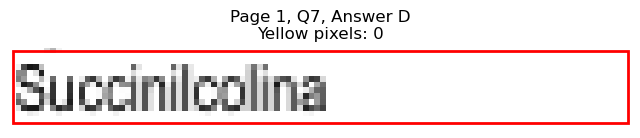

Page 1, Q7 - E: Detected box: x0=334.1, y0=552.2, x1=382.3, y1=564.8
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 239
Page 1, Q7, E: Yellow percentage: 0.0%


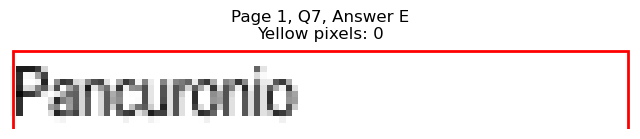


Page 1, Q7 - Selected Answer: B (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=82.5, y0=615.2, x1=275.2, y1=627.8
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 1002
Page 1, Q8, A: Yellow percentage: 0.0%


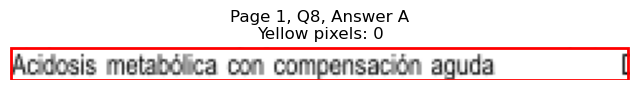

Page 1, Q8 - B: Detected box: x0=82.5, y0=640.5, x1=190.5, y1=653.2
Page 1, Q8, B: Yellow pixels: 159
Page 1, Q8, B: Total non-white pixels: 682
Page 1, Q8, B: Yellow percentage: 23.3%


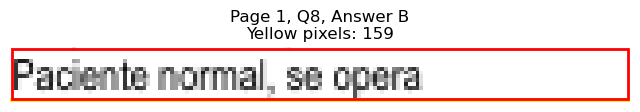

Page 1, Q8 - C: Detected box: x0=82.9, y0=653.1, x1=275.3, y1=665.8
Page 1, Q8, C: Yellow pixels: 1737
Page 1, Q8, C: Total non-white pixels: 2509
Page 1, Q8, C: Yellow percentage: 69.2%


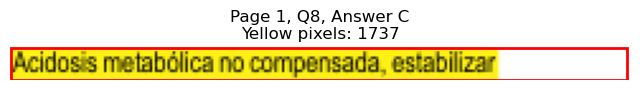

Page 1, Q8 - D: Detected box: x0=334.6, y0=615.2, x1=506.3, y1=627.8
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 874
Page 1, Q8, D: Yellow percentage: 0.0%


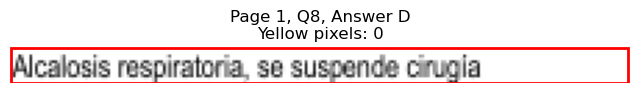

Page 1, Q8 - E: Detected box: x0=334.1, y0=627.9, x1=477.1, y1=640.6
Page 1, Q8, E: Yellow pixels: 0
Page 1, Q8, E: Total non-white pixels: 702
Page 1, Q8, E: Yellow percentage: 0.0%


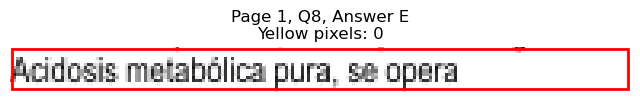


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=82.5, y0=703.7, x1=139.6, y1=716.3
Page 1, Q9, A: Yellow pixels: 1079
Page 1, Q9, A: Total non-white pixels: 1512
Page 1, Q9, A: Yellow percentage: 71.4%


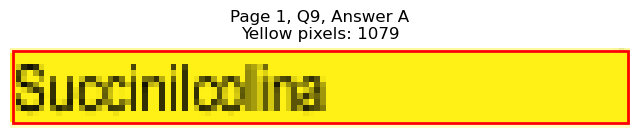

Page 1, Q9 - B: Detected box: x0=82.5, y0=716.3, x1=119.1, y1=728.9
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 248
Page 1, Q9, B: Yellow percentage: 0.0%


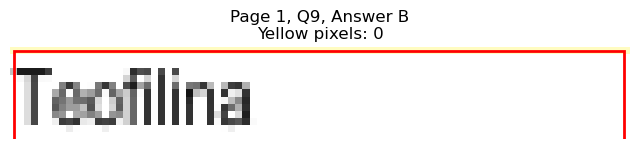

Page 1, Q9 - C: Detected box: x0=82.9, y0=728.9, x1=152.7, y1=741.5
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 366
Page 1, Q9, C: Yellow percentage: 0.0%


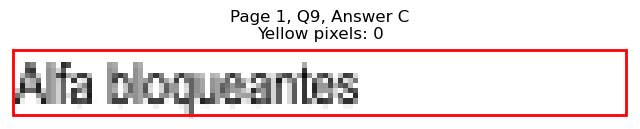

Page 1, Q9 - D: Detected box: x0=334.6, y0=703.7, x1=394.3, y1=716.3
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 304
Page 1, Q9, D: Yellow percentage: 0.0%


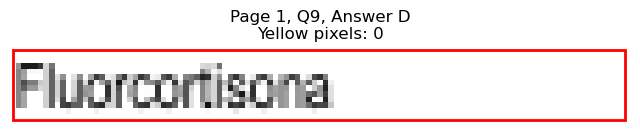

Page 1, Q9 - E: Detected box: x0=334.1, y0=716.3, x1=376.3, y1=728.9
Page 1, Q9, E: Yellow pixels: 0
Page 1, Q9, E: Total non-white pixels: 204
Page 1, Q9, E: Yellow percentage: 0.0%


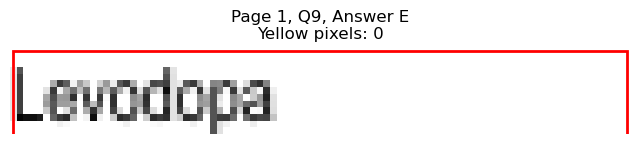


Page 1, Q9 - Selected Answer: A (based on yellow pixel count)





Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=123.6, y1=110.4
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 224
Page 2, Q1, A: Yellow percentage: 0.0%


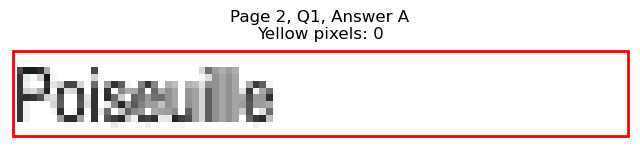

Page 2, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=120.1, y1=123.0
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 165
Page 2, Q1, B: Yellow percentage: 0.0%


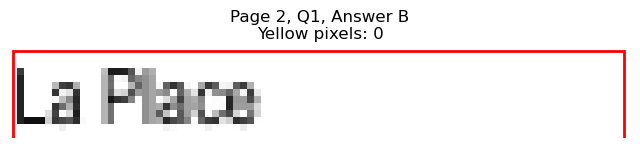

Page 2, Q1 - C: Detected box: x0=82.9, y0=122.9, x1=138.6, y1=135.6
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 261
Page 2, Q1, C: Yellow percentage: 0.0%


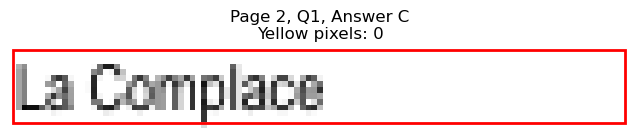

Page 2, Q1 - D: Detected box: x0=334.6, y0=97.7, x1=373.7, y1=110.4
Page 2, Q1, D: Yellow pixels: 90
Page 2, Q1, D: Total non-white pixels: 286
Page 2, Q1, D: Yellow percentage: 31.5%


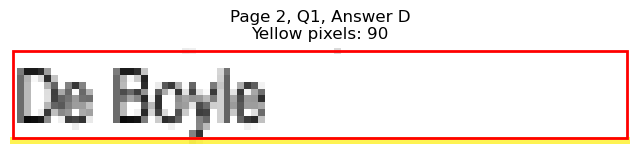

Page 2, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=353.2, y1=123.0
Page 2, Q1, E: Yellow pixels: 851
Page 2, Q1, E: Total non-white pixels: 910
Page 2, Q1, E: Yellow percentage: 93.5%


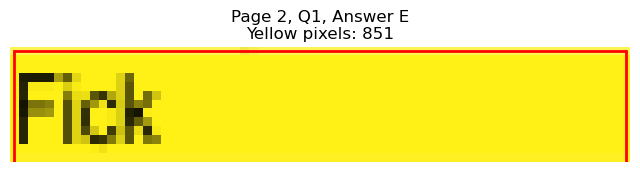


Page 2, Q1 - Selected Answer: E (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=70.8, y0=160.8, x1=79.3, y1=173.5
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 78
Page 2, Q2, A: Yellow percentage: 0.0%


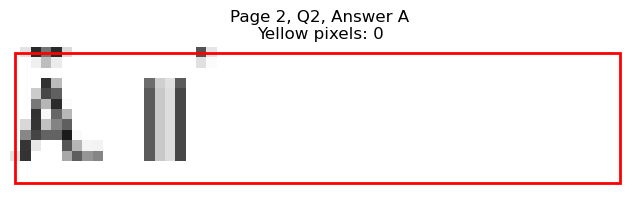

Page 2, Q2 - B: Detected box: x0=70.8, y0=173.4, x1=79.3, y1=186.1
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 58
Page 2, Q2, B: Yellow percentage: 0.0%


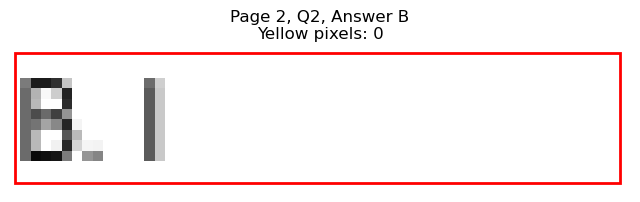

Page 2, Q2 - C: Detected box: x0=70.8, y0=186.0, x1=79.8, y1=198.7
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 68
Page 2, Q2, C: Yellow percentage: 0.0%


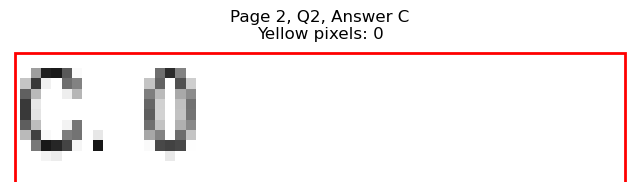

Page 2, Q2 - D: Detected box: x0=334.6, y0=160.8, x1=345.7, y1=173.5
Page 2, Q2, D: Yellow pixels: 62
Page 2, Q2, D: Total non-white pixels: 106
Page 2, Q2, D: Yellow percentage: 58.5%


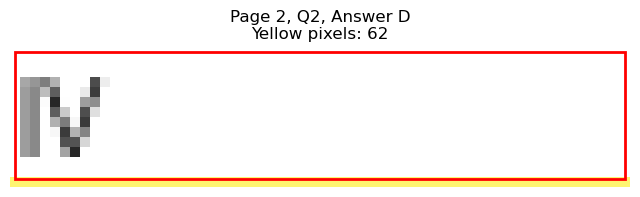

Page 2, Q2 - E: Detected box: x0=334.1, y0=173.4, x1=344.2, y1=186.1
Page 2, Q2, E: Yellow pixels: 761
Page 2, Q2, E: Total non-white pixels: 854
Page 2, Q2, E: Yellow percentage: 89.1%


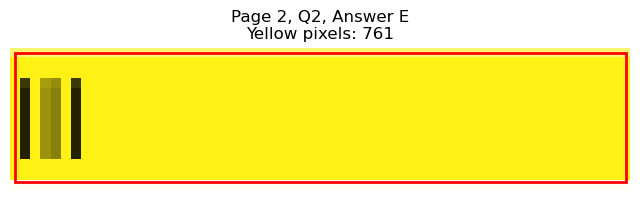


Page 2, Q2 - Selected Answer: E (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=82.5, y0=223.9, x1=133.6, y1=236.6
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 274
Page 2, Q3, A: Yellow percentage: 0.0%


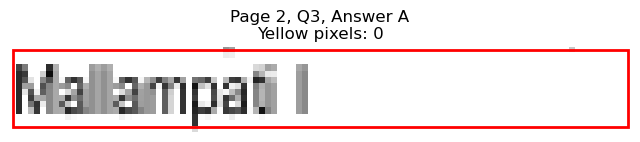

Page 2, Q3 - B: Detected box: x0=82.5, y0=236.5, x1=219.2, y1=249.2
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 674
Page 2, Q3, B: Yellow percentage: 0.0%


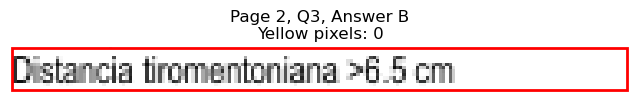

Page 2, Q3 - C: Detected box: x0=82.9, y0=249.1, x1=199.4, y1=261.8
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 592
Page 2, Q3, C: Yellow percentage: 0.0%


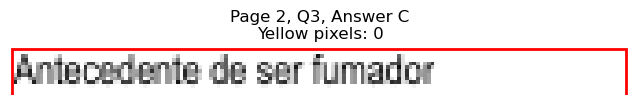

Page 2, Q3 - D: Detected box: x0=334.6, y0=223.9, x1=406.9, y1=236.6
Page 2, Q3, D: Yellow pixels: 123
Page 2, Q3, D: Total non-white pixels: 505
Page 2, Q3, D: Yellow percentage: 24.4%


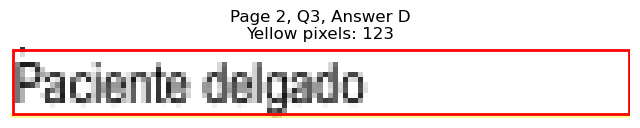

Page 2, Q3 - E: Detected box: x0=334.1, y0=236.5, x1=523.5, y1=249.2
Page 2, Q3, E: Yellow pixels: 1778
Page 2, Q3, E: Total non-white pixels: 2688
Page 2, Q3, E: Yellow percentage: 66.1%


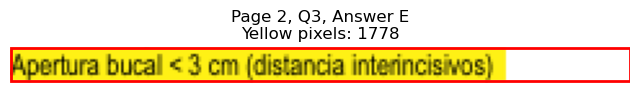


Page 2, Q3 - Selected Answer: E (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=82.5, y0=299.7, x1=97.6, y1=312.3
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 54
Page 2, Q4, A: Yellow percentage: 0.0%


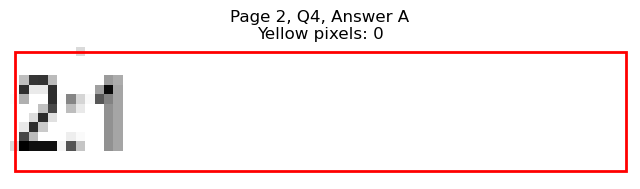

Page 2, Q4 - B: Detected box: x0=82.5, y0=312.3, x1=97.6, y1=324.9
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 46
Page 2, Q4, B: Yellow percentage: 0.0%


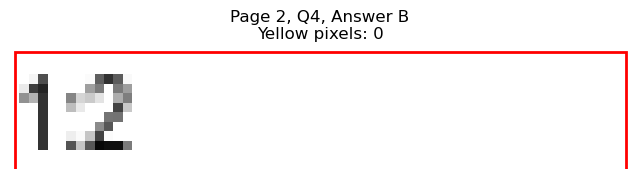

Page 2, Q4 - C: Detected box: x0=82.9, y0=324.9, x1=98.1, y1=337.5
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 47
Page 2, Q4, C: Yellow percentage: 0.0%


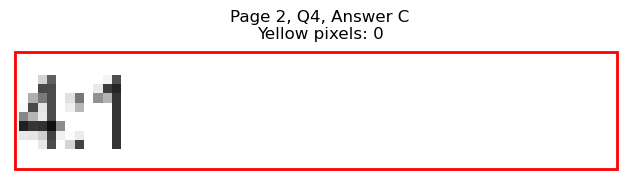

Page 2, Q4 - D: Detected box: x0=334.6, y0=299.7, x1=349.7, y1=312.3
Page 2, Q4, D: Yellow pixels: 758
Page 2, Q4, D: Total non-white pixels: 924
Page 2, Q4, D: Yellow percentage: 82.0%


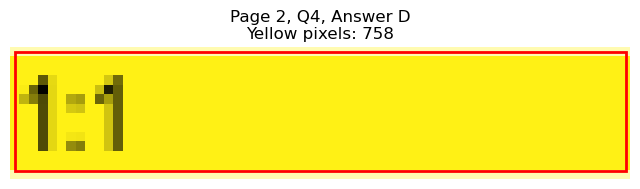

Page 2, Q4 - E: Detected box: x0=334.1, y0=312.3, x1=349.3, y1=324.9
Page 2, Q4, E: Yellow pixels: 0
Page 2, Q4, E: Total non-white pixels: 120
Page 2, Q4, E: Yellow percentage: 0.0%


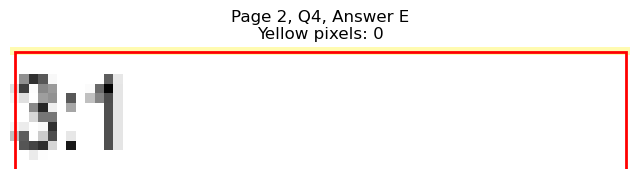


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=82.5, y0=362.8, x1=168.3, y1=375.5
Page 2, Q5, A: Yellow pixels: 137
Page 2, Q5, A: Total non-white pixels: 569
Page 2, Q5, A: Yellow percentage: 24.1%


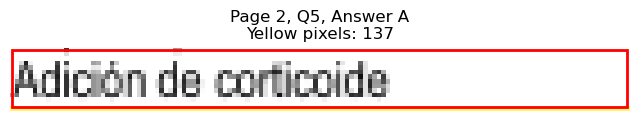

Page 2, Q5 - B: Detected box: x0=82.5, y0=375.4, x1=136.1, y1=388.1
Page 2, Q5, B: Yellow pixels: 1173
Page 2, Q5, B: Total non-white pixels: 1470
Page 2, Q5, B: Yellow percentage: 79.8%


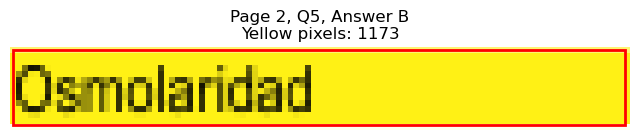

Page 2, Q5 - C: Detected box: x0=82.9, y0=388.0, x1=106.0, y1=400.7
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 187
Page 2, Q5, C: Yellow percentage: 0.0%


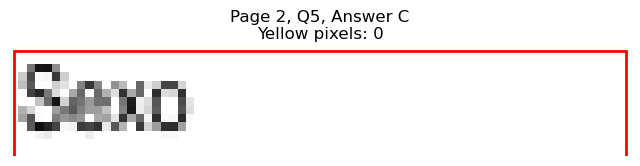

Page 2, Q5 - D: Detected box: x0=334.6, y0=362.8, x1=358.3, y1=375.5
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 116
Page 2, Q5, D: Yellow percentage: 0.0%


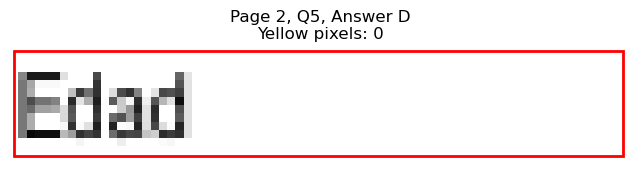

Page 2, Q5 - E: Detected box: x0=334.1, y0=375.4, x1=357.2, y1=388.1
Page 2, Q5, E: Yellow pixels: 0
Page 2, Q5, E: Total non-white pixels: 113
Page 2, Q5, E: Yellow percentage: 0.0%


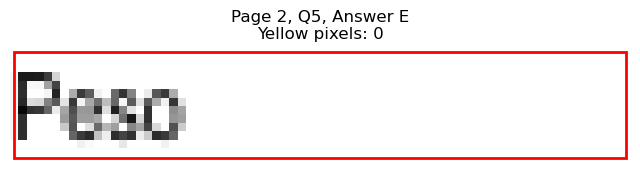


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=82.5, y0=425.9, x1=118.1, y1=438.6
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 189
Page 2, Q6, A: Yellow percentage: 0.0%


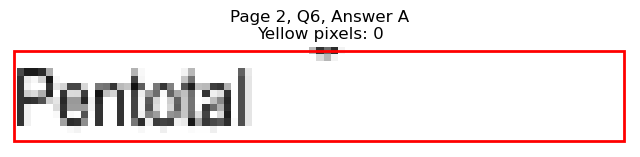

Page 2, Q6 - B: Detected box: x0=82.5, y0=438.5, x1=125.5, y1=451.2
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 216
Page 2, Q6, B: Yellow percentage: 0.0%


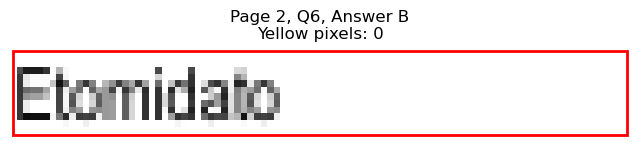

Page 2, Q6 - C: Detected box: x0=82.9, y0=451.1, x1=119.2, y1=463.8
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 187
Page 2, Q6, C: Yellow percentage: 0.0%


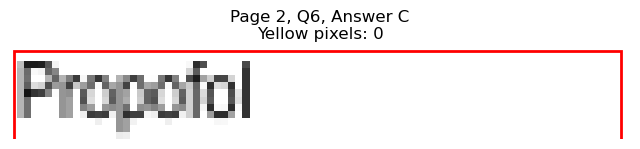

Page 2, Q6 - D: Detected box: x0=334.6, y0=425.9, x1=385.3, y1=438.6
Page 2, Q6, D: Yellow pixels: 1147
Page 2, Q6, D: Total non-white pixels: 1428
Page 2, Q6, D: Yellow percentage: 80.3%


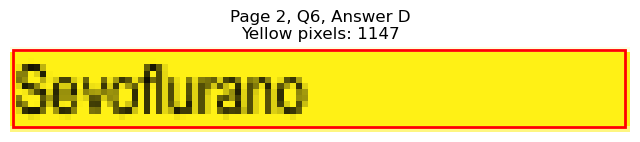

Page 2, Q6 - E: Detected box: x0=334.1, y0=438.5, x1=368.7, y1=451.2
Page 2, Q6, E: Yellow pixels: 85
Page 2, Q6, E: Total non-white pixels: 264
Page 2, Q6, E: Yellow percentage: 32.2%


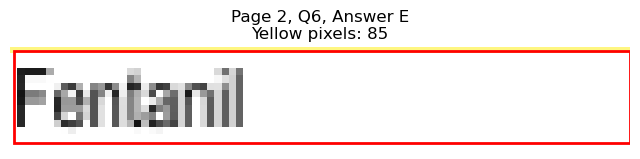


Page 2, Q6 - Selected Answer: D (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=82.5, y0=489.1, x1=257.2, y1=501.7
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 1083
Page 2, Q7, A: Yellow percentage: 0.0%


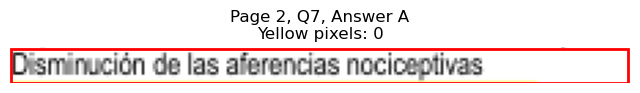

Page 2, Q7 - B: Detected box: x0=82.5, y0=501.7, x1=272.1, y1=514.3
Page 2, Q7, B: Yellow pixels: 1558
Page 2, Q7, B: Total non-white pixels: 2702
Page 2, Q7, B: Yellow percentage: 57.7%


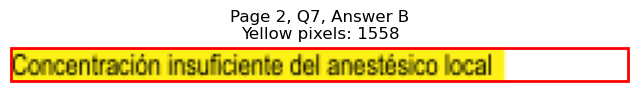

Page 2, Q7 - C: Detected box: x0=82.9, y0=514.3, x1=173.2, y1=526.9
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 591
Page 2, Q7, C: Yellow percentage: 0.0%


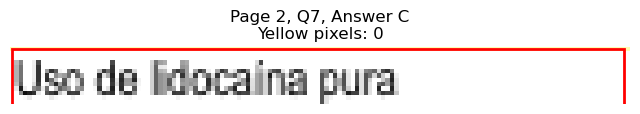

Page 2, Q7 - D: Detected box: x0=334.6, y0=489.1, x1=410.5, y1=501.7
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 369
Page 2, Q7, D: Yellow percentage: 0.0%


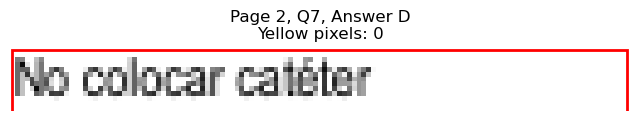

Page 2, Q7 - E: Detected box: x0=334.1, y0=501.7, x1=457.5, y1=514.3
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 611
Page 2, Q7, E: Yellow percentage: 0.0%


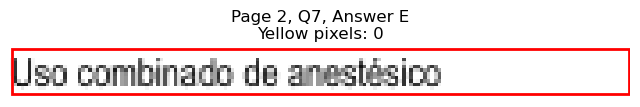


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=82.5, y0=552.2, x1=149.3, y1=564.8
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 361
Page 2, Q8, A: Yellow percentage: 0.0%


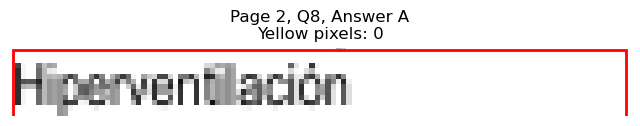

Page 2, Q8 - B: Detected box: x0=82.5, y0=564.8, x1=162.7, y1=577.4
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 437
Page 2, Q8, B: Yellow percentage: 0.0%


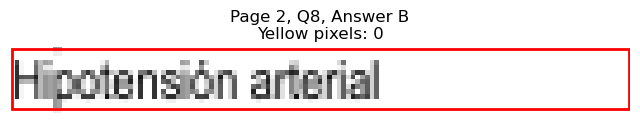

Page 2, Q8 - C: Detected box: x0=82.9, y0=577.4, x1=111.5, y1=590.0
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 144
Page 2, Q8, C: Yellow percentage: 0.0%


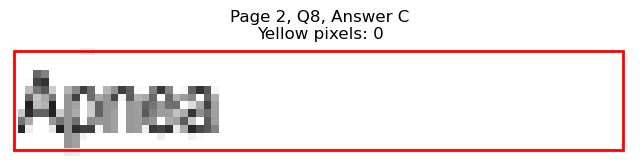

Page 2, Q8 - D: Detected box: x0=334.6, y0=552.2, x1=394.3, y1=564.8
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 430
Page 2, Q8, D: Yellow percentage: 0.0%


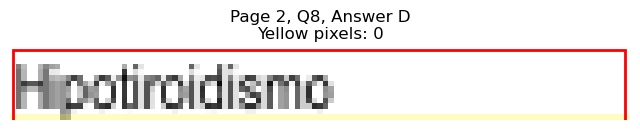

Page 2, Q8 - E: Detected box: x0=334.1, y0=564.8, x1=397.9, y1=577.4
Page 2, Q8, E: Yellow pixels: 1130
Page 2, Q8, E: Total non-white pixels: 1596
Page 2, Q8, E: Yellow percentage: 70.8%


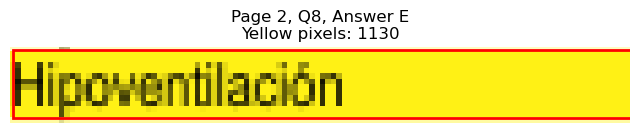


Page 2, Q8 - Selected Answer: E (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=82.5, y0=615.2, x1=197.3, y1=627.8
Page 2, Q9, A: Yellow pixels: 1672
Page 2, Q9, A: Total non-white pixels: 2158
Page 2, Q9, A: Yellow percentage: 77.5%


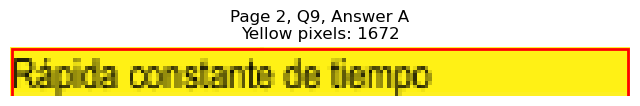

Page 2, Q9 - B: Detected box: x0=82.5, y0=627.9, x1=201.4, y1=640.6
Page 2, Q9, B: Yellow pixels: 167
Page 2, Q9, B: Total non-white pixels: 780
Page 2, Q9, B: Yellow percentage: 21.4%


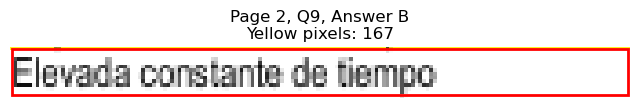

Page 2, Q9 - C: Detected box: x0=82.9, y0=640.5, x1=222.4, y1=653.2
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 709
Page 2, Q9, C: Yellow percentage: 0.0%


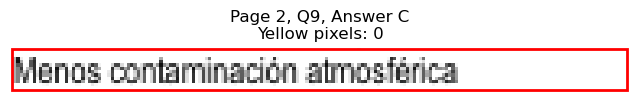

Page 2, Q9 - D: Detected box: x0=334.6, y0=615.2, x1=435.1, y1=627.8
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 530
Page 2, Q9, D: Yellow percentage: 0.0%


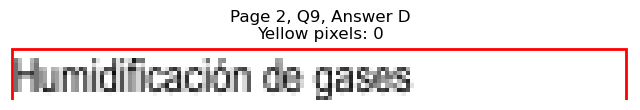

Page 2, Q9 - E: Detected box: x0=334.1, y0=627.9, x1=434.1, y1=640.6
Page 2, Q9, E: Yellow pixels: 0
Page 2, Q9, E: Total non-white pixels: 533
Page 2, Q9, E: Yellow percentage: 0.0%


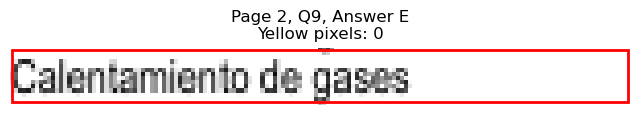


Page 2, Q9 - Selected Answer: A (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=82.5, y0=691.1, x1=145.7, y1=703.7
Page 2, Q10, A: Yellow pixels: 0
Page 2, Q10, A: Total non-white pixels: 315
Page 2, Q10, A: Yellow percentage: 0.0%


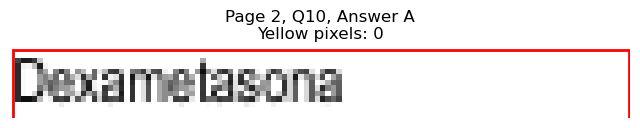

Page 2, Q10 - B: Detected box: x0=82.5, y0=703.7, x1=126.6, y1=716.3
Page 2, Q10, B: Yellow pixels: 0
Page 2, Q10, B: Total non-white pixels: 241
Page 2, Q10, B: Yellow percentage: 0.0%


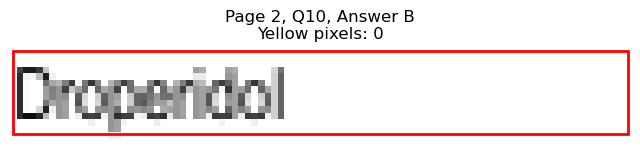

Page 2, Q10 - C: Detected box: x0=82.9, y0=716.3, x1=146.2, y1=728.9
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 326
Page 2, Q10, C: Yellow percentage: 0.0%


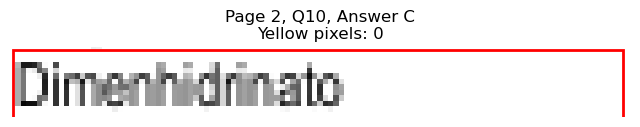

Page 2, Q10 - D: Detected box: x0=334.6, y0=691.1, x1=384.3, y1=703.7
Page 2, Q10, D: Yellow pixels: 1134
Page 2, Q10, D: Total non-white pixels: 1313
Page 2, Q10, D: Yellow percentage: 86.4%


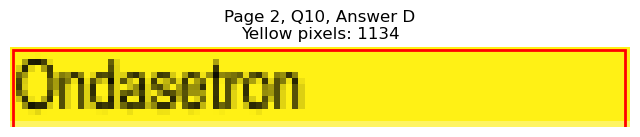

Page 2, Q10 - E: Detected box: x0=334.1, y0=703.7, x1=393.3, y1=716.3
Page 2, Q10, E: Yellow pixels: 110
Page 2, Q10, E: Total non-white pixels: 423
Page 2, Q10, E: Yellow percentage: 26.0%


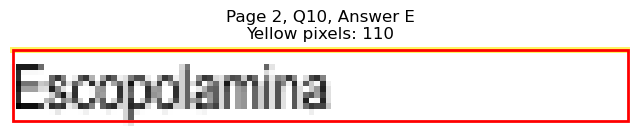


Page 2, Q10 - Selected Answer: D (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=148.1, y1=110.4
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 337
Page 3, Q1, A: Yellow percentage: 0.0%


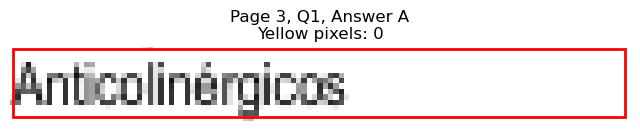

Page 3, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=144.6, y1=123.0
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 323
Page 3, Q1, B: Yellow percentage: 0.0%


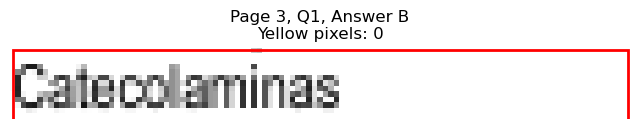

Page 3, Q1 - C: Detected box: x0=82.9, y0=122.9, x1=146.7, y1=135.6
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 382
Page 3, Q1, C: Yellow percentage: 0.0%


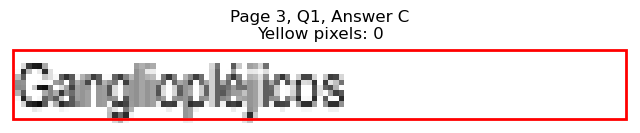

Page 3, Q1 - D: Detected box: x0=334.6, y0=97.7, x1=411.9, y1=110.4
Page 3, Q1, D: Yellow pixels: 1241
Page 3, Q1, D: Total non-white pixels: 1792
Page 3, Q1, D: Yellow percentage: 69.3%


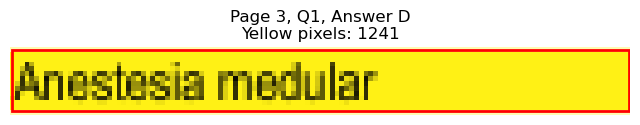

Page 3, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=439.5, y1=123.0
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 700
Page 3, Q1, E: Yellow percentage: 0.0%


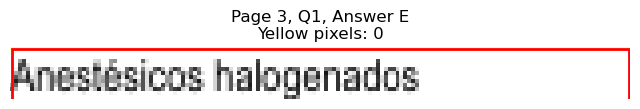


Page 3, Q1 - Selected Answer: D (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=82.5, y0=160.8, x1=253.1, y1=173.5
Page 3, Q2, A: Yellow pixels: 192
Page 3, Q2, A: Total non-white pixels: 1005
Page 3, Q2, A: Yellow percentage: 19.1%


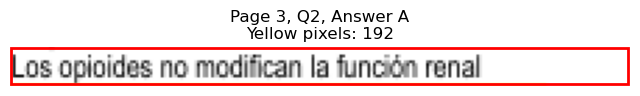

Page 3, Q2 - B: Detected box: x0=82.5, y0=173.4, x1=275.3, y1=186.1
Page 3, Q2, B: Yellow pixels: 1929
Page 3, Q2, B: Total non-white pixels: 2723
Page 3, Q2, B: Yellow percentage: 70.8%


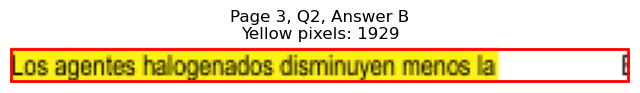

Page 3, Q2 - C: Detected box: x0=82.9, y0=198.6, x1=275.3, y1=211.3
Page 3, Q2, C: Yellow pixels: 191
Page 3, Q2, C: Total non-white pixels: 1151
Page 3, Q2, C: Yellow percentage: 16.6%


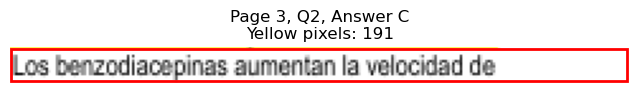

Page 3, Q2 - D: Detected box: x0=334.6, y0=160.8, x1=427.4, y1=173.5
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 466
Page 3, Q2, D: Yellow percentage: 0.0%


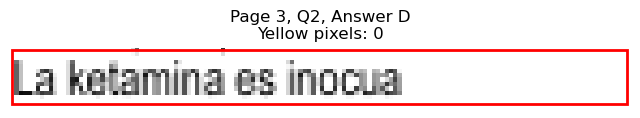

Page 3, Q2 - E: Detected box: x0=334.1, y0=173.4, x1=496.2, y1=186.1
Page 3, Q2, E: Yellow pixels: 0
Page 3, Q2, E: Total non-white pixels: 797
Page 3, Q2, E: Yellow percentage: 0.0%


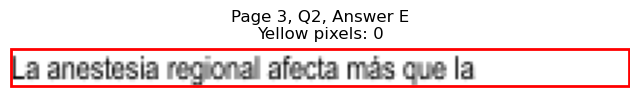


Page 3, Q2 - Selected Answer: B (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=82.5, y0=261.7, x1=124.1, y1=274.4
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 181
Page 3, Q3, A: Yellow percentage: 0.0%


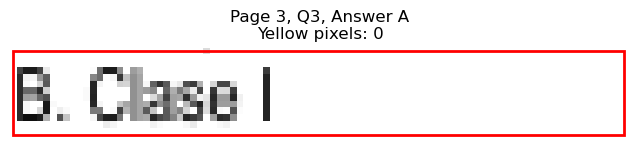

Page 3, Q3 - B: Detected box: x0=82.5, y0=274.5, x1=142.1, y1=287.1
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 239
Page 3, Q3, B: Yellow percentage: 0.0%


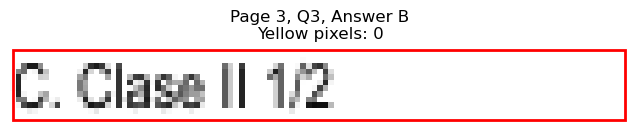

Page 3, Q3 - C: Detected box: x0=82.9, y0=287.1, x1=130.1, y1=299.7
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 211
Page 3, Q3, C: Yellow percentage: 0.0%


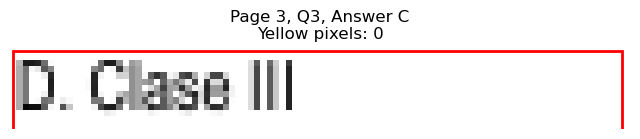

Page 3, Q3 - D: Detected box: x0=334.6, y0=261.7, x1=396.3, y1=274.4
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 260
Page 3, Q3, D: Yellow percentage: 0.0%


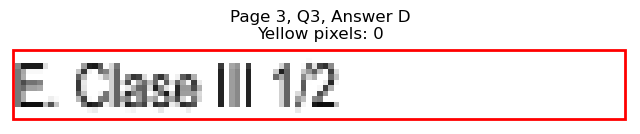

Page 3, Q3 - E: Detected box: x0=334.1, y0=274.5, x1=378.3, y1=287.1
Page 3, Q3, E: Yellow pixels: 1093
Page 3, Q3, E: Total non-white pixels: 1330
Page 3, Q3, E: Yellow percentage: 82.2%


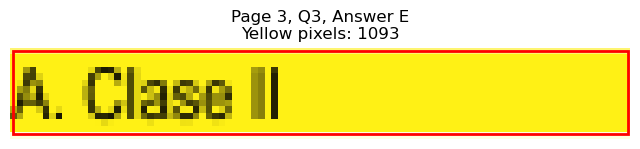


Page 3, Q3 - Selected Answer: E (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=82.5, y0=337.5, x1=258.6, y1=350.1
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 827
Page 3, Q4, A: Yellow percentage: 0.0%


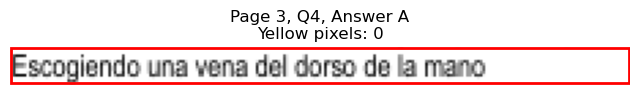

Page 3, Q4 - B: Detected box: x0=82.5, y0=350.2, x1=178.7, y1=362.9
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 492
Page 3, Q4, B: Yellow percentage: 0.0%


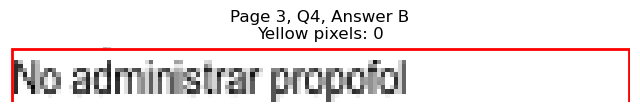

Page 3, Q4 - C: Detected box: x0=82.9, y0=362.8, x1=179.8, y1=375.5
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 510
Page 3, Q4, C: Yellow percentage: 0.0%


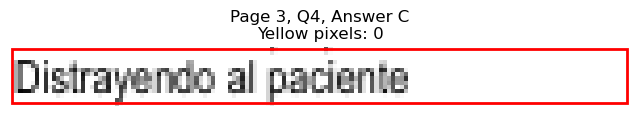

Page 3, Q4 - D: Detected box: x0=334.6, y0=337.5, x1=526.8, y1=350.1
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 924
Page 3, Q4, D: Yellow percentage: 0.0%


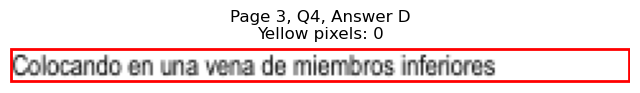

Page 3, Q4 - E: Detected box: x0=467.5, y0=350.2, x1=514.6, y1=362.9
Page 3, Q4, E: Yellow pixels: 540
Page 3, Q4, E: Total non-white pixels: 767
Page 3, Q4, E: Yellow percentage: 70.4%


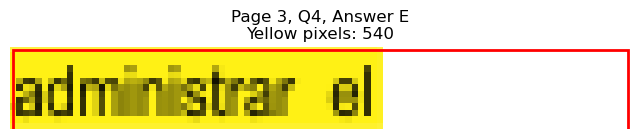


Page 3, Q4 - Selected Answer: E (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=82.5, y0=413.3, x1=160.9, y1=426.0
Page 3, Q5, A: Yellow pixels: 1387
Page 3, Q5, A: Total non-white pixels: 1677
Page 3, Q5, A: Yellow percentage: 82.7%


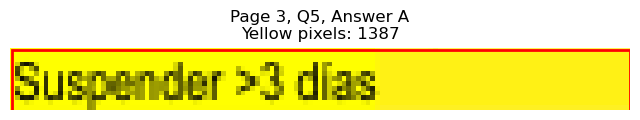

Page 3, Q5 - B: Detected box: x0=82.5, y0=425.9, x1=164.7, y1=438.6
Page 3, Q5, B: Yellow pixels: 131
Page 3, Q5, B: Total non-white pixels: 507
Page 3, Q5, B: Yellow percentage: 25.8%


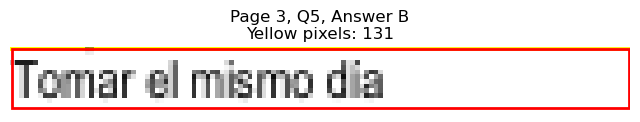

Page 3, Q5 - C: Detected box: x0=82.9, y0=438.5, x1=171.5, y1=451.2
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 400
Page 3, Q5, C: Yellow percentage: 0.0%


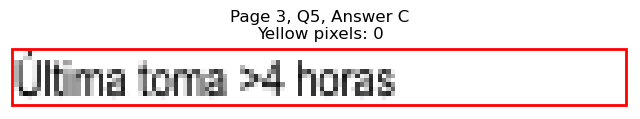

Page 3, Q5 - D: Detected box: x0=334.6, y0=413.3, x1=429.2, y1=426.0
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 450
Page 3, Q5, D: Yellow percentage: 0.0%


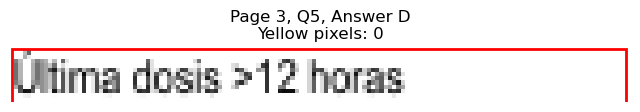

Page 3, Q5 - E: Detected box: x0=334.1, y0=425.9, x1=401.9, y1=438.6
Page 3, Q5, E: Yellow pixels: 0
Page 3, Q5, E: Total non-white pixels: 329
Page 3, Q5, E: Yellow percentage: 0.0%


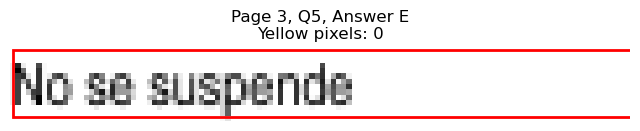


Page 3, Q5 - Selected Answer: A (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=82.5, y0=476.3, x1=251.6, y1=489.0
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 863
Page 3, Q6, A: Yellow percentage: 0.0%


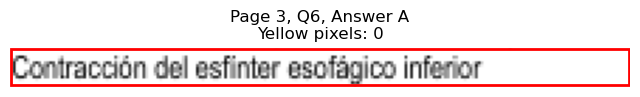

Page 3, Q6 - B: Detected box: x0=82.5, y0=489.1, x1=172.7, y1=501.7
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 598
Page 3, Q6, B: Yellow percentage: 0.0%


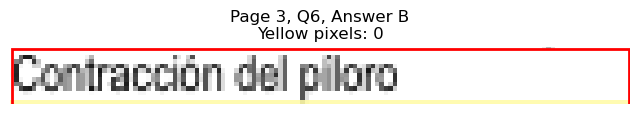

Page 3, Q6 - C: Detected box: x0=82.9, y0=501.7, x1=275.2, y1=514.3
Page 3, Q6, C: Yellow pixels: 1752
Page 3, Q6, C: Total non-white pixels: 2702
Page 3, Q6, C: Yellow percentage: 64.8%


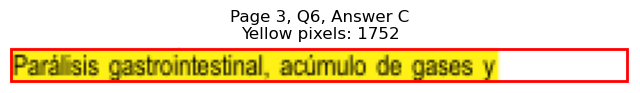

Page 3, Q6 - D: Detected box: x0=334.6, y0=476.3, x1=496.8, y1=489.0
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 790
Page 3, Q6, D: Yellow percentage: 0.0%


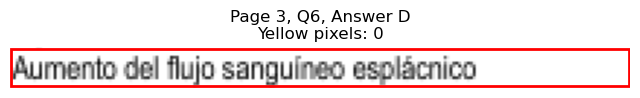

Page 3, Q6 - E: Detected box: x0=334.1, y0=489.1, x1=489.6, y1=501.7
Page 3, Q6, E: Yellow pixels: 0
Page 3, Q6, E: Total non-white pixels: 787
Page 3, Q6, E: Yellow percentage: 0.0%


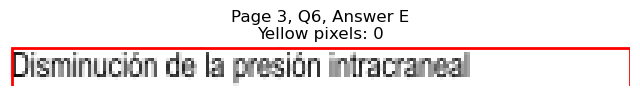


Page 3, Q6 - Selected Answer: C (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=82.5, y0=552.2, x1=122.1, y1=564.8
Page 3, Q7, A: Yellow pixels: 1034
Page 3, Q7, A: Total non-white pixels: 1183
Page 3, Q7, A: Yellow percentage: 87.4%


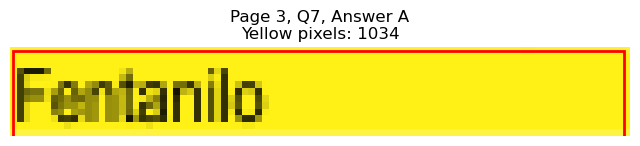

Page 3, Q7 - B: Detected box: x0=82.5, y0=564.8, x1=139.6, y1=577.4
Page 3, Q7, B: Yellow pixels: 108
Page 3, Q7, B: Total non-white pixels: 378
Page 3, Q7, B: Yellow percentage: 28.6%


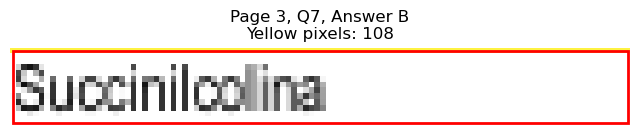

Page 3, Q7 - C: Detected box: x0=82.9, y0=577.4, x1=131.1, y1=590.0
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 224
Page 3, Q7, C: Yellow percentage: 0.0%


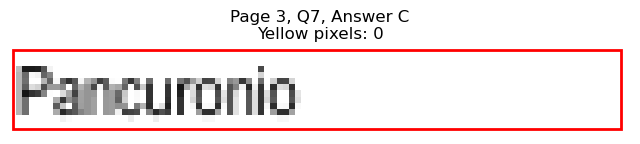

Page 3, Q7 - D: Detected box: x0=334.6, y0=552.2, x1=387.3, y1=564.8
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 293
Page 3, Q7, D: Yellow percentage: 0.0%


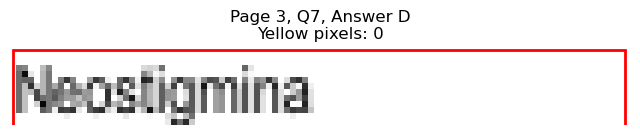

Page 3, Q7 - E: Detected box: x0=334.1, y0=564.8, x1=382.3, y1=577.4
Page 3, Q7, E: Yellow pixels: 0
Page 3, Q7, E: Total non-white pixels: 247
Page 3, Q7, E: Yellow percentage: 0.0%


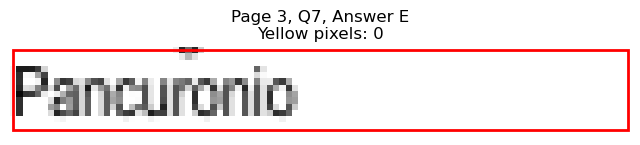


Page 3, Q7 - Selected Answer: A (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=82.5, y0=615.2, x1=114.0, y1=627.8
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 149
Page 3, Q8, A: Yellow percentage: 0.0%


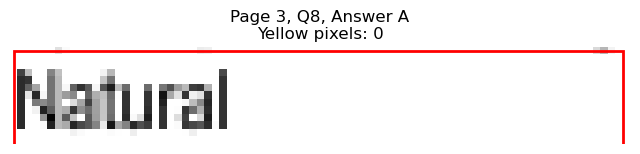

Page 3, Q8 - B: Detected box: x0=82.5, y0=627.9, x1=141.1, y1=640.6
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 313
Page 3, Q8, B: Yellow percentage: 0.0%


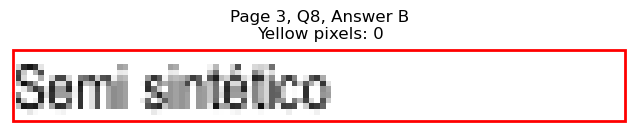

Page 3, Q8 - C: Detected box: x0=82.9, y0=640.5, x1=127.6, y1=653.2
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 236
Page 3, Q8, C: Yellow percentage: 0.0%


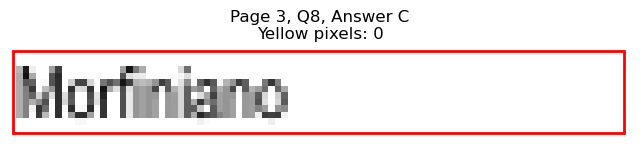

Page 3, Q8 - D: Detected box: x0=334.6, y0=615.2, x1=388.7, y1=627.8
Page 3, Q8, D: Yellow pixels: 1121
Page 3, Q8, D: Total non-white pixels: 1365
Page 3, Q8, D: Yellow percentage: 82.1%


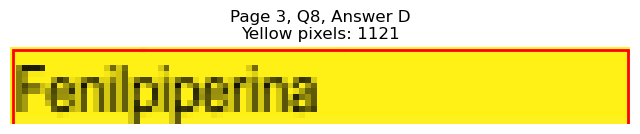

Page 3, Q8 - E: Detected box: x0=334.1, y0=627.9, x1=381.8, y1=640.6
Page 3, Q8, E: Yellow pixels: 94
Page 3, Q8, E: Total non-white pixels: 347
Page 3, Q8, E: Yellow percentage: 27.1%


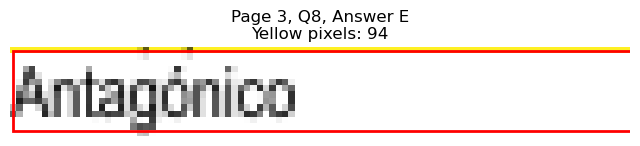


Page 3, Q8 - Selected Answer: D (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=82.5, y0=678.3, x1=125.5, y1=691.0
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 216
Page 3, Q9, A: Yellow percentage: 0.0%


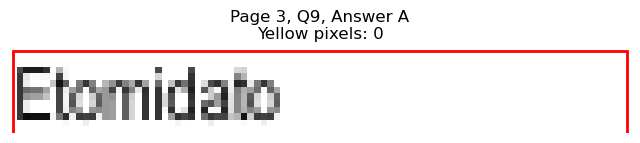

Page 3, Q9 - B: Detected box: x0=82.5, y0=691.1, x1=130.1, y1=703.7
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 227
Page 3, Q9, B: Yellow percentage: 0.0%


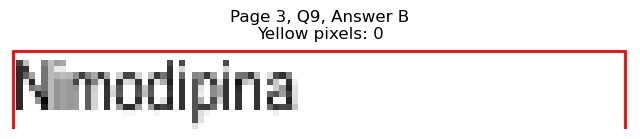

Page 3, Q9 - C: Detected box: x0=82.9, y0=703.7, x1=130.6, y1=716.3
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 264
Page 3, Q9, C: Yellow percentage: 0.0%


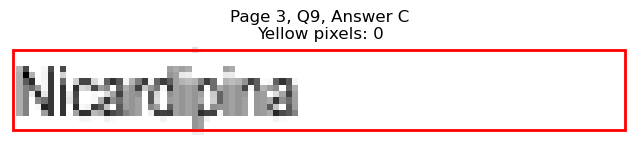

Page 3, Q9 - D: Detected box: x0=334.6, y0=678.3, x1=387.3, y1=691.0
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 289
Page 3, Q9, D: Yellow percentage: 0.0%


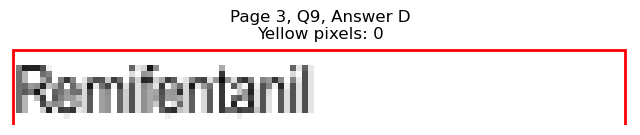

Page 3, Q9 - E: Detected box: x0=334.1, y0=691.1, x1=374.8, y1=703.7
Page 3, Q9, E: Yellow pixels: 1027
Page 3, Q9, E: Total non-white pixels: 1183
Page 3, Q9, E: Yellow percentage: 86.8%


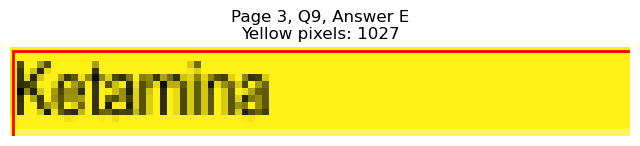


Page 3, Q9 - Selected Answer: E (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=82.5, y0=741.4, x1=115.1, y1=754.1
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 152
Page 3, Q10, A: Yellow percentage: 0.0%


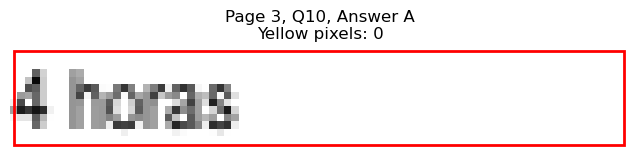

Page 3, Q10 - B: Detected box: x0=82.5, y0=754.0, x1=115.1, y1=766.7
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 145
Page 3, Q10, B: Yellow percentage: 0.0%


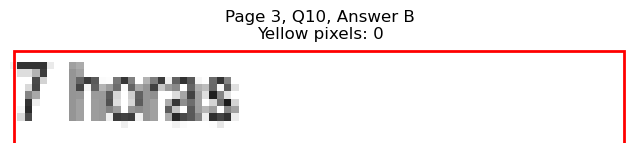

Page 3, Q10 - C: Detected box: x0=82.9, y0=766.8, x1=115.6, y1=779.4
Page 3, Q10, C: Yellow pixels: 904
Page 3, Q10, C: Total non-white pixels: 1176
Page 3, Q10, C: Yellow percentage: 76.9%


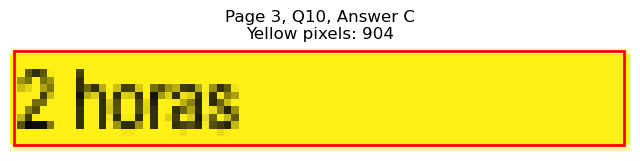

Page 3, Q10 - D: Detected box: x0=334.6, y0=741.4, x1=367.4, y1=754.1
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 156
Page 3, Q10, D: Yellow percentage: 0.0%


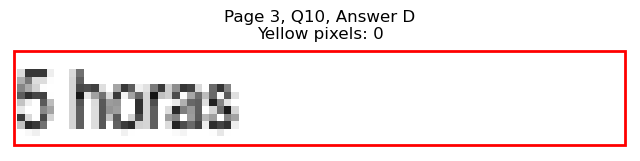

Page 3, Q10 - E: Detected box: x0=334.1, y0=754.0, x1=364.4, y1=766.7
Page 3, Q10, E: Yellow pixels: 0
Page 3, Q10, E: Total non-white pixels: 153
Page 3, Q10, E: Yellow percentage: 0.0%


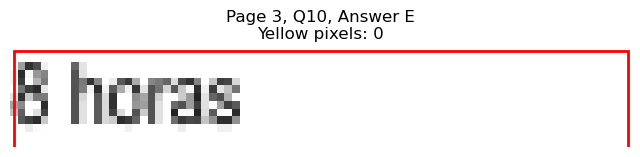


Page 3, Q10 - Selected Answer: C (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=184.8, y1=110.4
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 549
Page 4, Q1, A: Yellow percentage: 0.0%


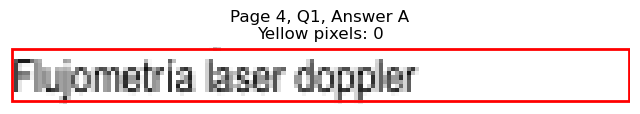

Page 4, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=202.8, y1=123.0
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 612
Page 4, Q1, B: Yellow percentage: 0.0%


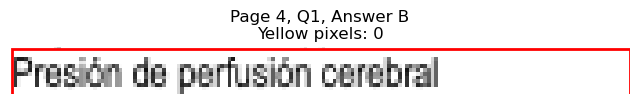

Page 4, Q1 - C: Detected box: x0=152.9, y0=122.9, x1=219.6, y1=135.6
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 331
Page 4, Q1, C: Yellow percentage: 0.0%


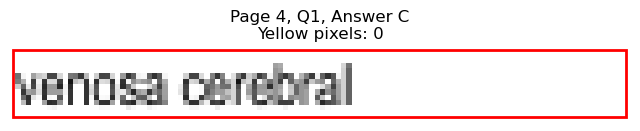

Page 4, Q1 - D: Detected box: x0=350.8, y0=97.7, x1=388.5, y1=110.4
Page 4, Q1, D: Yellow pixels: 89
Page 4, Q1, D: Total non-white pixels: 273
Page 4, Q1, D: Yellow percentage: 32.6%


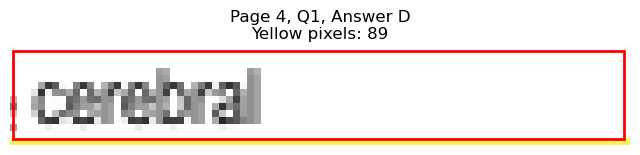

Page 4, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=471.0, y1=123.0
Page 4, Q1, E: Yellow pixels: 1890
Page 4, Q1, E: Total non-white pixels: 2431
Page 4, Q1, E: Yellow percentage: 77.7%


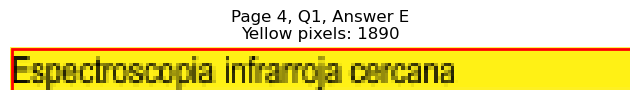


Page 4, Q1 - Selected Answer: E (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=82.5, y0=160.8, x1=97.6, y1=173.5
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 55
Page 4, Q2, A: Yellow percentage: 0.0%


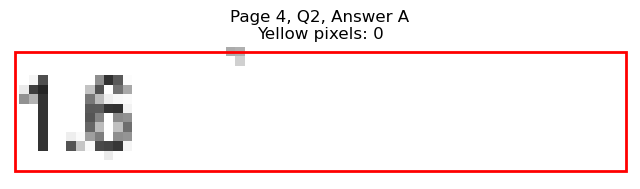

Page 4, Q2 - B: Detected box: x0=82.5, y0=173.4, x1=97.6, y1=186.1
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 73
Page 4, Q2, B: Yellow percentage: 0.0%


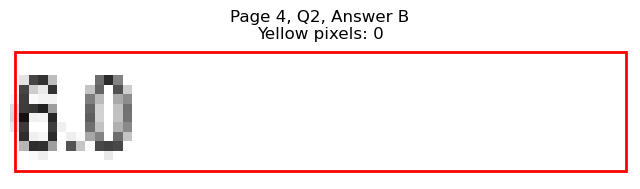

Page 4, Q2 - C: Detected box: x0=82.9, y0=186.0, x1=103.0, y1=198.7
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 88
Page 4, Q2, C: Yellow percentage: 0.0%


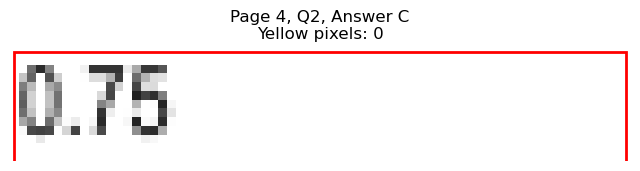

Page 4, Q2 - D: Detected box: x0=334.6, y0=160.8, x1=349.7, y1=173.5
Page 4, Q2, D: Yellow pixels: 66
Page 4, Q2, D: Total non-white pixels: 116
Page 4, Q2, D: Yellow percentage: 56.9%


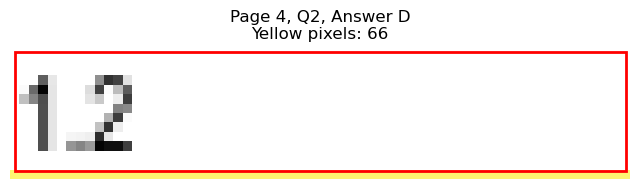

Page 4, Q2 - E: Detected box: x0=334.1, y0=173.4, x1=349.3, y1=186.1
Page 4, Q2, E: Yellow pixels: 813
Page 4, Q2, E: Total non-white pixels: 924
Page 4, Q2, E: Yellow percentage: 88.0%


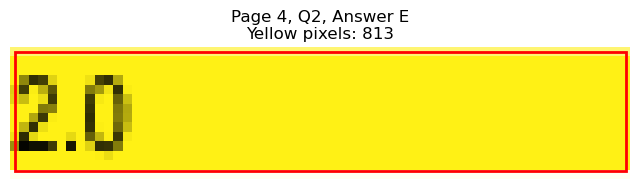


Page 4, Q2 - Selected Answer: E (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=82.5, y0=223.9, x1=148.8, y1=236.6
Page 4, Q3, A: Yellow pixels: 117
Page 4, Q3, A: Total non-white pixels: 423
Page 4, Q3, A: Yellow percentage: 27.7%


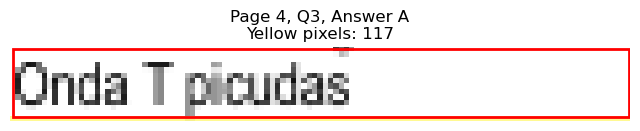

Page 4, Q3 - B: Detected box: x0=82.5, y0=236.5, x1=169.2, y1=249.2
Page 4, Q3, B: Yellow pixels: 1472
Page 4, Q3, B: Total non-white pixels: 1932
Page 4, Q3, B: Yellow percentage: 76.2%


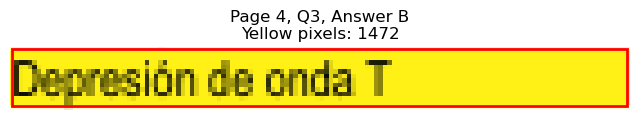

Page 4, Q3 - C: Detected box: x0=82.9, y0=249.1, x1=132.1, y1=261.8
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 347
Page 4, Q3, C: Yellow percentage: 0.0%


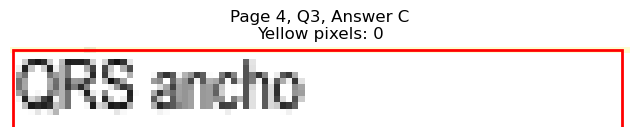

Page 4, Q3 - D: Detected box: x0=334.6, y0=223.9, x1=405.3, y1=236.6
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 338
Page 4, Q3, D: Yellow percentage: 0.0%


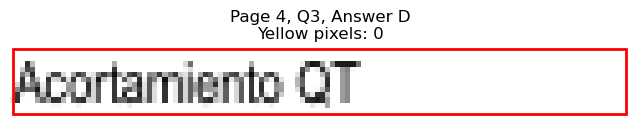

Page 4, Q3 - E: Detected box: x0=334.1, y0=236.5, x1=446.9, y1=249.2
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 571
Page 4, Q3, E: Yellow percentage: 0.0%


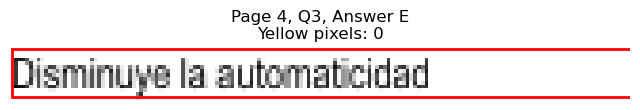


Page 4, Q3 - Selected Answer: B (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=82.5, y0=287.1, x1=121.6, y1=299.7
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 288
Page 4, Q4, A: Yellow percentage: 0.0%


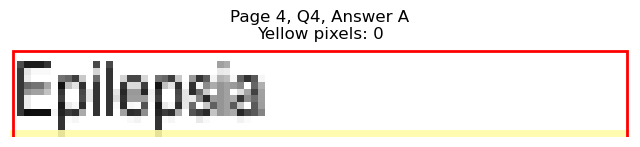

Page 4, Q4 - B: Detected box: x0=82.5, y0=299.7, x1=172.2, y1=312.3
Page 4, Q4, B: Yellow pixels: 1326
Page 4, Q4, B: Total non-white pixels: 1974
Page 4, Q4, B: Yellow percentage: 67.2%


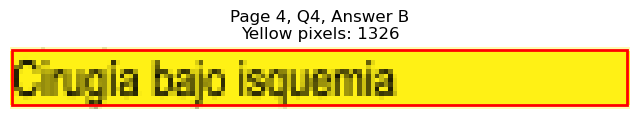

Page 4, Q4 - C: Detected box: x0=82.9, y0=312.3, x1=175.3, y1=324.9
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 601
Page 4, Q4, C: Yellow percentage: 0.0%


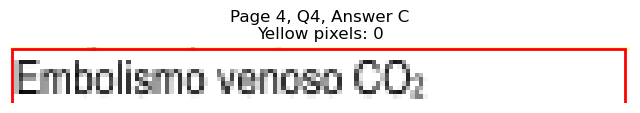

Page 4, Q4 - D: Detected box: x0=334.6, y0=287.1, x1=397.3, y1=299.7
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 343
Page 4, Q4, D: Yellow percentage: 0.0%


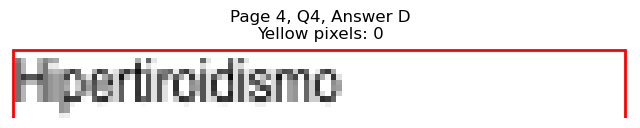

Page 4, Q4 - E: Detected box: x0=334.1, y0=299.7, x1=362.2, y1=312.3
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 139
Page 4, Q4, E: Yellow percentage: 0.0%


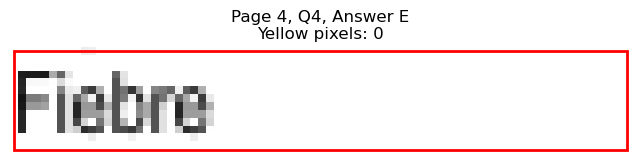


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=82.5, y0=350.2, x1=268.5, y1=362.9
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 932
Page 4, Q5, A: Yellow percentage: 0.0%


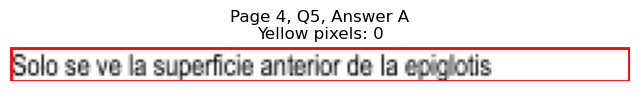

Page 4, Q5 - B: Detected box: x0=82.5, y0=362.8, x1=233.0, y1=375.5
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 750
Page 4, Q5, B: Yellow percentage: 0.0%


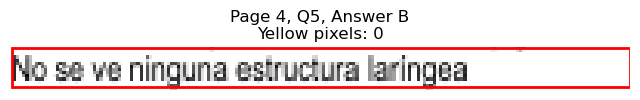

Page 4, Q5 - C: Detected box: x0=82.9, y0=375.4, x1=258.0, y1=388.1
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 816
Page 4, Q5, C: Yellow percentage: 0.0%


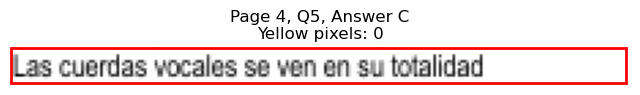

Page 4, Q5 - D: Detected box: x0=492.5, y0=350.2, x1=526.9, y1=362.9
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 178
Page 4, Q5, D: Yellow percentage: 0.0%


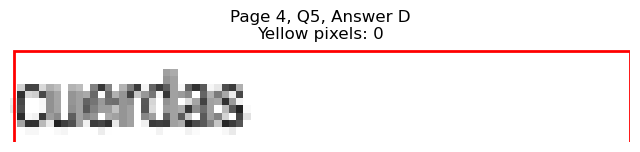

Page 4, Q5 - E: Detected box: x0=334.1, y0=375.4, x1=526.9, y1=388.1
Page 4, Q5, E: Yellow pixels: 2002
Page 4, Q5, E: Total non-white pixels: 2688
Page 4, Q5, E: Yellow percentage: 74.5%


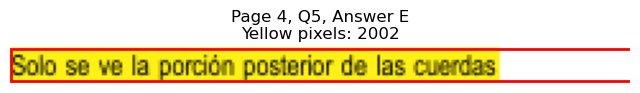


Page 4, Q5 - Selected Answer: E (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=82.5, y0=425.9, x1=275.2, y1=438.6
Page 4, Q6, A: Yellow pixels: 5
Page 4, Q6, A: Total non-white pixels: 933
Page 4, Q6, A: Yellow percentage: 0.5%


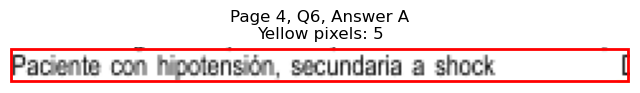

Page 4, Q6 - B: Detected box: x0=82.5, y0=451.1, x1=263.4, y1=463.8
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 882
Page 4, Q6, B: Yellow percentage: 0.0%


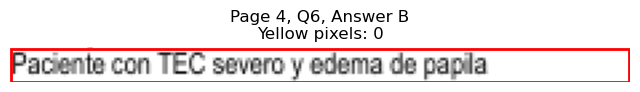

Page 4, Q6 - C: Detected box: x0=82.9, y0=463.7, x1=258.5, y1=476.4
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 872
Page 4, Q6, C: Yellow percentage: 0.0%


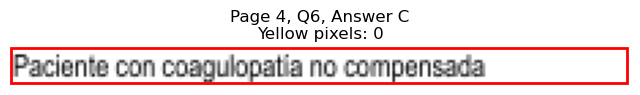

Page 4, Q6 - D: Detected box: x0=334.6, y0=425.9, x1=514.7, y1=438.6
Page 4, Q6, D: Yellow pixels: 192
Page 4, Q6, D: Total non-white pixels: 1055
Page 4, Q6, D: Yellow percentage: 18.2%


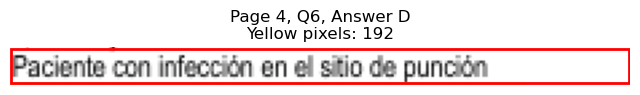

Page 4, Q6 - E: Detected box: x0=405.6, y0=438.5, x1=457.7, y1=451.2
Page 4, Q6, E: Yellow pixels: 1085
Page 4, Q6, E: Total non-white pixels: 1442
Page 4, Q6, E: Yellow percentage: 75.2%


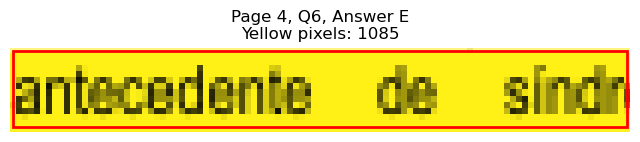


Page 4, Q6 - Selected Answer: E (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=82.5, y0=526.9, x1=115.1, y1=539.5
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 152
Page 4, Q7, A: Yellow percentage: 0.0%


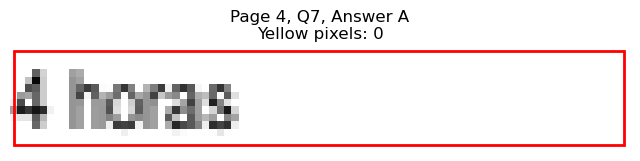

Page 4, Q7 - B: Detected box: x0=82.5, y0=539.5, x1=115.1, y1=552.1
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 149
Page 4, Q7, B: Yellow percentage: 0.0%


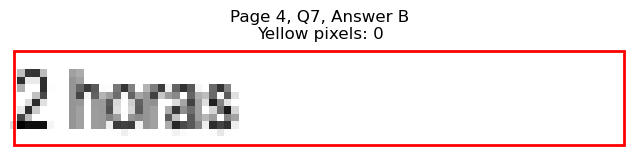

Page 4, Q7 - C: Detected box: x0=82.9, y0=552.2, x1=111.0, y1=564.8
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 101
Page 4, Q7, C: Yellow percentage: 0.0%


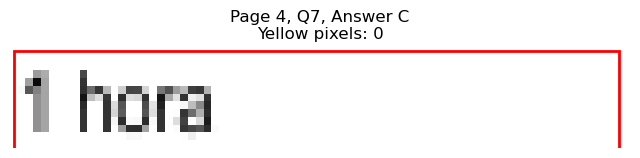

Page 4, Q7 - D: Detected box: x0=334.6, y0=526.9, x1=382.3, y1=539.5
Page 4, Q7, D: Yellow pixels: 99
Page 4, Q7, D: Total non-white pixels: 345
Page 4, Q7, D: Yellow percentage: 28.7%


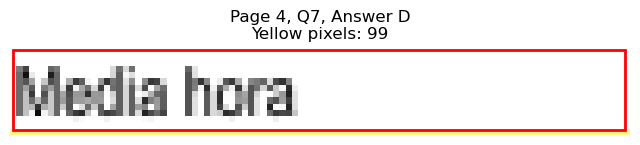

Page 4, Q7 - E: Detected box: x0=334.1, y0=539.5, x1=366.8, y1=552.1
Page 4, Q7, E: Yellow pixels: 967
Page 4, Q7, E: Total non-white pixels: 1162
Page 4, Q7, E: Yellow percentage: 83.2%


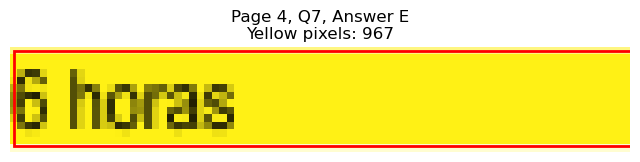


Page 4, Q7 - Selected Answer: E (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=70.8, y0=590.0, x1=79.3, y1=602.6
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 59
Page 4, Q8, A: Yellow percentage: 0.0%


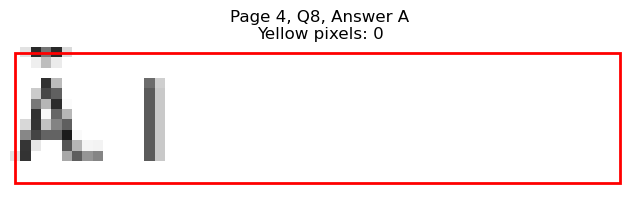

Page 4, Q8 - B: Detected box: x0=82.5, y0=602.6, x1=93.5, y1=615.2
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 42
Page 4, Q8, B: Yellow percentage: 0.0%


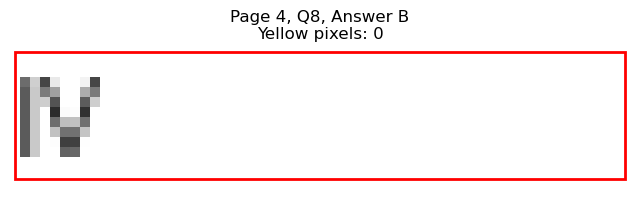

Page 4, Q8 - C: Detected box: x0=82.9, y0=615.2, x1=93.0, y1=627.8
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 48
Page 4, Q8, C: Yellow percentage: 0.0%


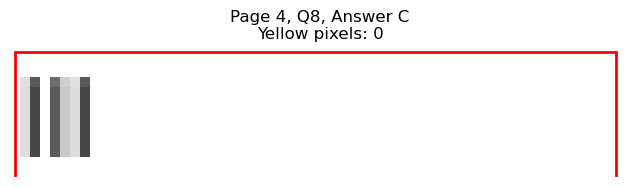

Page 4, Q8 - D: Detected box: x0=322.5, y0=590.0, x1=331.5, y1=602.6
Page 4, Q8, D: Yellow pixels: 60
Page 4, Q8, D: Total non-white pixels: 134
Page 4, Q8, D: Yellow percentage: 44.8%


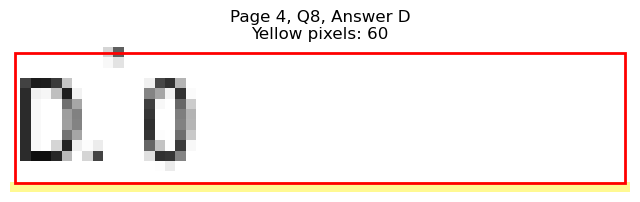

Page 4, Q8 - E: Detected box: x0=322.5, y0=602.6, x1=331.0, y1=615.2
Page 4, Q8, E: Yellow pixels: 730
Page 4, Q8, E: Total non-white pixels: 840
Page 4, Q8, E: Yellow percentage: 86.9%


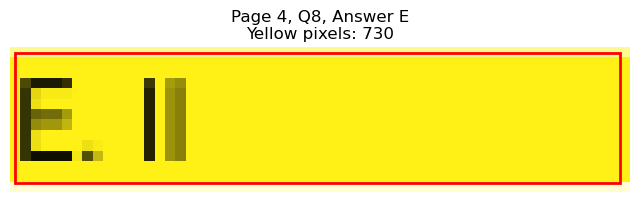


Page 4, Q8 - Selected Answer: E (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=82.5, y0=653.1, x1=121.1, y1=665.8
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 274
Page 4, Q9, A: Yellow percentage: 0.0%


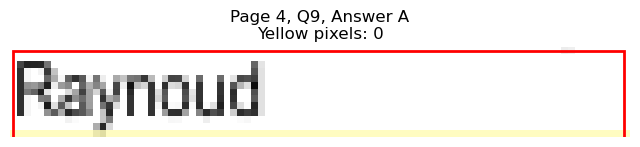

Page 4, Q9 - B: Detected box: x0=82.5, y0=665.7, x1=178.2, y1=678.4
Page 4, Q9, B: Yellow pixels: 1391
Page 4, Q9, B: Total non-white pixels: 2058
Page 4, Q9, B: Yellow percentage: 67.6%


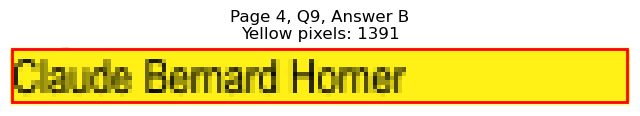

Page 4, Q9 - C: Detected box: x0=82.9, y0=678.3, x1=187.7, y1=691.0
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 664
Page 4, Q9, C: Yellow percentage: 0.0%


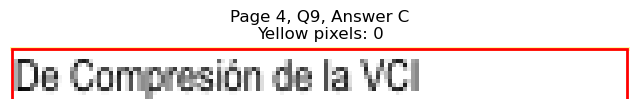

Page 4, Q9 - D: Detected box: x0=334.6, y0=653.1, x1=370.3, y1=665.8
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 185
Page 4, Q9, D: Yellow percentage: 0.0%


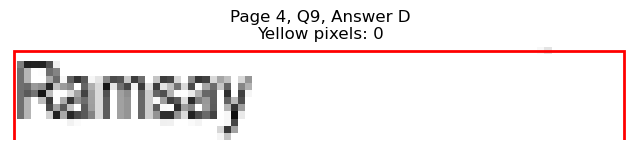

Page 4, Q9 - E: Detected box: x0=334.1, y0=665.7, x1=360.8, y1=678.4
Page 4, Q9, E: Yellow pixels: 0
Page 4, Q9, E: Total non-white pixels: 149
Page 4, Q9, E: Yellow percentage: 0.0%


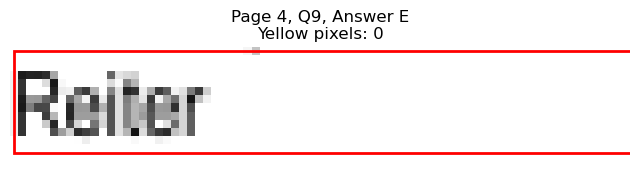


Page 4, Q9 - Selected Answer: B (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=82.5, y0=716.3, x1=123.1, y1=728.9
Page 4, Q10, A: Yellow pixels: 1035
Page 4, Q10, A: Total non-white pixels: 1196
Page 4, Q10, A: Yellow percentage: 86.5%


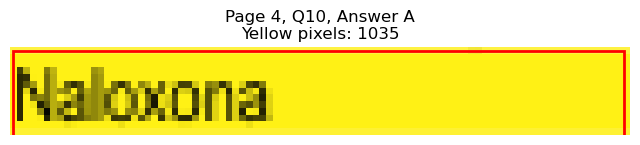

Page 4, Q10 - B: Detected box: x0=82.5, y0=728.9, x1=145.8, y1=741.5
Page 4, Q10, B: Yellow pixels: 114
Page 4, Q10, B: Total non-white pixels: 429
Page 4, Q10, B: Yellow percentage: 26.6%


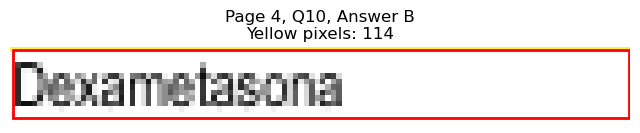

Page 4, Q10 - C: Detected box: x0=82.9, y0=741.4, x1=149.7, y1=754.1
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 354
Page 4, Q10, C: Yellow percentage: 0.0%


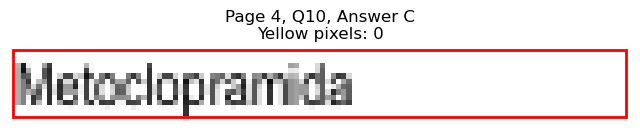

Page 4, Q10 - D: Detected box: x0=334.6, y0=716.3, x1=395.8, y1=728.9
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 319
Page 4, Q10, D: Yellow percentage: 0.0%


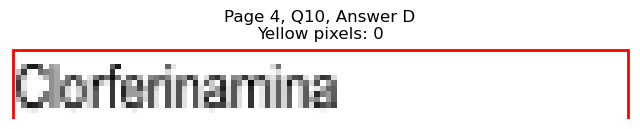

Page 4, Q10 - E: Detected box: x0=334.1, y0=728.9, x1=377.8, y1=741.5
Page 4, Q10, E: Yellow pixels: 0
Page 4, Q10, E: Total non-white pixels: 244
Page 4, Q10, E: Yellow percentage: 0.0%


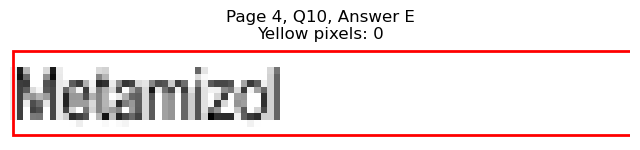


Page 4, Q10 - Selected Answer: A (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=101.5, y1=123.0
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 97
Page 5, Q1, A: Yellow percentage: 0.0%


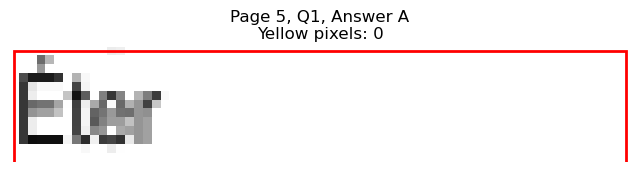

Page 5, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=121.1, y1=135.6
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 190
Page 5, Q1, B: Yellow percentage: 0.0%


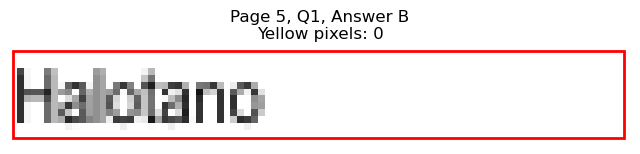

Page 5, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=125.1, y1=148.2
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 197
Page 5, Q1, C: Yellow percentage: 0.0%


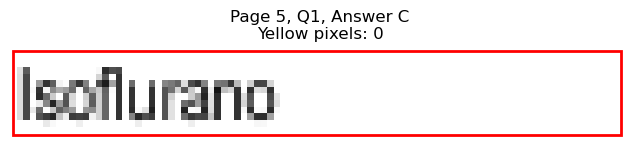

Page 5, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=375.3, y1=123.0
Page 5, Q1, D: Yellow pixels: 1037
Page 5, Q1, D: Total non-white pixels: 1196
Page 5, Q1, D: Yellow percentage: 86.7%


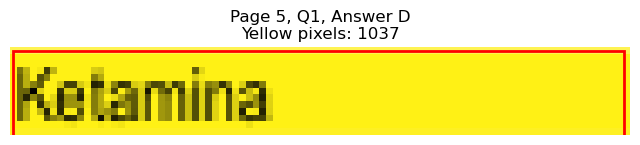

Page 5, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=380.3, y1=135.6
Page 5, Q1, E: Yellow pixels: 97
Page 5, Q1, E: Total non-white pixels: 334
Page 5, Q1, E: Yellow percentage: 29.0%


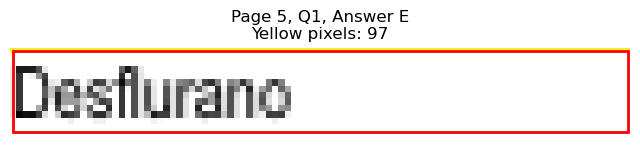


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=82.5, y0=173.4, x1=153.7, y1=186.1
Page 5, Q2, A: Yellow pixels: 1299
Page 5, Q2, A: Total non-white pixels: 1708
Page 5, Q2, A: Yellow percentage: 76.1%


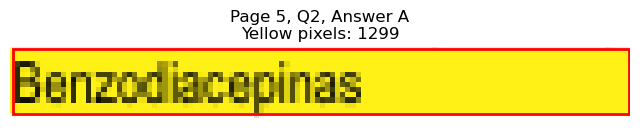

Page 5, Q2 - B: Detected box: x0=82.5, y0=186.0, x1=144.6, y1=198.7
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 422
Page 5, Q2, B: Yellow percentage: 0.0%


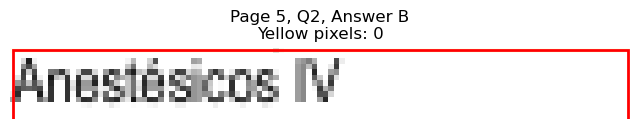

Page 5, Q2 - C: Detected box: x0=82.9, y0=198.6, x1=188.3, y1=211.3
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 562
Page 5, Q2, C: Yellow percentage: 0.0%


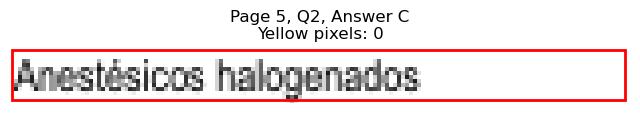

Page 5, Q2 - D: Detected box: x0=334.6, y0=173.4, x1=396.8, y1=186.1
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 325
Page 5, Q2, D: Yellow percentage: 0.0%


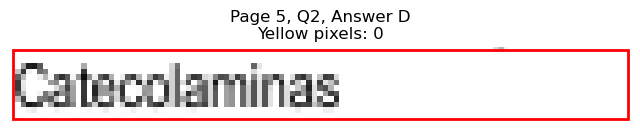

Page 5, Q2 - E: Detected box: x0=334.1, y0=186.0, x1=397.9, y1=198.7
Page 5, Q2, E: Yellow pixels: 0
Page 5, Q2, E: Total non-white pixels: 371
Page 5, Q2, E: Yellow percentage: 0.0%


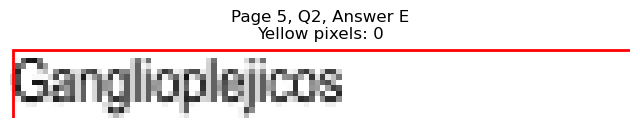


Page 5, Q2 - Selected Answer: A (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=82.5, y0=236.5, x1=219.9, y1=249.2
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 655
Page 5, Q3, A: Yellow percentage: 0.0%


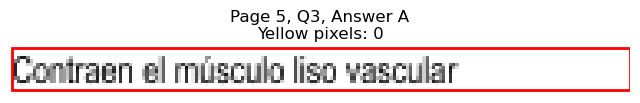

Page 5, Q3 - B: Detected box: x0=82.5, y0=249.1, x1=134.2, y1=261.8
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 414
Page 5, Q3, B: Yellow percentage: 0.0%


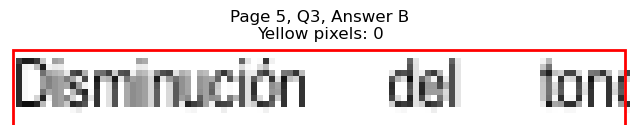

Page 5, Q3 - C: Detected box: x0=82.9, y0=274.5, x1=217.4, y1=287.1
Page 5, Q3, C: Yellow pixels: 1920
Page 5, Q3, C: Total non-white pixels: 2604
Page 5, Q3, C: Yellow percentage: 73.7%


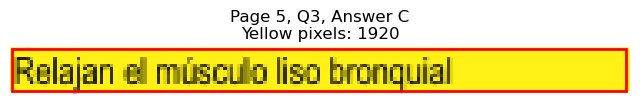

Page 5, Q3 - D: Detected box: x0=405.2, y0=236.5, x1=463.4, y1=249.2
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 472
Page 5, Q3, D: Yellow percentage: 0.0%


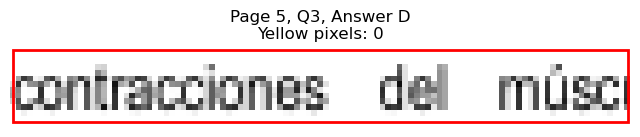

Page 5, Q3 - E: Detected box: x0=334.1, y0=261.7, x1=524.9, y1=274.4
Page 5, Q3, E: Yellow pixels: 0
Page 5, Q3, E: Total non-white pixels: 970
Page 5, Q3, E: Yellow percentage: 0.0%


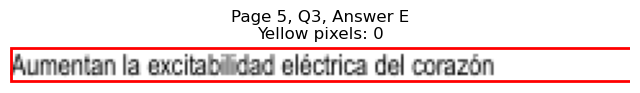


Page 5, Q3 - Selected Answer: C (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=82.5, y0=324.9, x1=121.1, y1=337.5
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 183
Page 5, Q4, A: Yellow percentage: 0.0%


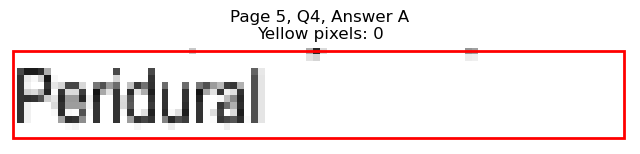

Page 5, Q4 - B: Detected box: x0=82.5, y0=337.5, x1=123.1, y1=350.1
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 195
Page 5, Q4, B: Yellow percentage: 0.0%


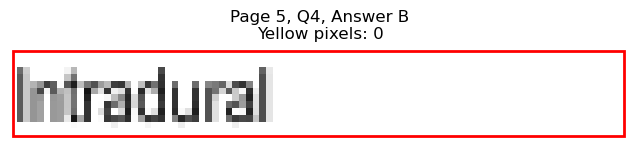

Page 5, Q4 - C: Detected box: x0=82.9, y0=350.2, x1=135.6, y1=362.9
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 269
Page 5, Q4, C: Yellow percentage: 0.0%


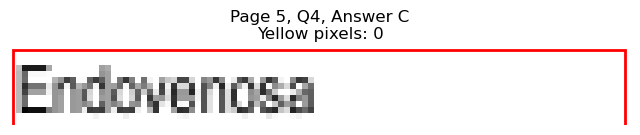

Page 5, Q4 - D: Detected box: x0=334.6, y0=324.9, x1=383.2, y1=337.5
Page 5, Q4, D: Yellow pixels: 100
Page 5, Q4, D: Total non-white pixels: 356
Page 5, Q4, D: Yellow percentage: 28.1%


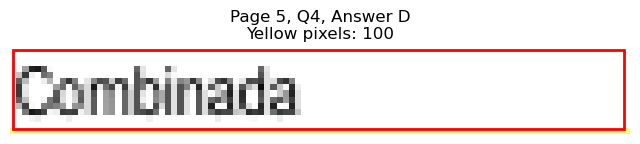

Page 5, Q4 - E: Detected box: x0=334.1, y0=337.5, x1=368.8, y1=350.1
Page 5, Q4, E: Yellow pixels: 962
Page 5, Q4, E: Total non-white pixels: 1190
Page 5, Q4, E: Yellow percentage: 80.8%


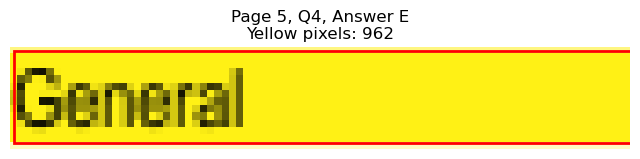


Page 5, Q4 - Selected Answer: E (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=82.5, y0=400.6, x1=123.1, y1=413.3
Page 5, Q5, A: Yellow pixels: 943
Page 5, Q5, A: Total non-white pixels: 1288
Page 5, Q5, A: Yellow percentage: 73.2%


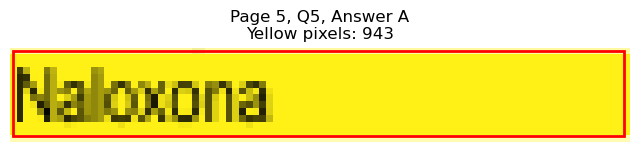

Page 5, Q5 - B: Detected box: x0=82.5, y0=413.3, x1=123.1, y1=426.0
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 289
Page 5, Q5, B: Yellow percentage: 0.0%


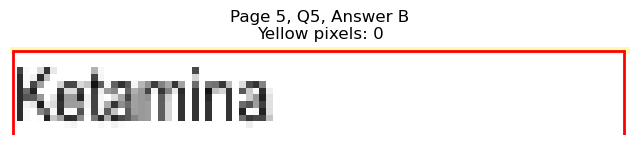

Page 5, Q5 - C: Detected box: x0=82.9, y0=425.9, x1=135.6, y1=438.6
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 283
Page 5, Q5, C: Yellow percentage: 0.0%


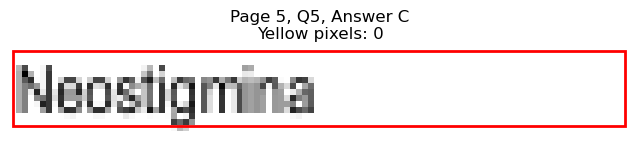

Page 5, Q5 - D: Detected box: x0=334.6, y0=400.6, x1=381.8, y1=413.3
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 253
Page 5, Q5, D: Yellow percentage: 0.0%


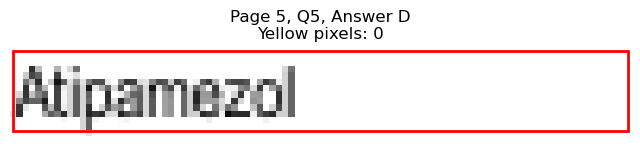

Page 5, Q5 - E: Detected box: x0=334.1, y0=413.3, x1=380.2, y1=426.0
Page 5, Q5, E: Yellow pixels: 0
Page 5, Q5, E: Total non-white pixels: 257
Page 5, Q5, E: Yellow percentage: 0.0%


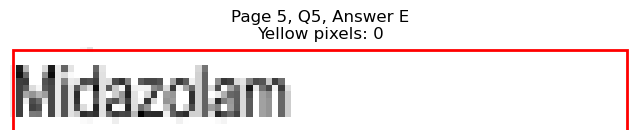


Page 5, Q5 - Selected Answer: A (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=70.8, y0=463.7, x1=79.3, y1=476.4
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 67
Page 5, Q6, A: Yellow percentage: 0.0%


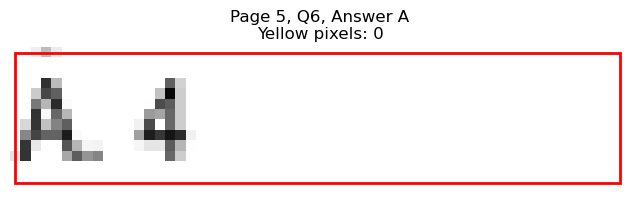

Page 5, Q6 - B: Detected box: x0=70.8, y0=476.3, x1=79.3, y1=489.0
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 79
Page 5, Q6, B: Yellow percentage: 0.0%


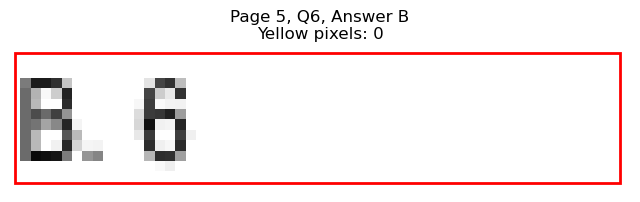

Page 5, Q6 - C: Detected box: x0=82.9, y0=489.1, x1=95.5, y1=501.7
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 44
Page 5, Q6, C: Yellow percentage: 0.0%


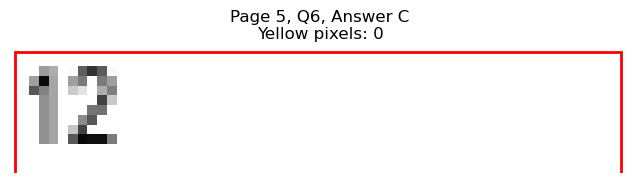

Page 5, Q6 - D: Detected box: x0=322.5, y0=463.7, x1=331.5, y1=476.4
Page 5, Q6, D: Yellow pixels: 669
Page 5, Q6, D: Total non-white pixels: 840
Page 5, Q6, D: Yellow percentage: 79.6%


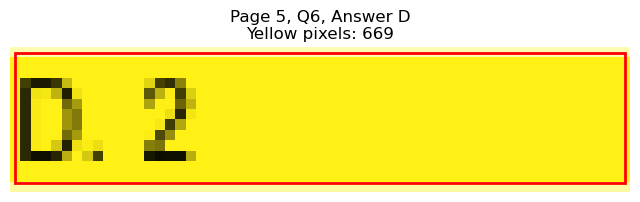

Page 5, Q6 - E: Detected box: x0=334.1, y0=476.3, x1=346.7, y1=489.0
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 114
Page 5, Q6, E: Yellow percentage: 0.0%


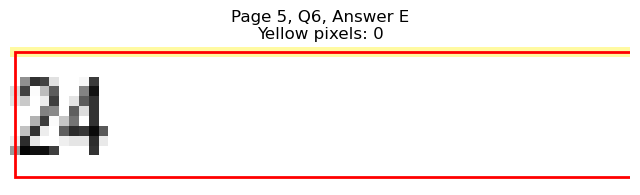


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=82.5, y0=539.5, x1=122.1, y1=552.1
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 191
Page 5, Q7, A: Yellow percentage: 0.0%


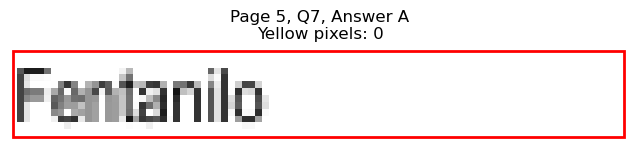

Page 5, Q7 - B: Detected box: x0=82.5, y0=552.2, x1=115.1, y1=564.8
Page 5, Q7, B: Yellow pixels: 957
Page 5, Q7, B: Total non-white pixels: 1092
Page 5, Q7, B: Yellow percentage: 87.6%


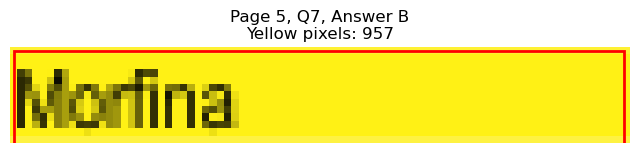

Page 5, Q7 - C: Detected box: x0=82.9, y0=564.8, x1=140.7, y1=577.4
Page 5, Q7, C: Yellow pixels: 109
Page 5, Q7, C: Total non-white pixels: 420
Page 5, Q7, C: Yellow percentage: 26.0%


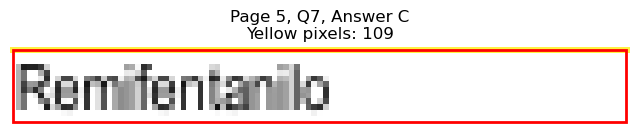

Page 5, Q7 - D: Detected box: x0=334.6, y0=539.5, x1=381.8, y1=552.1
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 268
Page 5, Q7, D: Yellow percentage: 0.0%


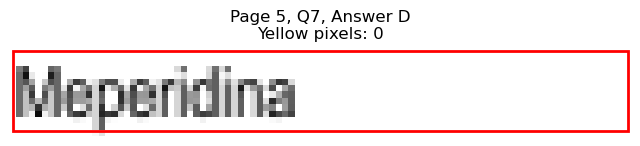

Page 5, Q7 - E: Detected box: x0=334.1, y0=552.2, x1=383.8, y1=564.8
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 274
Page 5, Q7, E: Yellow percentage: 0.0%


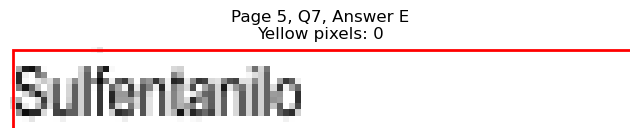


Page 5, Q7 - Selected Answer: B (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=82.5, y0=602.6, x1=123.6, y1=615.2
Page 5, Q8, A: Yellow pixels: 1040
Page 5, Q8, A: Total non-white pixels: 1288
Page 5, Q8, A: Yellow percentage: 80.7%


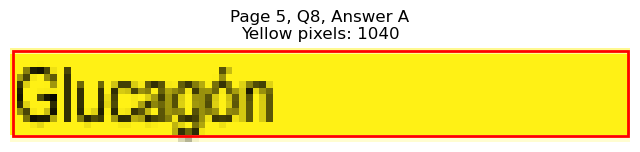

Page 5, Q8 - B: Detected box: x0=82.5, y0=615.2, x1=119.1, y1=627.8
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 265
Page 5, Q8, B: Yellow percentage: 0.0%


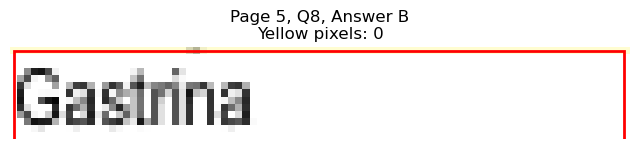

Page 5, Q8 - C: Detected box: x0=82.9, y0=627.9, x1=133.6, y1=640.6
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 250
Page 5, Q8, C: Yellow percentage: 0.0%


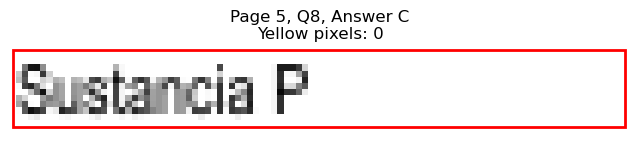

Page 5, Q8 - D: Detected box: x0=334.6, y0=602.6, x1=368.2, y1=615.2
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 185
Page 5, Q8, D: Yellow percentage: 0.0%


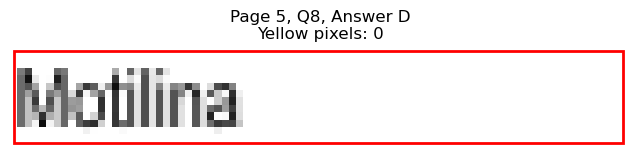

Page 5, Q8 - E: Detected box: x0=334.1, y0=615.2, x1=381.8, y1=627.8
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 256
Page 5, Q8, E: Yellow percentage: 0.0%


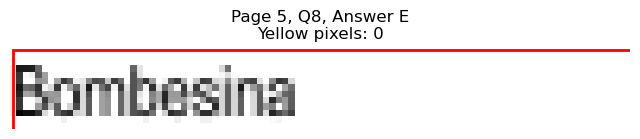


Page 5, Q8 - Selected Answer: A (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=82.5, y0=678.3, x1=121.1, y1=691.0
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 193
Page 5, Q9, A: Yellow percentage: 0.0%


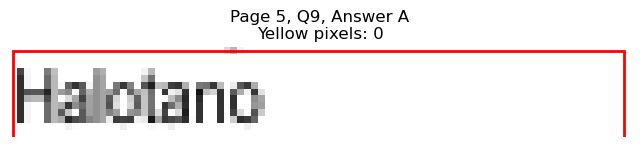

Page 5, Q9 - B: Detected box: x0=82.5, y0=691.1, x1=138.1, y1=703.7
Page 5, Q9, B: Yellow pixels: 1176
Page 5, Q9, B: Total non-white pixels: 1391
Page 5, Q9, B: Yellow percentage: 84.5%


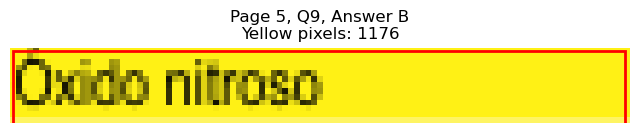

Page 5, Q9 - C: Detected box: x0=82.9, y0=703.7, x1=122.5, y1=716.3
Page 5, Q9, C: Yellow pixels: 91
Page 5, Q9, C: Total non-white pixels: 295
Page 5, Q9, C: Yellow percentage: 30.8%


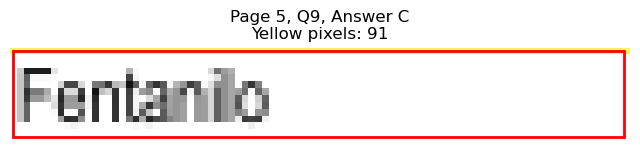

Page 5, Q9 - D: Detected box: x0=334.6, y0=678.3, x1=390.3, y1=691.0
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 287
Page 5, Q9, D: Yellow percentage: 0.0%


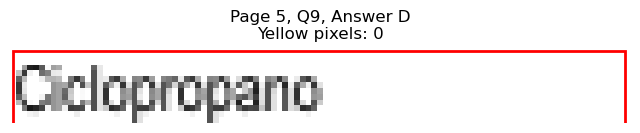

Page 5, Q9 - E: Detected box: x0=334.1, y0=691.1, x1=396.3, y1=703.7
Page 5, Q9, E: Yellow pixels: 0
Page 5, Q9, E: Total non-white pixels: 317
Page 5, Q9, E: Yellow percentage: 0.0%


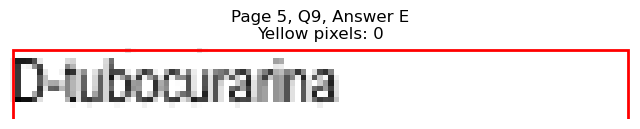


Page 5, Q9 - Selected Answer: B (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=82.5, y0=741.4, x1=120.6, y1=754.1
Page 5, Q10, A: Yellow pixels: 89
Page 5, Q10, A: Total non-white pixels: 273
Page 5, Q10, A: Yellow percentage: 32.6%


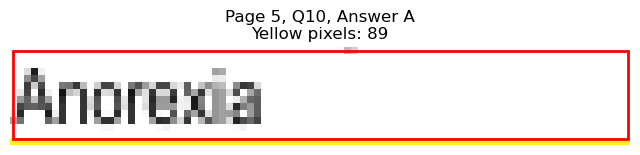

Page 5, Q10 - B: Detected box: x0=82.5, y0=754.0, x1=122.5, y1=766.7
Page 5, Q10, B: Yellow pixels: 1021
Page 5, Q10, B: Total non-white pixels: 1183
Page 5, Q10, B: Yellow percentage: 86.3%


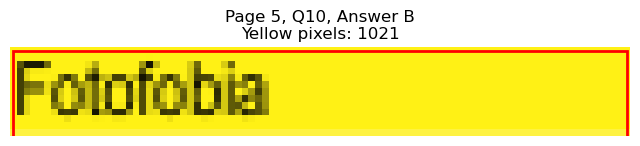

Page 5, Q10 - C: Detected box: x0=82.9, y0=766.8, x1=126.0, y1=779.4
Page 5, Q10, C: Yellow pixels: 95
Page 5, Q10, C: Total non-white pixels: 324
Page 5, Q10, C: Yellow percentage: 29.3%


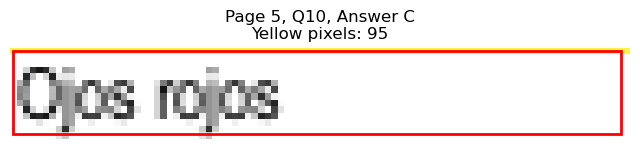

Page 5, Q10 - D: Detected box: x0=334.6, y0=741.4, x1=413.0, y1=754.1
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 394
Page 5, Q10, D: Yellow percentage: 0.0%


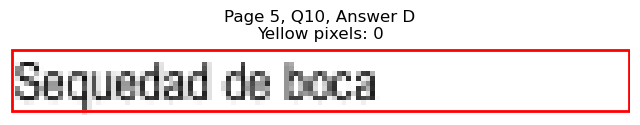

Page 5, Q10 - E: Detected box: x0=334.1, y0=754.0, x1=349.2, y1=766.7
Page 5, Q10, E: Yellow pixels: 0
Page 5, Q10, E: Total non-white pixels: 71
Page 5, Q10, E: Yellow percentage: 0.0%


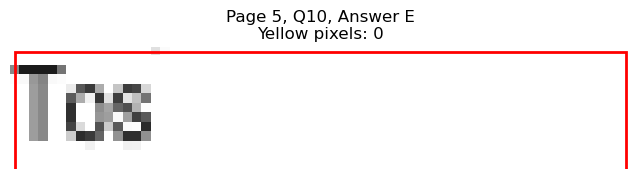


Page 5, Q10 - Selected Answer: B (based on yellow pixel count)





Page 6: Found 11 questions
Page 6, Q1 - A: Detected box: x0=70.8, y0=110.3, x1=79.3, y1=123.0
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 51
Page 6, Q1, A: Yellow percentage: 0.0%


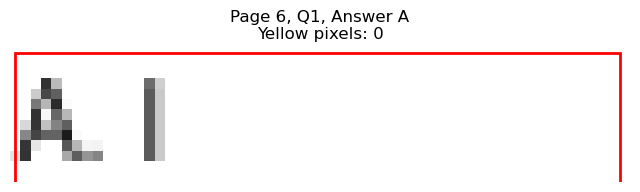

Page 6, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=92.5, y1=135.6
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 48
Page 6, Q1, B: Yellow percentage: 0.0%


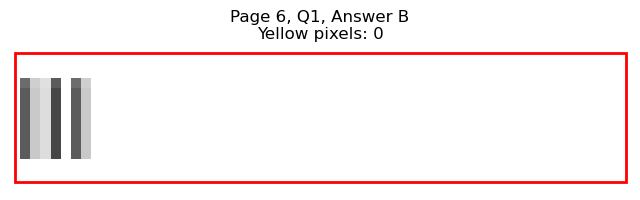

Page 6, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=94.0, y1=148.2
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 45
Page 6, Q1, C: Yellow percentage: 0.0%


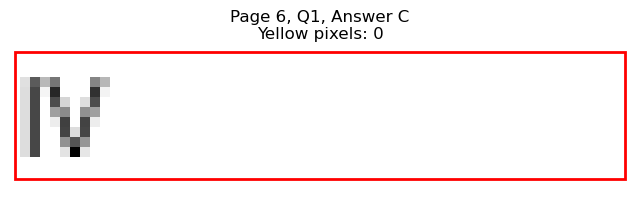

Page 6, Q1 - D: Detected box: x0=322.5, y0=110.3, x1=331.5, y1=123.0
Page 6, Q1, D: Yellow pixels: 726
Page 6, Q1, D: Total non-white pixels: 780
Page 6, Q1, D: Yellow percentage: 93.1%


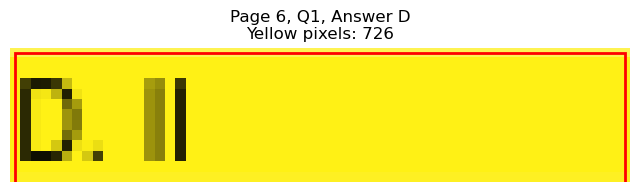

Page 6, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=342.7, y1=135.6
Page 6, Q1, E: Yellow pixels: 59
Page 6, Q1, E: Total non-white pixels: 87
Page 6, Q1, E: Yellow percentage: 67.8%


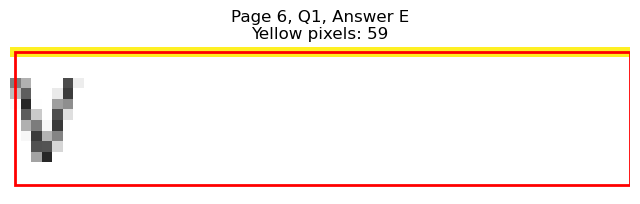


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=82.5, y0=173.4, x1=123.1, y1=186.1
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 209
Page 6, Q2, A: Yellow percentage: 0.0%


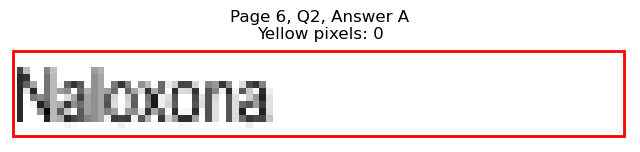

Page 6, Q2 - B: Detected box: x0=82.5, y0=186.0, x1=124.6, y1=198.7
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 294
Page 6, Q2, B: Yellow percentage: 0.0%


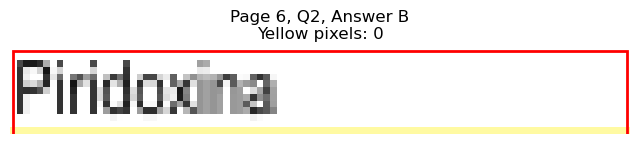

Page 6, Q2 - C: Detected box: x0=82.9, y0=198.6, x1=135.6, y1=211.3
Page 6, Q2, C: Yellow pixels: 1026
Page 6, Q2, C: Total non-white pixels: 1456
Page 6, Q2, C: Yellow percentage: 70.5%


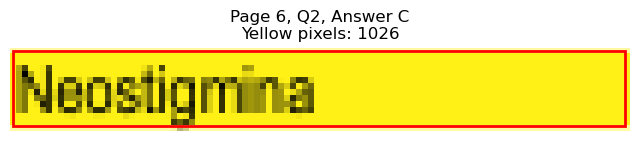

Page 6, Q2 - D: Detected box: x0=334.6, y0=173.4, x1=398.0, y1=186.1
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 315
Page 6, Q2, D: Yellow percentage: 0.0%


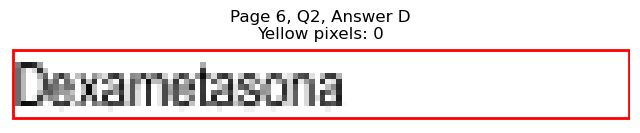

Page 6, Q2 - E: Detected box: x0=334.1, y0=186.0, x1=370.3, y1=198.7
Page 6, Q2, E: Yellow pixels: 0
Page 6, Q2, E: Total non-white pixels: 182
Page 6, Q2, E: Yellow percentage: 0.0%


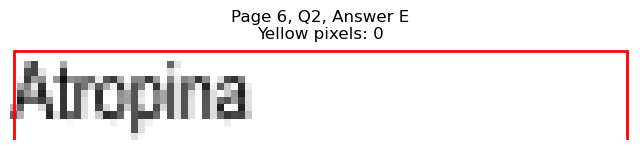


Page 6, Q2 - Selected Answer: C (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=82.5, y0=236.5, x1=123.1, y1=249.2
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 202
Page 6, Q3, A: Yellow percentage: 0.0%


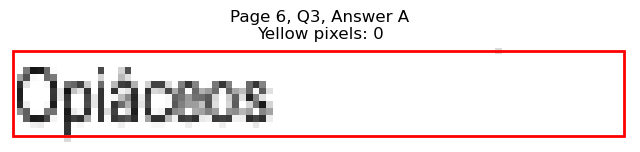

Page 6, Q3 - B: Detected box: x0=82.5, y0=249.1, x1=126.1, y1=261.8
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 210
Page 6, Q3, B: Yellow percentage: 0.0%


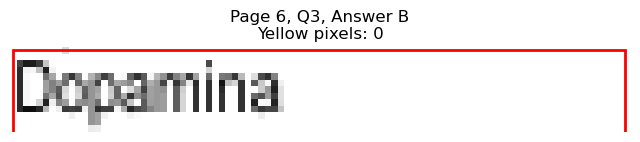

Page 6, Q3 - C: Detected box: x0=82.9, y0=261.7, x1=184.3, y1=274.4
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 524
Page 6, Q3, C: Yellow percentage: 0.0%


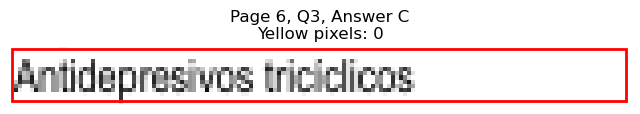

Page 6, Q3 - D: Detected box: x0=334.6, y0=236.5, x1=358.7, y1=249.2
Page 6, Q3, D: Yellow pixels: 875
Page 6, Q3, D: Total non-white pixels: 1050
Page 6, Q3, D: Yellow percentage: 83.3%


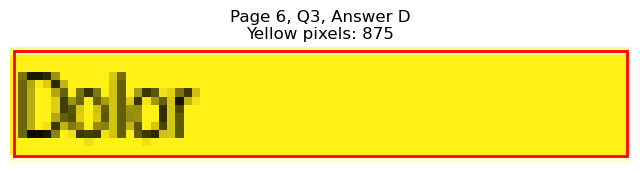

Page 6, Q3 - E: Detected box: x0=334.1, y0=249.1, x1=377.8, y1=261.8
Page 6, Q3, E: Yellow pixels: 0
Page 6, Q3, E: Total non-white pixels: 312
Page 6, Q3, E: Yellow percentage: 0.0%


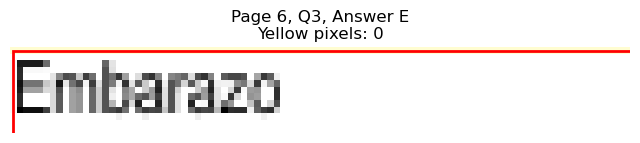


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=82.5, y0=299.7, x1=184.8, y1=312.3
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 530
Page 6, Q4, A: Yellow percentage: 0.0%


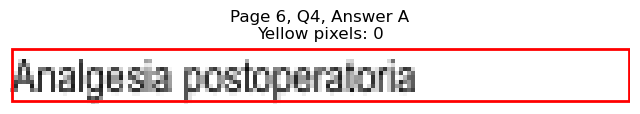

Page 6, Q4 - B: Detected box: x0=82.5, y0=312.3, x1=153.3, y1=324.9
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 380
Page 6, Q4, B: Yellow percentage: 0.0%


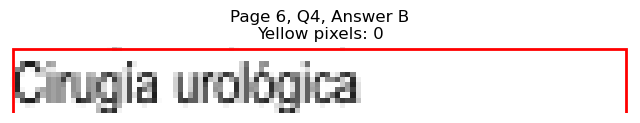

Page 6, Q4 - C: Detected box: x0=82.9, y0=324.9, x1=150.6, y1=337.5
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 340
Page 6, Q4, C: Yellow percentage: 0.0%


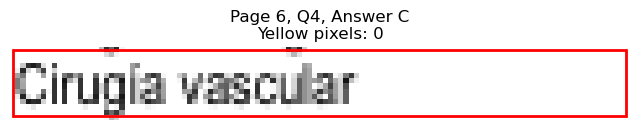

Page 6, Q4 - D: Detected box: x0=334.6, y0=299.7, x1=451.0, y1=312.3
Page 6, Q4, D: Yellow pixels: 1578
Page 6, Q4, D: Total non-white pixels: 2352
Page 6, Q4, D: Yellow percentage: 67.1%


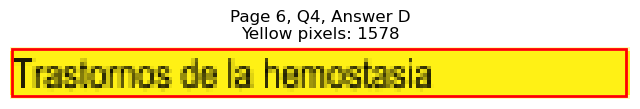

Page 6, Q4 - E: Detected box: x0=334.1, y0=312.3, x1=435.5, y1=324.9
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 689
Page 6, Q4, E: Yellow percentage: 0.0%


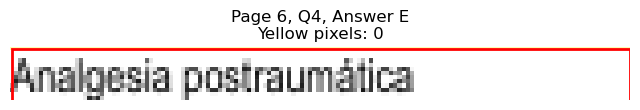


Page 6, Q4 - Selected Answer: D (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=82.5, y0=362.8, x1=149.2, y1=375.5
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 374
Page 6, Q5, A: Yellow percentage: 0.0%


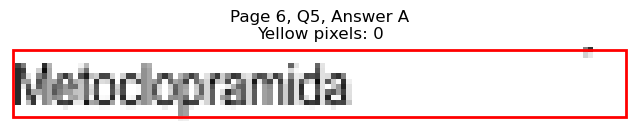

Page 6, Q5 - B: Detected box: x0=82.5, y0=375.4, x1=159.7, y1=388.1
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 401
Page 6, Q5, B: Yellow percentage: 0.0%


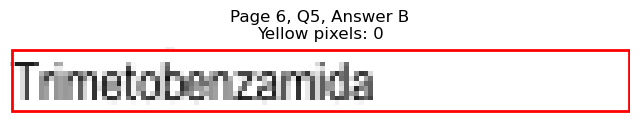

Page 6, Q5 - C: Detected box: x0=82.9, y0=388.0, x1=123.6, y1=400.7
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 217
Page 6, Q5, C: Yellow percentage: 0.0%


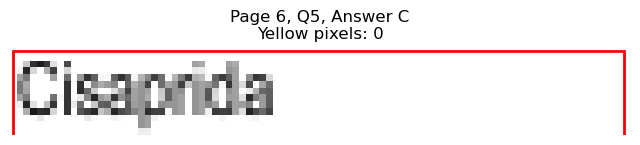

Page 6, Q5 - D: Detected box: x0=334.6, y0=173.4, x1=398.0, y1=186.1
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 315
Page 6, Q5, D: Yellow percentage: 0.0%


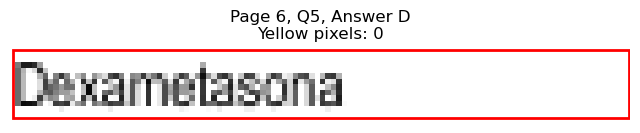

Page 6, Q5 - E: Detected box: x0=334.1, y0=375.4, x1=383.8, y1=388.1
Page 6, Q5, E: Yellow pixels: 1098
Page 6, Q5, E: Total non-white pixels: 1400
Page 6, Q5, E: Yellow percentage: 78.4%


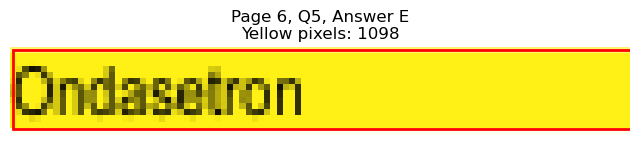


Page 6, Q5 - Selected Answer: E (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=82.5, y0=425.9, x1=139.1, y1=438.6
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 280
Page 6, Q6, A: Yellow percentage: 0.0%


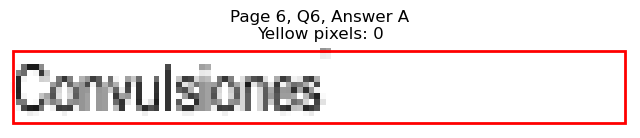

Page 6, Q6 - B: Detected box: x0=82.5, y0=438.5, x1=173.8, y1=451.2
Page 6, Q6, B: Yellow pixels: 142
Page 6, Q6, B: Total non-white pixels: 609
Page 6, Q6, B: Yellow percentage: 23.3%


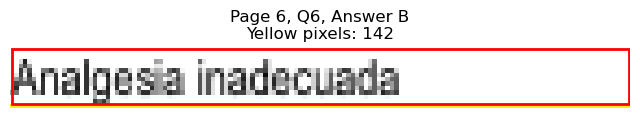

Page 6, Q6 - C: Detected box: x0=82.9, y0=451.1, x1=256.0, y1=463.8
Page 6, Q6, C: Yellow pixels: 1819
Page 6, Q6, C: Total non-white pixels: 2509
Page 6, Q6, C: Yellow percentage: 72.5%


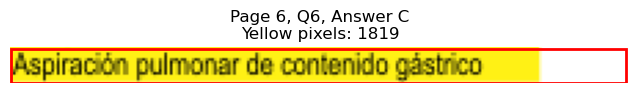

Page 6, Q6 - D: Detected box: x0=334.6, y0=425.9, x1=368.2, y1=438.6
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 182
Page 6, Q6, D: Yellow percentage: 0.0%


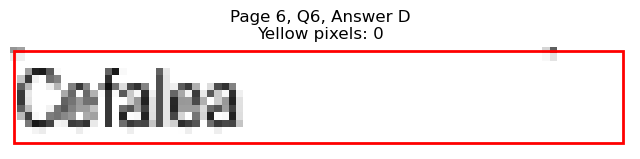

Page 6, Q6 - E: Detected box: x0=334.1, y0=438.5, x1=409.9, y1=451.2
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 376
Page 6, Q6, E: Yellow percentage: 0.0%


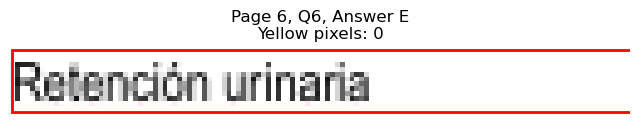


Page 6, Q6 - Selected Answer: C (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=82.5, y0=489.1, x1=125.5, y1=501.7
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 223
Page 6, Q7, A: Yellow percentage: 0.0%


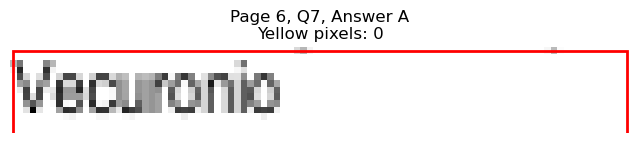

Page 6, Q7 - B: Detected box: x0=82.5, y0=501.7, x1=126.1, y1=514.3
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 197
Page 6, Q7, B: Yellow percentage: 0.0%


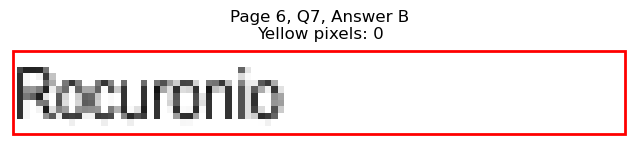

Page 6, Q7 - C: Detected box: x0=82.9, y0=514.3, x1=138.6, y1=526.9
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 289
Page 6, Q7, C: Yellow percentage: 0.0%


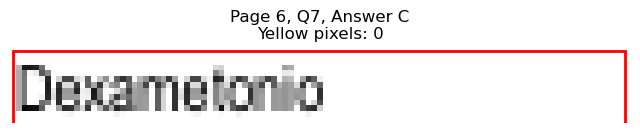

Page 6, Q7 - D: Detected box: x0=334.6, y0=489.1, x1=368.2, y1=501.7
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 267
Page 6, Q7, D: Yellow percentage: 0.0%


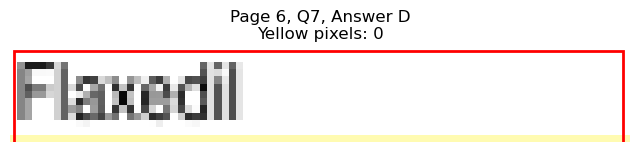

Page 6, Q7 - E: Detected box: x0=334.1, y0=501.7, x1=391.3, y1=514.3
Page 6, Q7, E: Yellow pixels: 1074
Page 6, Q7, E: Total non-white pixels: 1512
Page 6, Q7, E: Yellow percentage: 71.0%


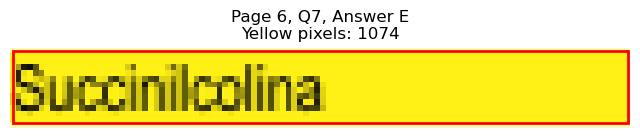


Page 6, Q7 - Selected Answer: E (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=82.5, y0=552.2, x1=118.6, y1=564.8
Page 6, Q8, A: Yellow pixels: 1000
Page 6, Q8, A: Total non-white pixels: 1131
Page 6, Q8, A: Yellow percentage: 88.4%


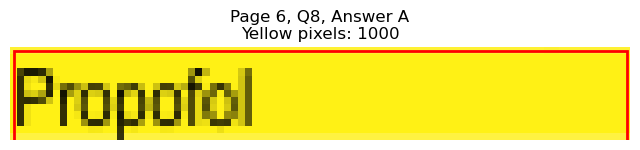

Page 6, Q8 - B: Detected box: x0=82.5, y0=564.8, x1=125.5, y1=577.4
Page 6, Q8, B: Yellow pixels: 93
Page 6, Q8, B: Total non-white pixels: 311
Page 6, Q8, B: Yellow percentage: 29.9%


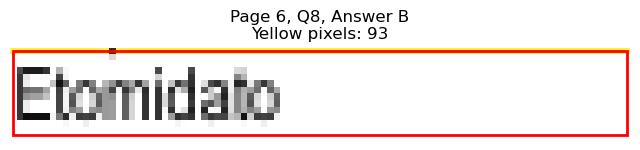

Page 6, Q8 - C: Detected box: x0=82.9, y0=577.4, x1=133.6, y1=590.0
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 263
Page 6, Q8, C: Yellow percentage: 0.0%


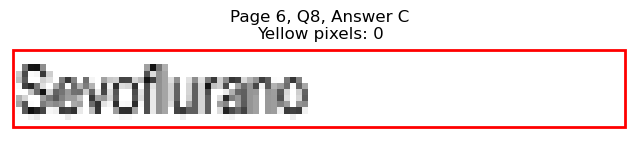

Page 6, Q8 - D: Detected box: x0=334.6, y0=552.2, x1=374.2, y1=564.8
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 205
Page 6, Q8, D: Yellow percentage: 0.0%


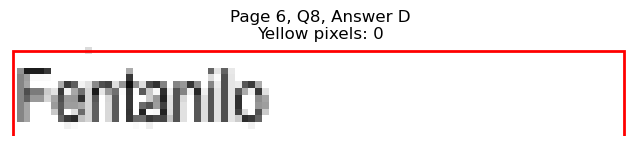

Page 6, Q8 - E: Detected box: x0=334.1, y0=564.8, x1=380.2, y1=577.4
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 255
Page 6, Q8, E: Yellow percentage: 0.0%


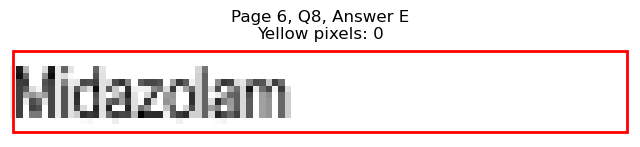


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=82.5, y0=615.2, x1=128.1, y1=627.8
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 214
Page 6, Q9, A: Yellow percentage: 0.0%


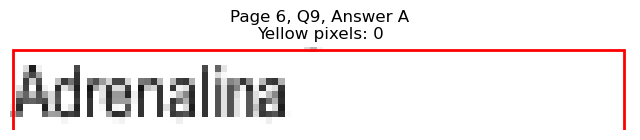

Page 6, Q9 - B: Detected box: x0=82.5, y0=627.9, x1=141.6, y1=640.6
Page 6, Q9, B: Yellow pixels: 110
Page 6, Q9, B: Total non-white pixels: 427
Page 6, Q9, B: Yellow percentage: 25.8%


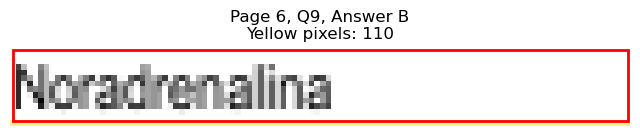

Page 6, Q9 - C: Detected box: x0=82.9, y0=640.5, x1=129.1, y1=653.2
Page 6, Q9, C: Yellow pixels: 1095
Page 6, Q9, C: Total non-white pixels: 1372
Page 6, Q9, C: Yellow percentage: 79.8%


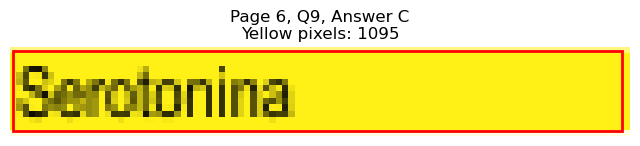

Page 6, Q9 - D: Detected box: x0=334.6, y0=615.2, x1=389.5, y1=627.8
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 293
Page 6, Q9, D: Yellow percentage: 0.0%


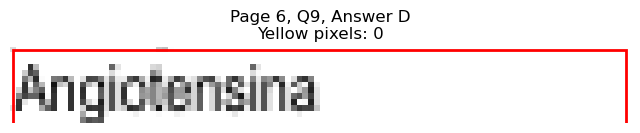

Page 6, Q9 - E: Detected box: x0=334.1, y0=627.9, x1=386.8, y1=640.6
Page 6, Q9, E: Yellow pixels: 0
Page 6, Q9, E: Total non-white pixels: 279
Page 6, Q9, E: Yellow percentage: 0.0%


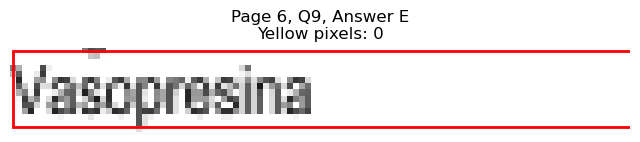


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=82.5, y0=678.3, x1=96.0, y1=691.0
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 49
Page 6, Q10, A: Yellow percentage: 0.0%


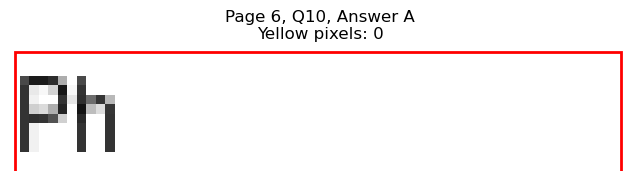

Page 6, Q10 - B: Detected box: x0=82.5, y0=691.1, x1=102.0, y1=703.7
Page 6, Q10, B: Yellow pixels: 859
Page 6, Q10, B: Total non-white pixels: 923
Page 6, Q10, B: Yellow percentage: 93.1%


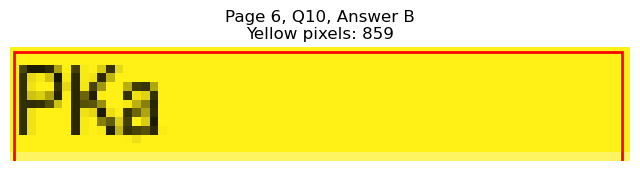

Page 6, Q10 - C: Detected box: x0=82.9, y0=703.7, x1=164.2, y1=716.3
Page 6, Q10, C: Yellow pixels: 133
Page 6, Q10, C: Total non-white pixels: 538
Page 6, Q10, C: Yellow percentage: 24.7%


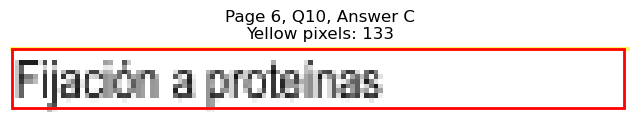

Page 6, Q10 - D: Detected box: x0=334.6, y0=678.3, x1=417.9, y1=691.0
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 411
Page 6, Q10, D: Yellow percentage: 0.0%


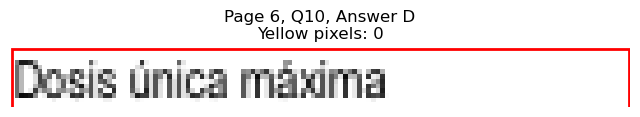

Page 6, Q10 - E: Detected box: x0=334.1, y0=691.1, x1=396.3, y1=703.7
Page 6, Q10, E: Yellow pixels: 0
Page 6, Q10, E: Total non-white pixels: 349
Page 6, Q10, E: Yellow percentage: 0.0%


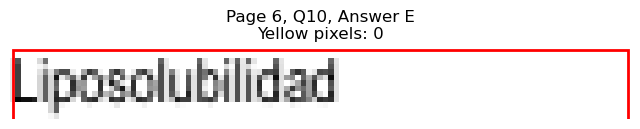


Page 6, Q10 - Selected Answer: B (based on yellow pixel count)




Page 6, Q11 - A: Detected box: x0=82.5, y0=741.4, x1=125.1, y1=754.1
Page 6, Q11, A: Yellow pixels: 0
Page 6, Q11, A: Total non-white pixels: 186
Page 6, Q11, A: Yellow percentage: 0.0%


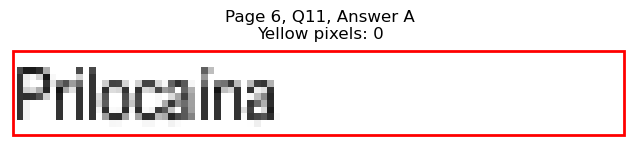

Page 6, Q11 - B: Detected box: x0=82.5, y0=754.0, x1=124.1, y1=766.7
Page 6, Q11, B: Yellow pixels: 0
Page 6, Q11, B: Total non-white pixels: 183
Page 6, Q11, B: Yellow percentage: 0.0%


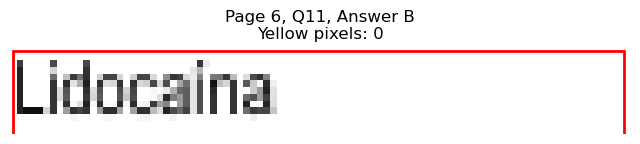

Page 6, Q11 - C: Detected box: x0=82.9, y0=766.8, x1=128.1, y1=779.4
Page 6, Q11, C: Yellow pixels: 0
Page 6, Q11, C: Total non-white pixels: 215
Page 6, Q11, C: Yellow percentage: 0.0%


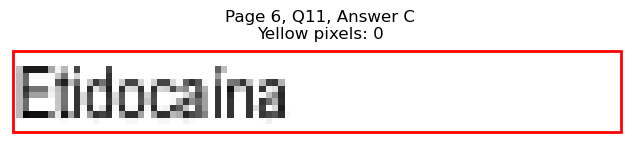

Page 6, Q11 - D: Detected box: x0=334.6, y0=741.4, x1=386.8, y1=754.1
Page 6, Q11, D: Yellow pixels: 103
Page 6, Q11, D: Total non-white pixels: 371
Page 6, Q11, D: Yellow percentage: 27.8%


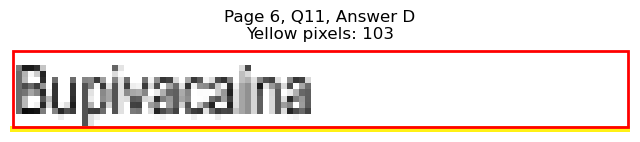

Page 6, Q11 - E: Detected box: x0=334.1, y0=754.0, x1=393.3, y1=766.7
Page 6, Q11, E: Yellow pixels: 1211
Page 6, Q11, E: Total non-white pixels: 1430
Page 6, Q11, E: Yellow percentage: 84.7%


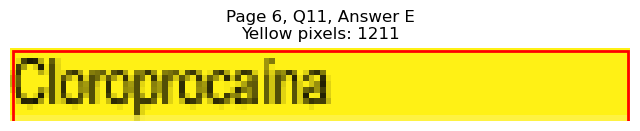


Page 6, Q11 - Selected Answer: E (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=275.2, y1=110.4
Page 7, Q1, A: Yellow pixels: 5
Page 7, Q1, A: Total non-white pixels: 918
Page 7, Q1, A: Yellow percentage: 0.5%


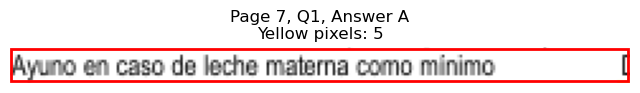

Page 7, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=199.4, y1=135.6
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 572
Page 7, Q1, B: Yellow percentage: 0.0%


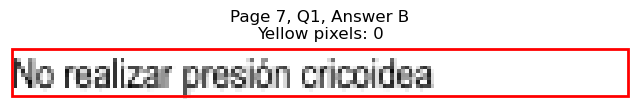

Page 7, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=243.0, y1=148.2
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 801
Page 7, Q1, C: Yellow percentage: 0.0%


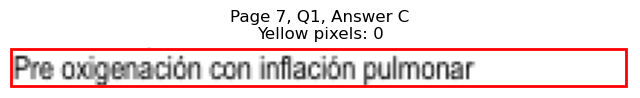

Page 7, Q1 - D: Detected box: x0=334.6, y0=97.7, x1=461.0, y1=110.4
Page 7, Q1, D: Yellow pixels: 177
Page 7, Q1, D: Total non-white pixels: 815
Page 7, Q1, D: Yellow percentage: 21.7%


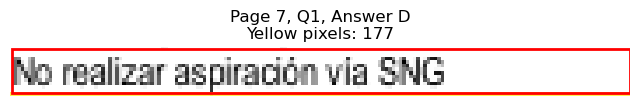

Page 7, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=409.9, y1=123.0
Page 7, Q1, E: Yellow pixels: 1344
Page 7, Q1, E: Total non-white pixels: 1638
Page 7, Q1, E: Yellow percentage: 82.1%


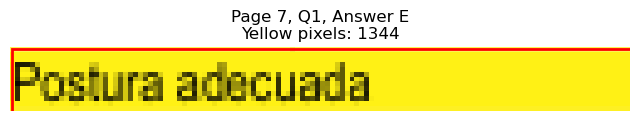


Page 7, Q1 - Selected Answer: E (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=82.5, y0=173.4, x1=139.6, y1=186.1
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 271
Page 7, Q2, A: Yellow percentage: 0.0%


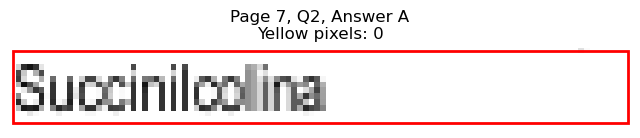

Page 7, Q2 - B: Detected box: x0=82.5, y0=186.0, x1=123.1, y1=198.7
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 197
Page 7, Q2, B: Yellow percentage: 0.0%


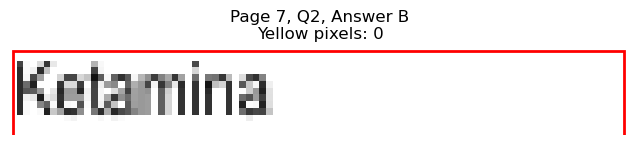

Page 7, Q2 - C: Detected box: x0=82.9, y0=198.6, x1=130.6, y1=211.3
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 243
Page 7, Q2, C: Yellow percentage: 0.0%


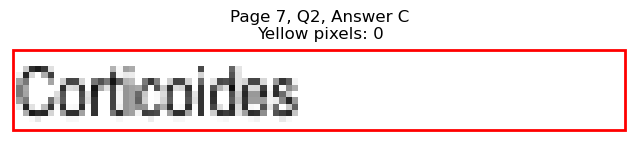

Page 7, Q2 - D: Detected box: x0=334.6, y0=173.4, x1=387.3, y1=186.1
Page 7, Q2, D: Yellow pixels: 104
Page 7, Q2, D: Total non-white pixels: 400
Page 7, Q2, D: Yellow percentage: 26.0%


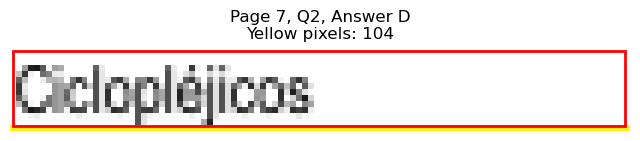

Page 7, Q2 - E: Detected box: x0=334.1, y0=186.0, x1=506.1, y1=198.7
Page 7, Q2, E: Yellow pixels: 1801
Page 7, Q2, E: Total non-white pixels: 2496
Page 7, Q2, E: Yellow percentage: 72.2%


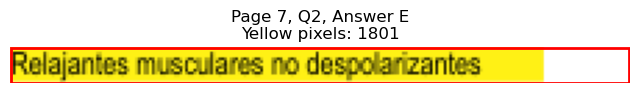


Page 7, Q2 - Selected Answer: E (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=82.5, y0=249.1, x1=249.0, y1=261.8
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 799
Page 7, Q3, A: Yellow percentage: 0.0%


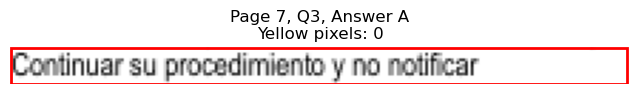

Page 7, Q3 - B: Detected box: x0=82.5, y0=261.7, x1=275.2, y1=274.4
Page 7, Q3, B: Yellow pixels: 70
Page 7, Q3, B: Total non-white pixels: 946
Page 7, Q3, B: Yellow percentage: 7.4%


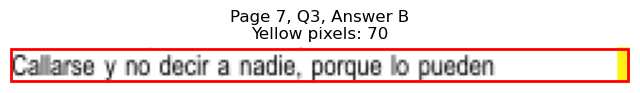

Page 7, Q3 - C: Detected box: x0=82.9, y0=287.1, x1=210.4, y1=299.7
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 634
Page 7, Q3, C: Yellow percentage: 0.0%


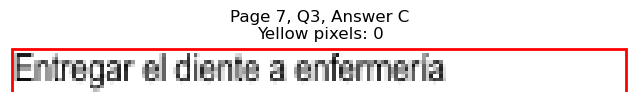

Page 7, Q3 - D: Detected box: x0=460.7, y0=249.1, x1=497.8, y1=261.8
Page 7, Q3, D: Yellow pixels: 642
Page 7, Q3, D: Total non-white pixels: 858
Page 7, Q3, D: Yellow percentage: 74.8%


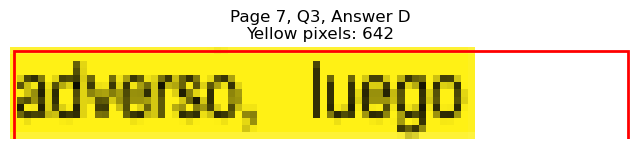

Page 7, Q3 - E: Detected box: x0=334.1, y0=287.1, x1=503.1, y1=299.7
Page 7, Q3, E: Yellow pixels: 0
Page 7, Q3, E: Total non-white pixels: 1049
Page 7, Q3, E: Yellow percentage: 0.0%


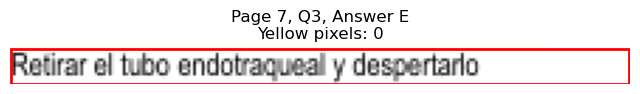


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=82.5, y0=337.5, x1=145.7, y1=350.1
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 310
Page 7, Q4, A: Yellow percentage: 0.0%


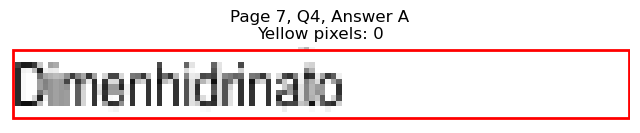

Page 7, Q4 - B: Detected box: x0=82.5, y0=350.2, x1=141.6, y1=362.9
Page 7, Q4, B: Yellow pixels: 1203
Page 7, Q4, B: Total non-white pixels: 1430
Page 7, Q4, B: Yellow percentage: 84.1%


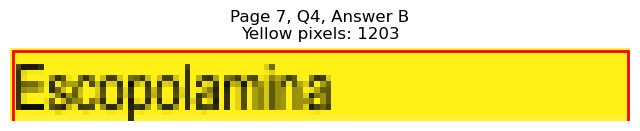

Page 7, Q4 - C: Detected box: x0=82.9, y0=362.8, x1=146.2, y1=375.5
Page 7, Q4, C: Yellow pixels: 114
Page 7, Q4, C: Total non-white pixels: 446
Page 7, Q4, C: Yellow percentage: 25.6%


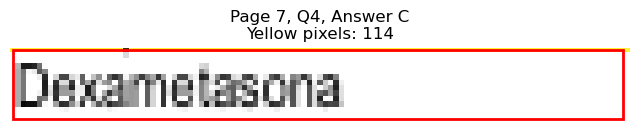

Page 7, Q4 - D: Detected box: x0=334.6, y0=337.5, x1=384.3, y1=350.1
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 254
Page 7, Q4, D: Yellow percentage: 0.0%


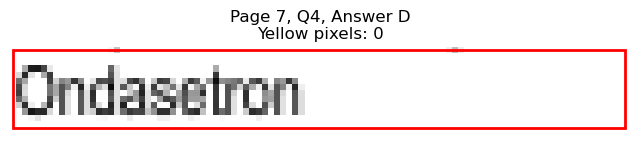

Page 7, Q4 - E: Detected box: x0=334.1, y0=350.2, x1=382.3, y1=362.9
Page 7, Q4, E: Yellow pixels: 0
Page 7, Q4, E: Total non-white pixels: 240
Page 7, Q4, E: Yellow percentage: 0.0%


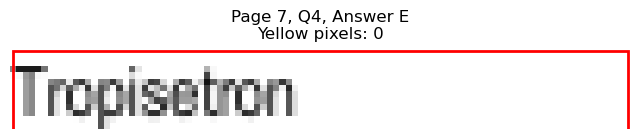


Page 7, Q4 - Selected Answer: B (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=82.5, y0=400.6, x1=110.5, y1=413.3
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 131
Page 7, Q5, A: Yellow percentage: 0.0%


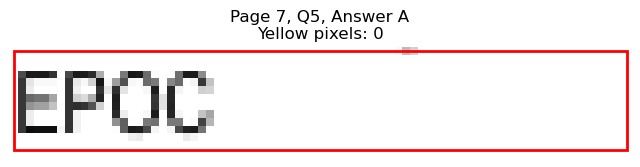

Page 7, Q5 - B: Detected box: x0=82.5, y0=413.3, x1=170.2, y1=426.0
Page 7, Q5, B: Yellow pixels: 1462
Page 7, Q5, B: Total non-white pixels: 1807
Page 7, Q5, B: Yellow percentage: 80.9%


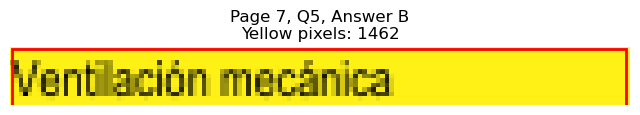

Page 7, Q5 - C: Detected box: x0=82.9, y0=425.9, x1=155.2, y1=438.6
Page 7, Q5, C: Yellow pixels: 124
Page 7, Q5, C: Total non-white pixels: 500
Page 7, Q5, C: Yellow percentage: 24.8%


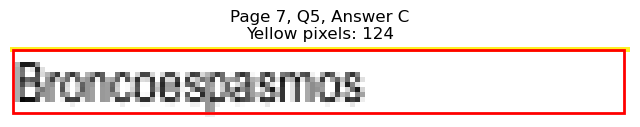

Page 7, Q5 - D: Detected box: x0=334.6, y0=400.6, x1=375.8, y1=413.3
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 240
Page 7, Q5, D: Yellow percentage: 0.0%


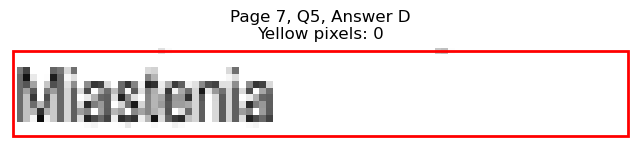

Page 7, Q5 - E: Detected box: x0=334.1, y0=413.3, x1=394.4, y1=426.0
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 313
Page 7, Q5, E: Yellow percentage: 0.0%


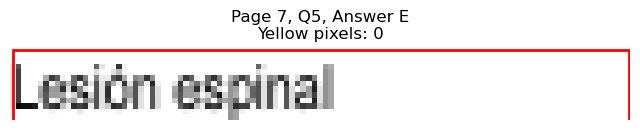


Page 7, Q5 - Selected Answer: B (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=82.5, y0=463.7, x1=187.8, y1=476.4
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 512
Page 7, Q6, A: Yellow percentage: 0.0%


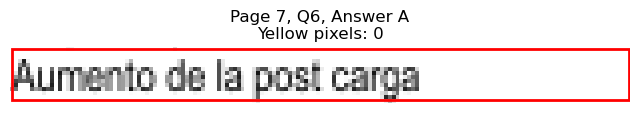

Page 7, Q6 - B: Detected box: x0=82.5, y0=476.3, x1=204.9, y1=489.0
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 615
Page 7, Q6, B: Yellow percentage: 0.0%


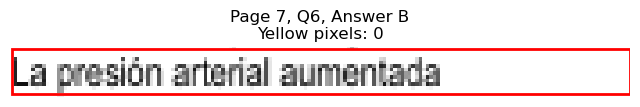

Page 7, Q6 - C: Detected box: x0=82.9, y0=489.1, x1=219.5, y1=501.7
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 701
Page 7, Q6, C: Yellow percentage: 0.0%


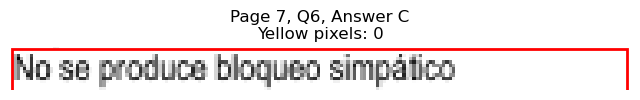

Page 7, Q6 - D: Detected box: x0=334.6, y0=463.7, x1=502.2, y1=476.4
Page 7, Q6, D: Yellow pixels: 1613
Page 7, Q6, D: Total non-white pixels: 2688
Page 7, Q6, D: Yellow percentage: 60.0%


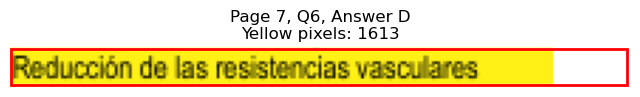

Page 7, Q6 - E: Detected box: x0=334.1, y0=476.3, x1=448.5, y1=489.0
Page 7, Q6, E: Yellow pixels: 0
Page 7, Q6, E: Total non-white pixels: 731
Page 7, Q6, E: Yellow percentage: 0.0%


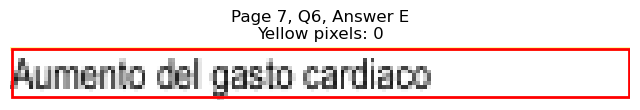


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=82.5, y0=526.9, x1=123.1, y1=539.5
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 216
Page 7, Q7, A: Yellow percentage: 0.0%


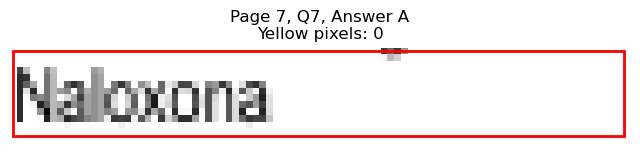

Page 7, Q7 - B: Detected box: x0=82.5, y0=539.5, x1=133.1, y1=552.1
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 264
Page 7, Q7, B: Yellow percentage: 0.0%


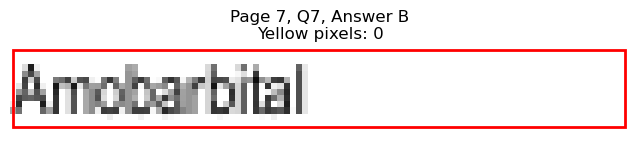

Page 7, Q7 - C: Detected box: x0=82.9, y0=552.2, x1=129.6, y1=564.8
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 248
Page 7, Q7, C: Yellow percentage: 0.0%


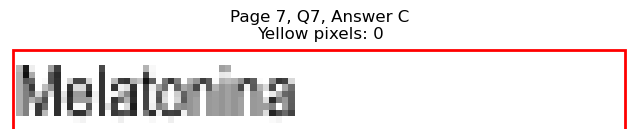

Page 7, Q7 - D: Detected box: x0=334.6, y0=526.9, x1=368.7, y1=539.5
Page 7, Q7, D: Yellow pixels: 85
Page 7, Q7, D: Total non-white pixels: 258
Page 7, Q7, D: Yellow percentage: 32.9%


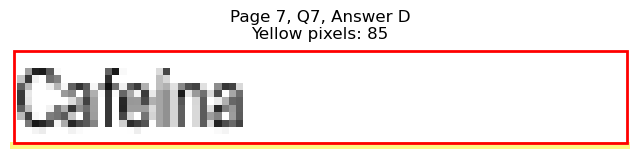

Page 7, Q7 - E: Detected box: x0=334.1, y0=539.5, x1=380.2, y1=552.1
Page 7, Q7, E: Yellow pixels: 1104
Page 7, Q7, E: Total non-white pixels: 1358
Page 7, Q7, E: Yellow percentage: 81.3%


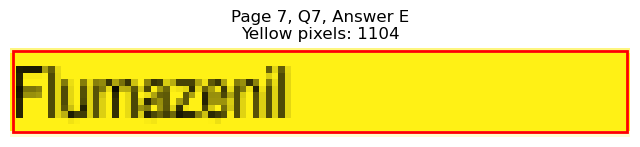


Page 7, Q7 - Selected Answer: E (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=82.5, y0=590.0, x1=121.1, y1=602.6
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 177
Page 7, Q8, A: Yellow percentage: 0.0%


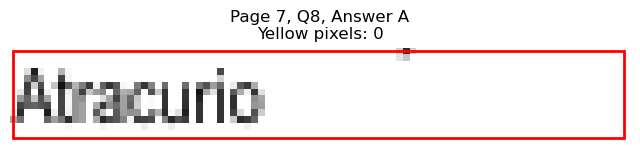

Page 7, Q8 - B: Detected box: x0=82.5, y0=602.6, x1=125.5, y1=615.2
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 218
Page 7, Q8, B: Yellow percentage: 0.0%


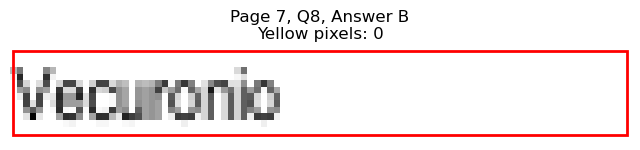

Page 7, Q8 - C: Detected box: x0=82.9, y0=615.2, x1=133.6, y1=627.8
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 254
Page 7, Q8, C: Yellow percentage: 0.0%


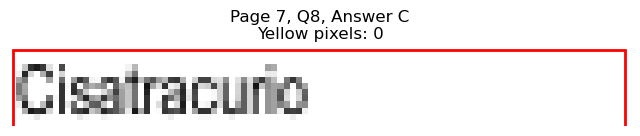

Page 7, Q8 - D: Detected box: x0=334.6, y0=590.0, x1=382.7, y1=602.6
Page 7, Q8, D: Yellow pixels: 1102
Page 7, Q8, D: Total non-white pixels: 1386
Page 7, Q8, D: Yellow percentage: 79.5%


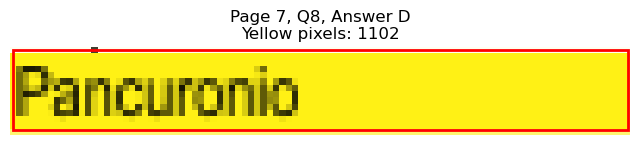

Page 7, Q8 - E: Detected box: x0=334.1, y0=602.6, x1=375.3, y1=615.2
Page 7, Q8, E: Yellow pixels: 92
Page 7, Q8, E: Total non-white pixels: 311
Page 7, Q8, E: Yellow percentage: 29.6%


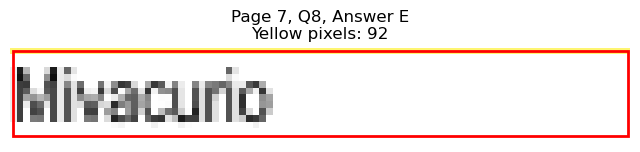


Page 7, Q8 - Selected Answer: D (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=82.5, y0=665.7, x1=139.7, y1=678.4
Page 7, Q9, A: Yellow pixels: 108
Page 7, Q9, A: Total non-white pixels: 368
Page 7, Q9, A: Yellow percentage: 29.3%


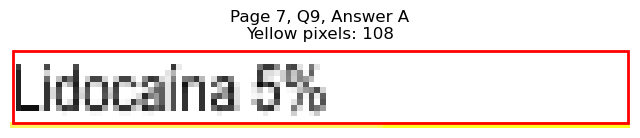

Page 7, Q9 - B: Detected box: x0=82.5, y0=678.3, x1=204.4, y1=691.0
Page 7, Q9, B: Yellow pixels: 1811
Page 7, Q9, B: Total non-white pixels: 2249
Page 7, Q9, B: Yellow percentage: 80.5%


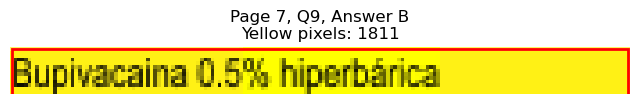

Page 7, Q9 - C: Detected box: x0=82.9, y0=691.1, x1=168.0, y1=703.7
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 538
Page 7, Q9, C: Yellow percentage: 0.0%


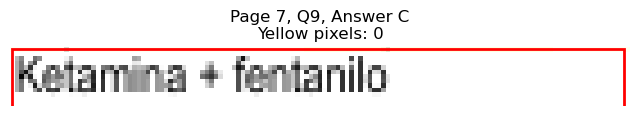

Page 7, Q9 - D: Detected box: x0=334.6, y0=665.7, x1=370.7, y1=678.4
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 180
Page 7, Q9, D: Yellow percentage: 0.0%


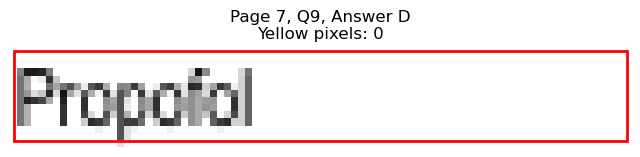

Page 7, Q9 - E: Detected box: x0=334.1, y0=678.3, x1=391.9, y1=691.0
Page 7, Q9, E: Yellow pixels: 0
Page 7, Q9, E: Total non-white pixels: 313
Page 7, Q9, E: Yellow percentage: 0.0%


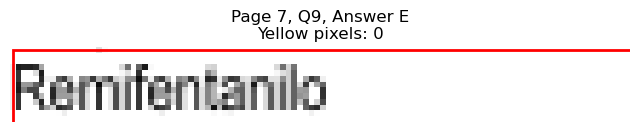


Page 7, Q9 - Selected Answer: B (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=82.5, y0=741.4, x1=135.1, y1=754.1
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 248
Page 7, Q10, A: Yellow percentage: 0.0%


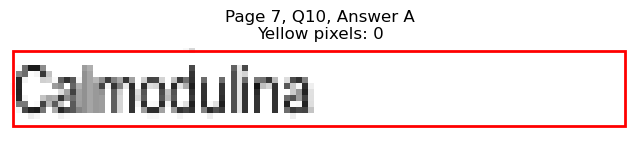

Page 7, Q10 - B: Detected box: x0=82.5, y0=754.0, x1=135.6, y1=766.7
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 248
Page 7, Q10, B: Yellow percentage: 0.0%


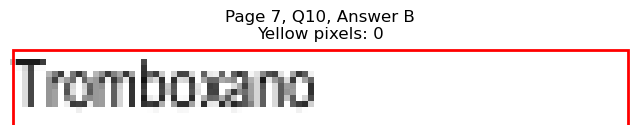

Page 7, Q10 - C: Detected box: x0=82.9, y0=766.8, x1=133.6, y1=779.4
Page 7, Q10, C: Yellow pixels: 1027
Page 7, Q10, C: Total non-white pixels: 1428
Page 7, Q10, C: Yellow percentage: 71.9%


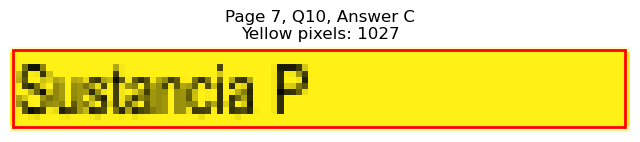

Page 7, Q10 - D: Detected box: x0=334.6, y0=741.4, x1=391.3, y1=754.1
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 275
Page 7, Q10, D: Yellow percentage: 0.0%


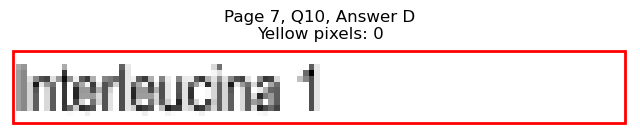

Page 7, Q10 - E: Detected box: x0=334.1, y0=754.0, x1=411.4, y1=766.7
Page 7, Q10, E: Yellow pixels: 0
Page 7, Q10, E: Total non-white pixels: 375
Page 7, Q10, E: Yellow percentage: 0.0%


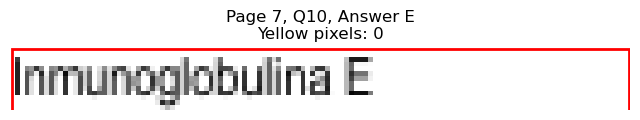


Page 7, Q10 - Selected Answer: C (based on yellow pixel count)





Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=159.7, y1=110.4
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 413
Page 8, Q1, A: Yellow percentage: 0.0%


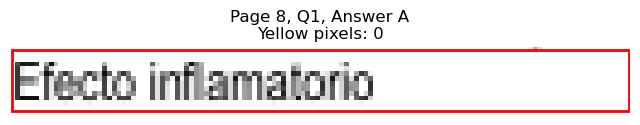

Page 8, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=218.9, y1=123.0
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 659
Page 8, Q1, B: Yellow percentage: 0.0%


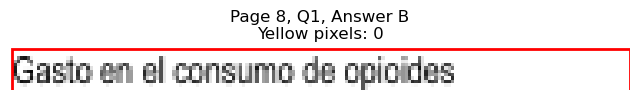

Page 8, Q1 - C: Detected box: x0=82.9, y0=122.9, x1=153.7, y1=135.6
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 332
Page 8, Q1, C: Yellow percentage: 0.0%


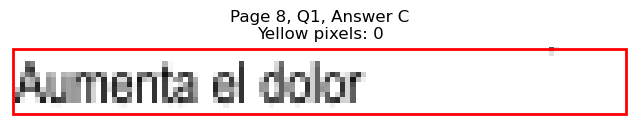

Page 8, Q1 - D: Detected box: x0=334.6, y0=97.7, x1=458.9, y1=110.4
Page 8, Q1, D: Yellow pixels: 1613
Page 8, Q1, D: Total non-white pixels: 2450
Page 8, Q1, D: Yellow percentage: 65.8%


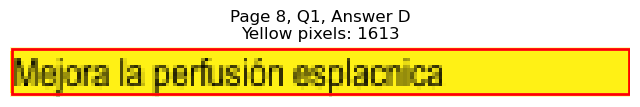

Page 8, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=426.9, y1=123.0
Page 8, Q1, E: Yellow pixels: 0
Page 8, Q1, E: Total non-white pixels: 627
Page 8, Q1, E: Yellow percentage: 0.0%


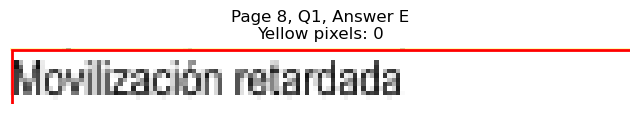


Page 8, Q1 - Selected Answer: D (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=82.5, y0=173.4, x1=152.7, y1=186.1
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 363
Page 8, Q2, A: Yellow percentage: 0.0%


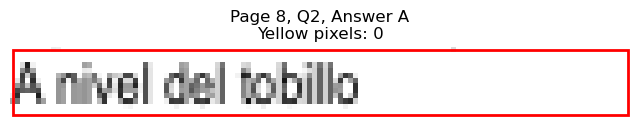

Page 8, Q2 - B: Detected box: x0=82.5, y0=186.0, x1=160.7, y1=198.7
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 386
Page 8, Q2, B: Yellow percentage: 0.0%


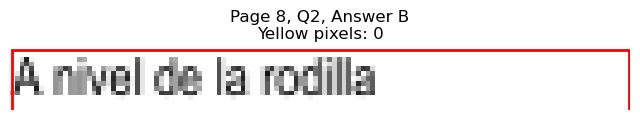

Page 8, Q2 - C: Detected box: x0=82.9, y0=198.6, x1=151.1, y1=211.3
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 321
Page 8, Q2, C: Yellow percentage: 0.0%


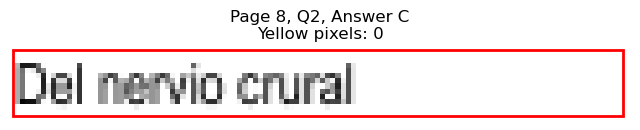

Page 8, Q2 - D: Detected box: x0=334.6, y0=173.4, x1=440.5, y1=186.1
Page 8, Q2, D: Yellow pixels: 1623
Page 8, Q2, D: Total non-white pixels: 2198
Page 8, Q2, D: Yellow percentage: 73.8%


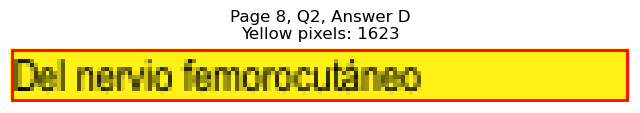

Page 8, Q2 - E: Detected box: x0=334.1, y0=186.0, x1=429.4, y1=198.7
Page 8, Q2, E: Yellow pixels: 0
Page 8, Q2, E: Total non-white pixels: 619
Page 8, Q2, E: Yellow percentage: 0.0%


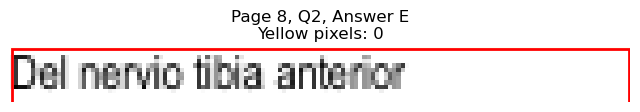


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=82.5, y0=236.5, x1=165.9, y1=249.2
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 443
Page 8, Q3, A: Yellow percentage: 0.0%


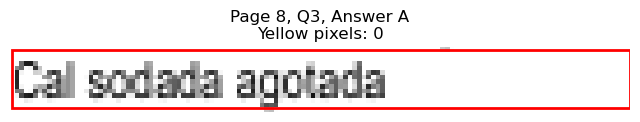

Page 8, Q3 - B: Detected box: x0=82.5, y0=249.1, x1=192.3, y1=261.8
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 549
Page 8, Q3, B: Yellow percentage: 0.0%


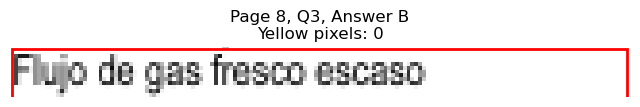

Page 8, Q3 - C: Detected box: x0=82.9, y0=261.7, x1=212.9, y1=274.4
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 642
Page 8, Q3, C: Yellow percentage: 0.0%


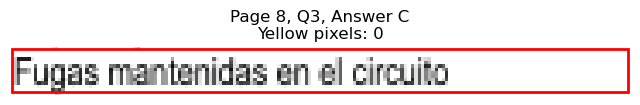

Page 8, Q3 - D: Detected box: x0=334.6, y0=236.5, x1=418.4, y1=249.2
Page 8, Q3, D: Yellow pixels: 135
Page 8, Q3, D: Total non-white pixels: 541
Page 8, Q3, D: Yellow percentage: 25.0%


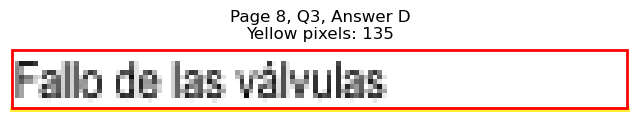

Page 8, Q3 - E: Detected box: x0=334.1, y0=249.1, x1=475.5, y1=261.8
Page 8, Q3, E: Yellow pixels: 1952
Page 8, Q3, E: Total non-white pixels: 2496
Page 8, Q3, E: Yellow percentage: 78.2%


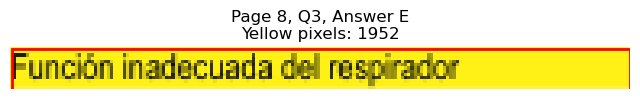


Page 8, Q3 - Selected Answer: E (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=82.5, y0=299.7, x1=161.2, y1=312.3
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 401
Page 8, Q4, A: Yellow percentage: 0.0%


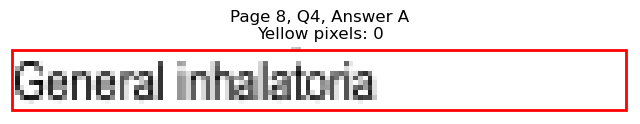

Page 8, Q4 - B: Detected box: x0=82.5, y0=312.3, x1=166.2, y1=324.9
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 545
Page 8, Q4, B: Yellow percentage: 0.0%


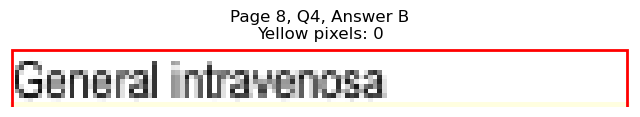

Page 8, Q4 - C: Detected box: x0=82.9, y0=324.9, x1=118.7, y1=337.5
Page 8, Q4, C: Yellow pixels: 954
Page 8, Q4, C: Total non-white pixels: 1218
Page 8, Q4, C: Yellow percentage: 78.3%


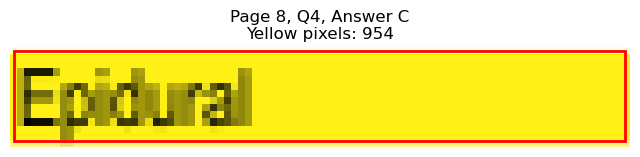

Page 8, Q4 - D: Detected box: x0=334.6, y0=299.7, x1=440.6, y1=312.3
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 523
Page 8, Q4, D: Yellow percentage: 0.0%


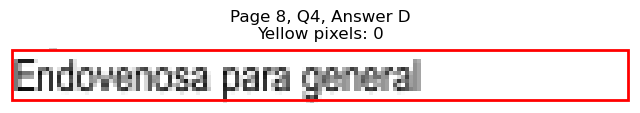

Page 8, Q4 - E: Detected box: x0=334.1, y0=312.3, x1=365.2, y1=324.9
Page 8, Q4, E: Yellow pixels: 0
Page 8, Q4, E: Total non-white pixels: 165
Page 8, Q4, E: Yellow percentage: 0.0%


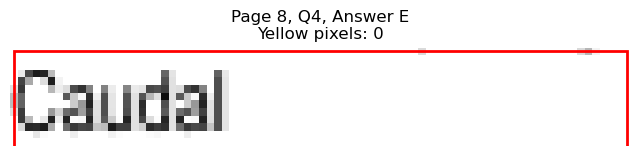


Page 8, Q4 - Selected Answer: C (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=82.5, y0=362.8, x1=132.6, y1=375.5
Page 8, Q5, A: Yellow pixels: 101
Page 8, Q5, A: Total non-white pixels: 383
Page 8, Q5, A: Yellow percentage: 26.4%


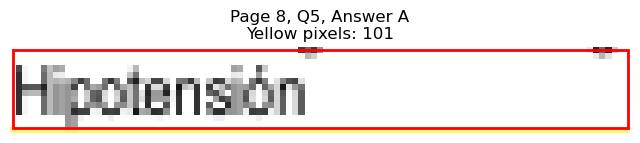

Page 8, Q5 - B: Detected box: x0=82.5, y0=375.4, x1=137.2, y1=388.1
Page 8, Q5, B: Yellow pixels: 1156
Page 8, Q5, B: Total non-white pixels: 1484
Page 8, Q5, B: Yellow percentage: 77.9%


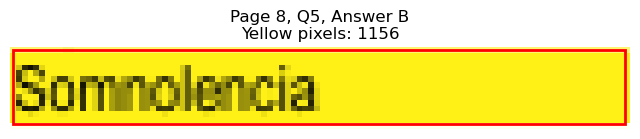

Page 8, Q5 - C: Detected box: x0=82.9, y0=388.0, x1=137.2, y1=400.7
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 374
Page 8, Q5, C: Yellow percentage: 0.0%


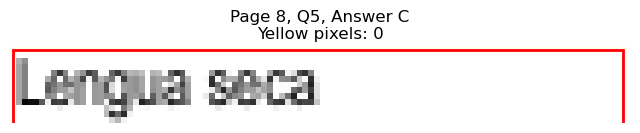

Page 8, Q5 - D: Detected box: x0=334.6, y0=362.8, x1=399.8, y1=375.5
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 333
Page 8, Q5, D: Yellow percentage: 0.0%


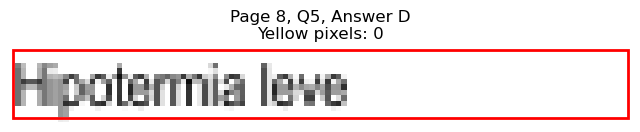

Page 8, Q5 - E: Detected box: x0=334.1, y0=375.4, x1=380.8, y1=388.1
Page 8, Q5, E: Yellow pixels: 0
Page 8, Q5, E: Total non-white pixels: 251
Page 8, Q5, E: Yellow percentage: 0.0%


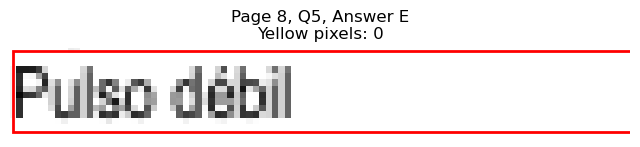


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=82.5, y0=425.9, x1=128.1, y1=438.6
Page 8, Q6, A: Yellow pixels: 1088
Page 8, Q6, A: Total non-white pixels: 1358
Page 8, Q6, A: Yellow percentage: 80.1%


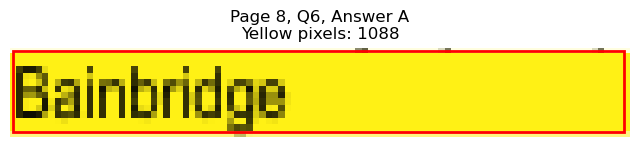

Page 8, Q6 - B: Detected box: x0=82.5, y0=438.5, x1=126.6, y1=451.2
Page 8, Q6, B: Yellow pixels: 93
Page 8, Q6, B: Total non-white pixels: 320
Page 8, Q6, B: Yellow percentage: 29.1%


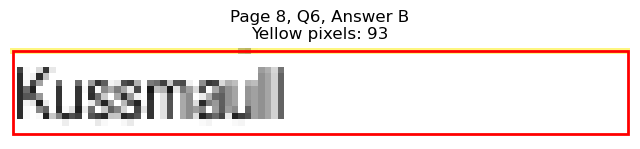

Page 8, Q6 - C: Detected box: x0=82.9, y0=451.1, x1=118.1, y1=463.8
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 167
Page 8, Q6, C: Yellow percentage: 0.0%


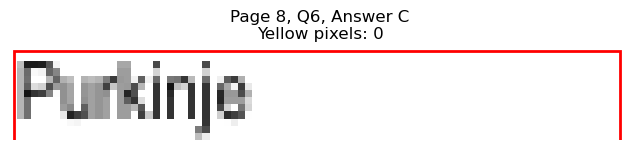

Page 8, Q6 - D: Detected box: x0=334.6, y0=425.9, x1=380.2, y1=438.6
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 225
Page 8, Q6, D: Yellow percentage: 0.0%


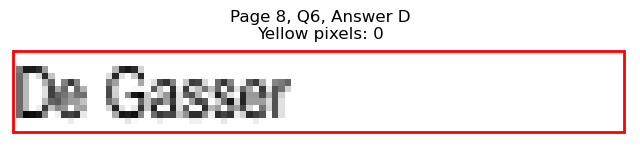

Page 8, Q6 - E: Detected box: x0=334.1, y0=438.5, x1=373.3, y1=451.2
Page 8, Q6, E: Yellow pixels: 0
Page 8, Q6, E: Total non-white pixels: 221
Page 8, Q6, E: Yellow percentage: 0.0%


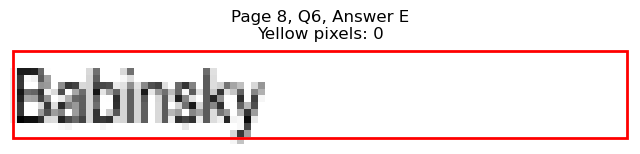


Page 8, Q6 - Selected Answer: A (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=82.5, y0=489.1, x1=143.7, y1=501.7
Page 8, Q7, A: Yellow pixels: 1222
Page 8, Q7, A: Total non-white pixels: 1456
Page 8, Q7, A: Yellow percentage: 83.9%


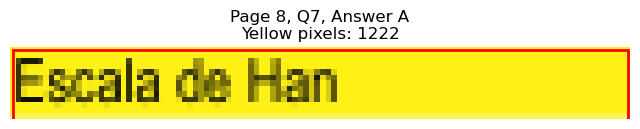

Page 8, Q7 - B: Detected box: x0=82.5, y0=501.7, x1=154.7, y1=514.3
Page 8, Q7, B: Yellow pixels: 123
Page 8, Q7, B: Total non-white pixels: 453
Page 8, Q7, B: Yellow percentage: 27.2%


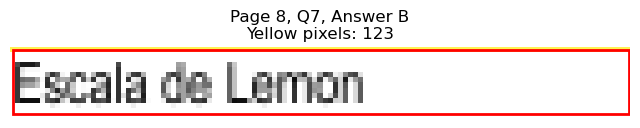

Page 8, Q7 - C: Detected box: x0=82.9, y0=514.3, x1=145.1, y1=526.9
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 317
Page 8, Q7, C: Yellow percentage: 0.0%


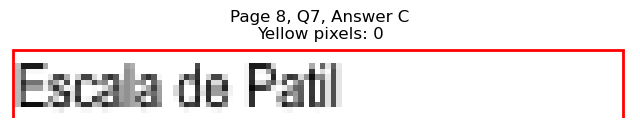

Page 8, Q7 - D: Detected box: x0=334.6, y0=489.1, x1=422.9, y1=501.7
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 467
Page 8, Q7, D: Yellow percentage: 0.0%


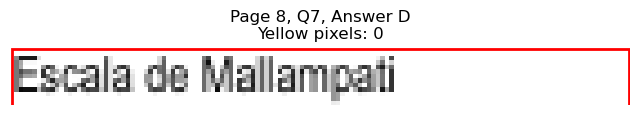

Page 8, Q7 - E: Detected box: x0=334.1, y0=501.7, x1=447.5, y1=514.3
Page 8, Q7, E: Yellow pixels: 0
Page 8, Q7, E: Total non-white pixels: 549
Page 8, Q7, E: Yellow percentage: 0.0%


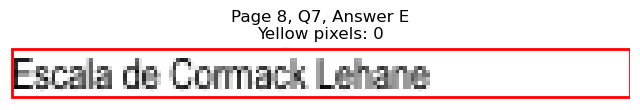


Page 8, Q7 - Selected Answer: A (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=82.5, y0=564.8, x1=93.5, y1=577.4
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 46
Page 8, Q8, A: Yellow percentage: 0.0%


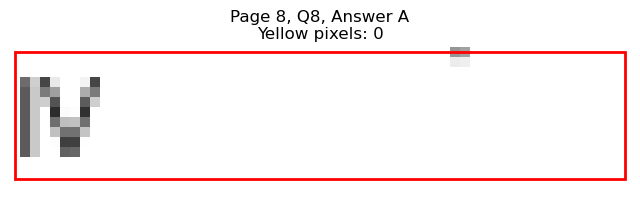

Page 8, Q8 - B: Detected box: x0=70.8, y0=577.4, x1=79.3, y1=590.0
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 58
Page 8, Q8, B: Yellow percentage: 0.0%


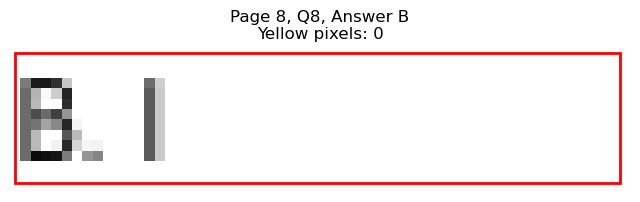

Page 8, Q8 - C: Detected box: x0=82.9, y0=590.0, x1=93.0, y1=602.6
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 48
Page 8, Q8, C: Yellow percentage: 0.0%


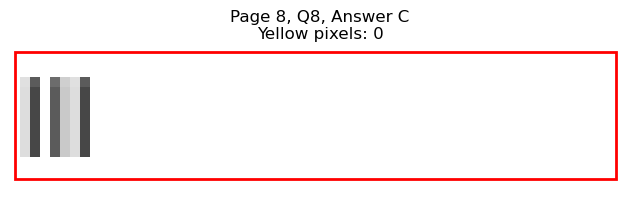

Page 8, Q8 - D: Detected box: x0=322.5, y0=564.8, x1=331.5, y1=577.4
Page 8, Q8, D: Yellow pixels: 60
Page 8, Q8, D: Total non-white pixels: 124
Page 8, Q8, D: Yellow percentage: 48.4%


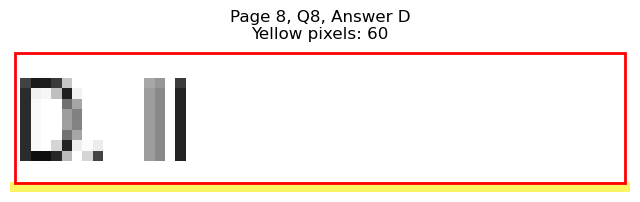

Page 8, Q8 - E: Detected box: x0=334.1, y0=577.4, x1=342.7, y1=590.0
Page 8, Q8, E: Yellow pixels: 745
Page 8, Q8, E: Total non-white pixels: 767
Page 8, Q8, E: Yellow percentage: 97.1%


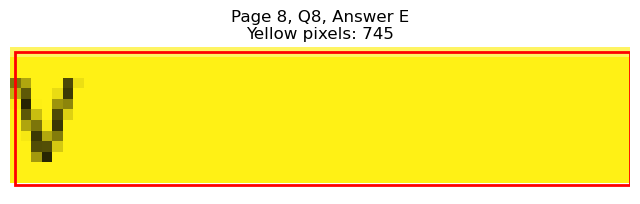


Page 8, Q8 - Selected Answer: E (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=82.5, y0=627.9, x1=133.6, y1=640.6
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 267
Page 8, Q9, A: Yellow percentage: 0.0%


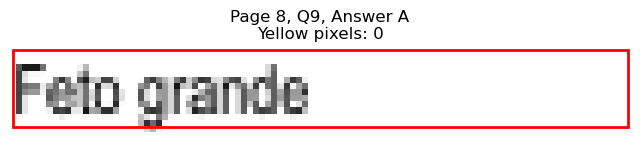

Page 8, Q9 - B: Detected box: x0=82.5, y0=640.5, x1=148.7, y1=653.2
Page 8, Q9, B: Yellow pixels: 117
Page 8, Q9, B: Total non-white pixels: 454
Page 8, Q9, B: Yellow percentage: 25.8%


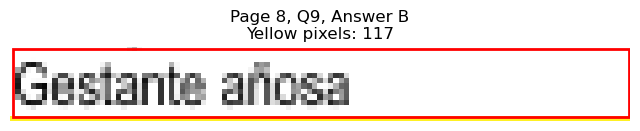

Page 8, Q9 - C: Detected box: x0=82.9, y0=653.1, x1=143.2, y1=665.8
Page 8, Q9, C: Yellow pixels: 1218
Page 8, Q9, C: Total non-white pixels: 1456
Page 8, Q9, C: Yellow percentage: 83.7%


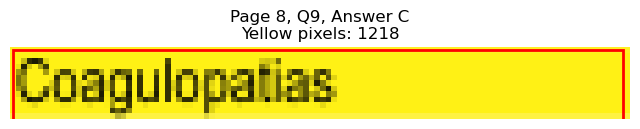

Page 8, Q9 - D: Detected box: x0=334.6, y0=627.9, x1=378.3, y1=640.6
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 246
Page 8, Q9, D: Yellow percentage: 0.0%


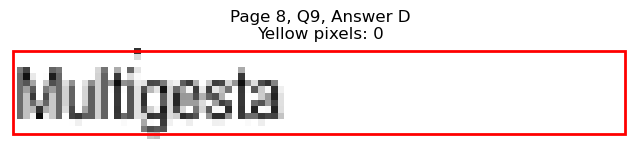

Page 8, Q9 - E: Detected box: x0=334.1, y0=640.5, x1=424.5, y1=653.2
Page 8, Q9, E: Yellow pixels: 0
Page 8, Q9, E: Total non-white pixels: 469
Page 8, Q9, E: Yellow percentage: 0.0%


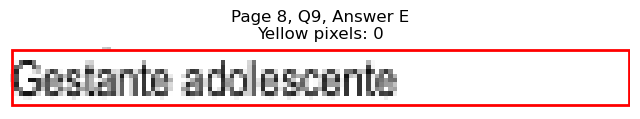


Page 8, Q9 - Selected Answer: C (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=82.5, y0=703.7, x1=146.7, y1=716.3
Page 8, Q10, A: Yellow pixels: 115
Page 8, Q10, A: Total non-white pixels: 455
Page 8, Q10, A: Yellow percentage: 25.3%


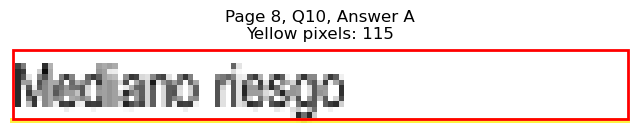

Page 8, Q10 - B: Detected box: x0=82.5, y0=716.3, x1=127.6, y1=728.9
Page 8, Q10, B: Yellow pixels: 1082
Page 8, Q10, B: Total non-white pixels: 1248
Page 8, Q10, B: Yellow percentage: 86.7%


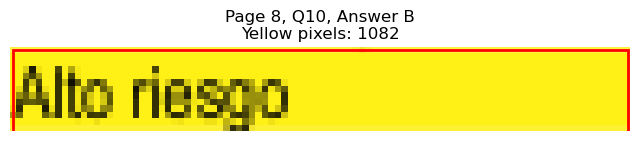

Page 8, Q10 - C: Detected box: x0=82.9, y0=728.9, x1=130.6, y1=741.5
Page 8, Q10, C: Yellow pixels: 95
Page 8, Q10, C: Total non-white pixels: 358
Page 8, Q10, C: Yellow percentage: 26.5%


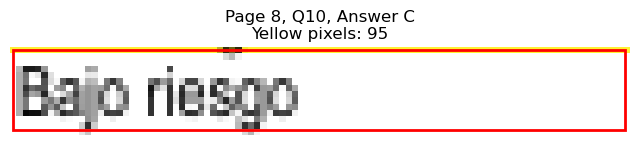

Page 8, Q10 - D: Detected box: x0=334.6, y0=703.7, x1=377.2, y1=716.3
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 218
Page 8, Q10, D: Yellow percentage: 0.0%


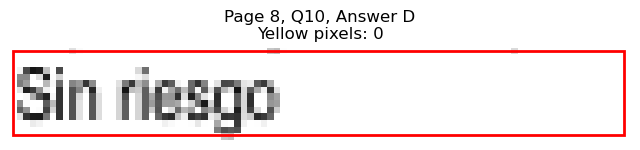

Page 8, Q10 - E: Detected box: x0=334.1, y0=716.3, x1=397.9, y1=728.9
Page 8, Q10, E: Yellow pixels: 0
Page 8, Q10, E: Total non-white pixels: 351
Page 8, Q10, E: Yellow percentage: 0.0%


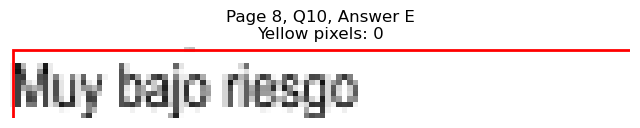


Page 8, Q10 - Selected Answer: B (based on yellow pixel count)





Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=102.5, y1=110.4
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 104
Page 9, Q1, A: Yellow percentage: 0.0%


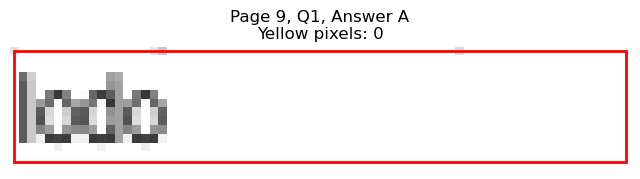

Page 9, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=125.1, y1=123.0
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 204
Page 9, Q1, B: Yellow percentage: 0.0%


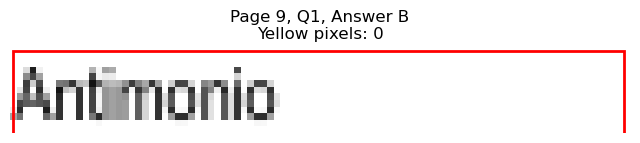

Page 9, Q1 - C: Detected box: x0=82.9, y0=122.9, x1=107.1, y1=135.6
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 107
Page 9, Q1, C: Yellow percentage: 0.0%


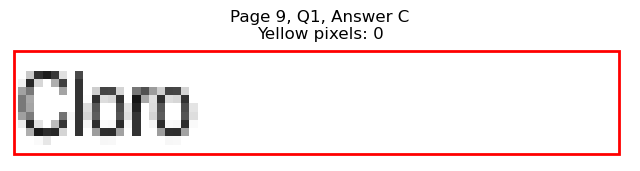

Page 9, Q1 - D: Detected box: x0=334.6, y0=97.7, x1=376.3, y1=110.4
Page 9, Q1, D: Yellow pixels: 93
Page 9, Q1, D: Total non-white pixels: 324
Page 9, Q1, D: Yellow percentage: 28.7%


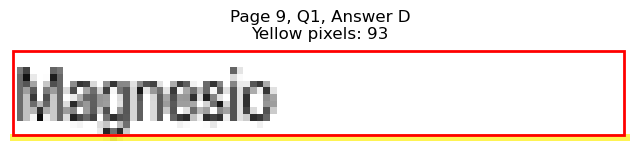

Page 9, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=362.7, y1=123.0
Page 9, Q1, E: Yellow pixels: 915
Page 9, Q1, E: Total non-white pixels: 1027
Page 9, Q1, E: Yellow percentage: 89.1%


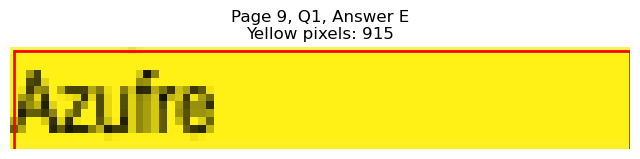


Page 9, Q1 - Selected Answer: E (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=82.5, y0=160.8, x1=210.4, y1=173.5
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 655
Page 9, Q2, A: Yellow percentage: 0.0%


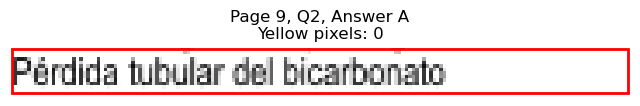

Page 9, Q2 - B: Detected box: x0=82.5, y0=173.4, x1=114.5, y1=186.1
Page 9, Q2, B: Yellow pixels: 83
Page 9, Q2, B: Total non-white pixels: 248
Page 9, Q2, B: Yellow percentage: 33.5%


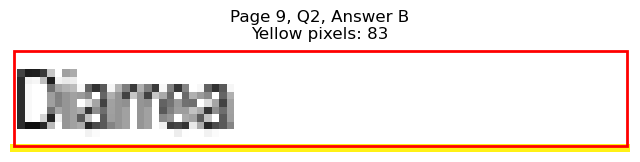

Page 9, Q2 - C: Detected box: x0=82.9, y0=186.0, x1=189.4, y1=198.7
Page 9, Q2, C: Yellow pixels: 1626
Page 9, Q2, C: Total non-white pixels: 2054
Page 9, Q2, C: Yellow percentage: 79.2%


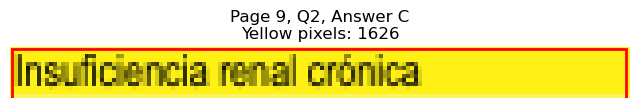

Page 9, Q2 - D: Detected box: x0=334.6, y0=160.8, x1=413.3, y1=173.5
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 403
Page 9, Q2, D: Yellow percentage: 0.0%


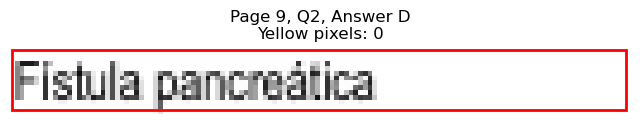

Page 9, Q2 - E: Detected box: x0=334.1, y0=173.4, x1=436.5, y1=186.1
Page 9, Q2, E: Yellow pixels: 0
Page 9, Q2, E: Total non-white pixels: 523
Page 9, Q2, E: Yellow percentage: 0.0%


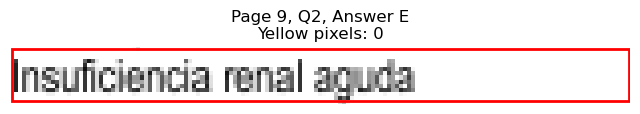


Page 9, Q2 - Selected Answer: C (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=82.5, y0=223.9, x1=148.1, y1=236.6
Page 9, Q3, A: Yellow pixels: 117
Page 9, Q3, A: Total non-white pixels: 454
Page 9, Q3, A: Yellow percentage: 25.8%


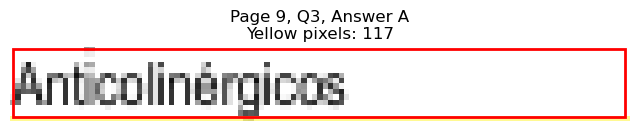

Page 9, Q3 - B: Detected box: x0=82.5, y0=236.5, x1=164.2, y1=249.2
Page 9, Q3, B: Yellow pixels: 1405
Page 9, Q3, B: Total non-white pixels: 1862
Page 9, Q3, B: Yellow percentage: 75.5%


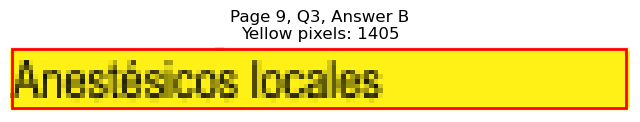

Page 9, Q3 - C: Detected box: x0=82.9, y0=249.1, x1=187.8, y1=261.8
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 689
Page 9, Q3, C: Yellow percentage: 0.0%


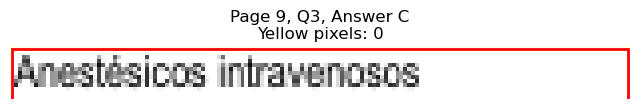

Page 9, Q3 - D: Detected box: x0=334.6, y0=223.9, x1=396.9, y1=236.6
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 322
Page 9, Q3, D: Yellow percentage: 0.0%


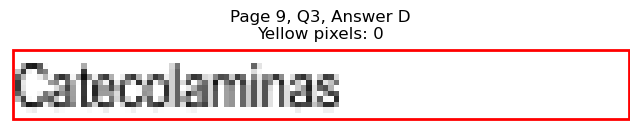

Page 9, Q3 - E: Detected box: x0=334.1, y0=236.5, x1=372.3, y1=249.2
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 211
Page 9, Q3, E: Yellow percentage: 0.0%


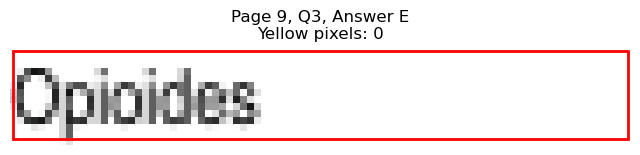


Page 9, Q3 - Selected Answer: B (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=82.5, y0=299.7, x1=160.2, y1=312.3
Page 9, Q4, A: Yellow pixels: 129
Page 9, Q4, A: Total non-white pixels: 494
Page 9, Q4, A: Yellow percentage: 26.1%


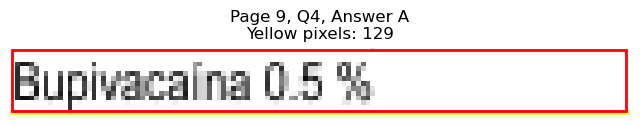

Page 9, Q4 - B: Detected box: x0=82.5, y0=312.3, x1=141.6, y1=324.9
Page 9, Q4, B: Yellow pixels: 1186
Page 9, Q4, B: Total non-white pixels: 1430
Page 9, Q4, B: Yellow percentage: 82.9%


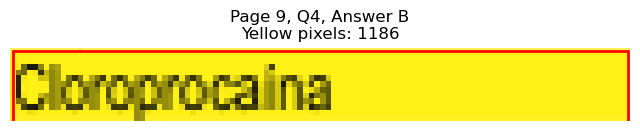

Page 9, Q4 - C: Detected box: x0=82.9, y0=324.9, x1=163.2, y1=337.5
Page 9, Q4, C: Yellow pixels: 130
Page 9, Q4, C: Total non-white pixels: 545
Page 9, Q4, C: Yellow percentage: 23.9%


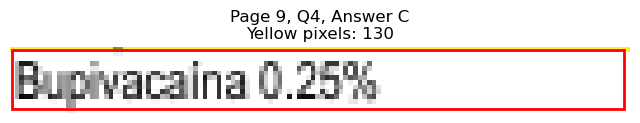

Page 9, Q4 - D: Detected box: x0=334.6, y0=299.7, x1=391.9, y1=312.3
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 265
Page 9, Q4, D: Yellow percentage: 0.0%


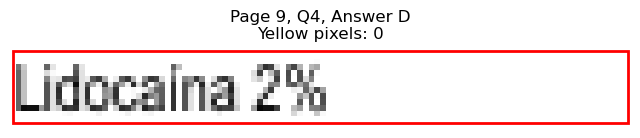

Page 9, Q4 - E: Detected box: x0=334.1, y0=312.3, x1=379.3, y1=324.9
Page 9, Q4, E: Yellow pixels: 0
Page 9, Q4, E: Total non-white pixels: 227
Page 9, Q4, E: Yellow percentage: 0.0%


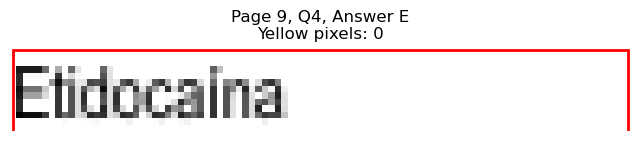


Page 9, Q4 - Selected Answer: B (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=82.5, y0=362.8, x1=128.2, y1=375.5
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 213
Page 9, Q5, A: Yellow percentage: 0.0%


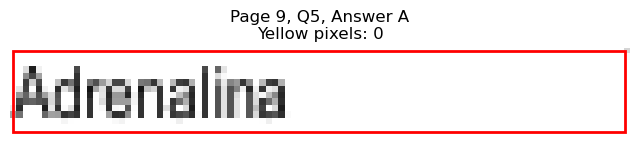

Page 9, Q5 - B: Detected box: x0=82.5, y0=375.4, x1=160.7, y1=388.1
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 393
Page 9, Q5, B: Yellow percentage: 0.0%


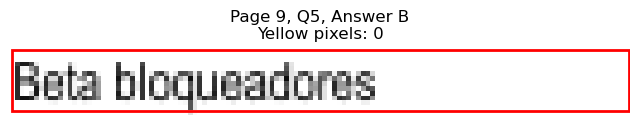

Page 9, Q5 - C: Detected box: x0=82.9, y0=388.0, x1=235.5, y1=400.7
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 743
Page 9, Q5, C: Yellow percentage: 0.0%


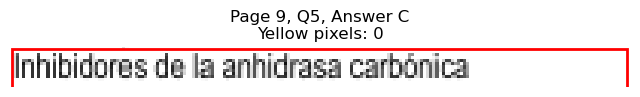

Page 9, Q5 - D: Detected box: x0=334.6, y0=362.8, x1=462.1, y1=375.5
Page 9, Q5, D: Yellow pixels: 179
Page 9, Q5, D: Total non-white pixels: 819
Page 9, Q5, D: Yellow percentage: 21.9%


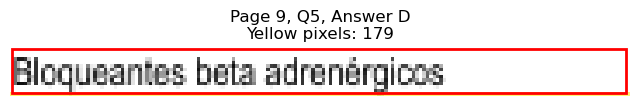

Page 9, Q5 - E: Detected box: x0=334.1, y0=375.4, x1=374.8, y1=388.1
Page 9, Q5, E: Yellow pixels: 1027
Page 9, Q5, E: Total non-white pixels: 1274
Page 9, Q5, E: Yellow percentage: 80.6%


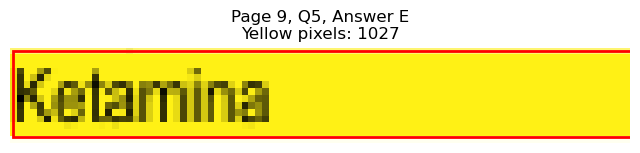


Page 9, Q5 - Selected Answer: E (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=82.5, y0=438.5, x1=114.0, y1=451.2
Page 9, Q6, A: Yellow pixels: 954
Page 9, Q6, A: Total non-white pixels: 1162
Page 9, Q6, A: Yellow percentage: 82.1%


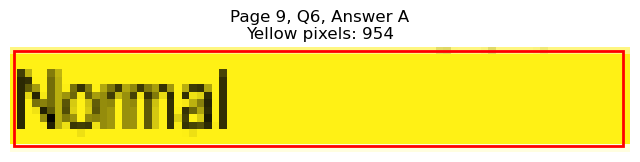

Page 9, Q6 - B: Detected box: x0=82.5, y0=451.1, x1=185.3, y1=463.8
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 681
Page 9, Q6, B: Yellow percentage: 0.0%


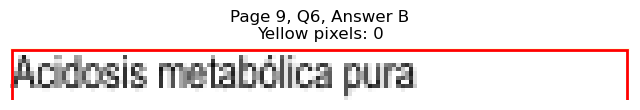

Page 9, Q6 - C: Detected box: x0=82.9, y0=463.7, x1=231.9, y1=476.4
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 756
Page 9, Q6, C: Yellow percentage: 0.0%


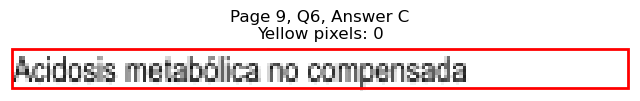

Page 9, Q6 - D: Detected box: x0=334.6, y0=438.5, x1=420.4, y1=451.2
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 444
Page 9, Q6, D: Yellow percentage: 0.0%


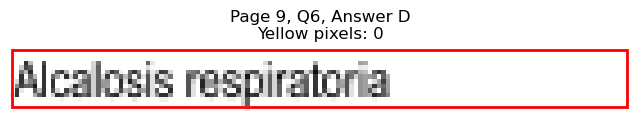

Page 9, Q6 - E: Detected box: x0=334.1, y0=451.1, x1=472.1, y1=463.8
Page 9, Q6, E: Yellow pixels: 0
Page 9, Q6, E: Total non-white pixels: 701
Page 9, Q6, E: Yellow percentage: 0.0%


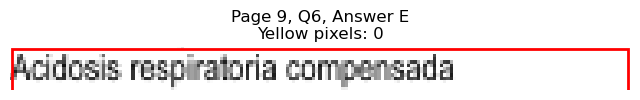


Page 9, Q6 - Selected Answer: A (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=82.5, y0=501.7, x1=210.4, y1=514.3
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 638
Page 9, Q7, A: Yellow percentage: 0.0%


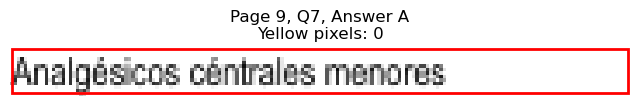

Page 9, Q7 - B: Detected box: x0=82.5, y0=514.3, x1=177.9, y1=526.9
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 496
Page 9, Q7, B: Yellow percentage: 0.0%


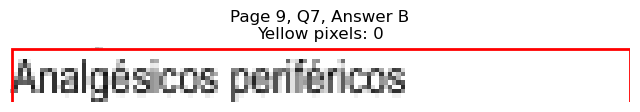

Page 9, Q7 - C: Detected box: x0=82.9, y0=526.9, x1=112.6, y1=539.5
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 163
Page 9, Q7, C: Yellow percentage: 0.0%


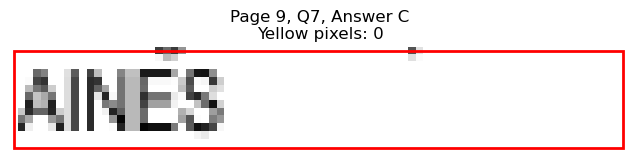

Page 9, Q7 - D: Detected box: x0=334.6, y0=501.7, x1=462.1, y1=514.3
Page 9, Q7, D: Yellow pixels: 1645
Page 9, Q7, D: Total non-white pixels: 2506
Page 9, Q7, D: Yellow percentage: 65.6%


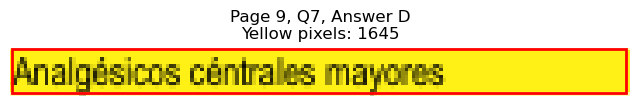

Page 9, Q7 - E: Detected box: x0=334.1, y0=514.3, x1=402.3, y1=526.9
Page 9, Q7, E: Yellow pixels: 0
Page 9, Q7, E: Total non-white pixels: 465
Page 9, Q7, E: Yellow percentage: 0.0%


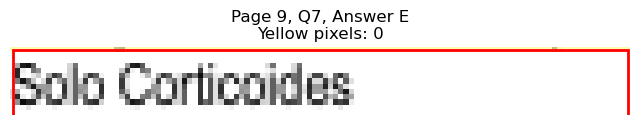


Page 9, Q7 - Selected Answer: D (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=82.5, y0=577.4, x1=128.5, y1=590.0
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 241
Page 9, Q8, A: Yellow percentage: 0.0%


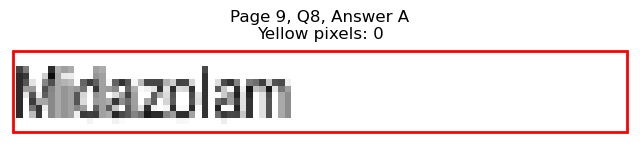

Page 9, Q8 - B: Detected box: x0=82.5, y0=590.0, x1=123.1, y1=602.6
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 197
Page 9, Q8, B: Yellow percentage: 0.0%


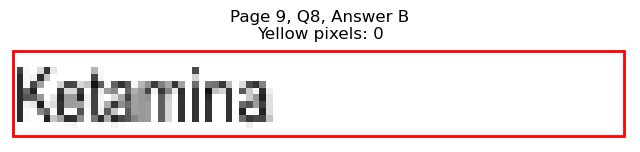

Page 9, Q8 - C: Detected box: x0=82.9, y0=602.6, x1=122.5, y1=615.2
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 204
Page 9, Q8, C: Yellow percentage: 0.0%


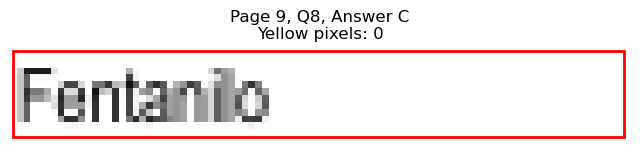

Page 9, Q8 - D: Detected box: x0=334.6, y0=577.4, x1=374.2, y1=590.0
Page 9, Q8, D: Yellow pixels: 91
Page 9, Q8, D: Total non-white pixels: 378
Page 9, Q8, D: Yellow percentage: 24.1%


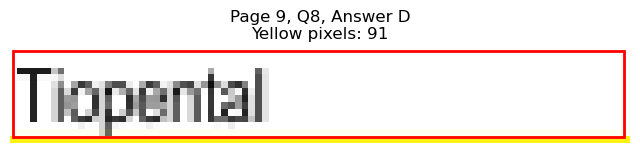

Page 9, Q8 - E: Detected box: x0=334.1, y0=590.0, x1=370.3, y1=602.6
Page 9, Q8, E: Yellow pixels: 993
Page 9, Q8, E: Total non-white pixels: 1218
Page 9, Q8, E: Yellow percentage: 81.5%


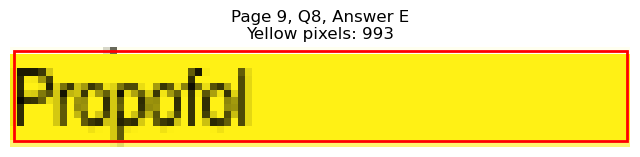


Page 9, Q8 - Selected Answer: E (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=82.5, y0=640.5, x1=112.1, y1=653.2
Page 9, Q9, A: Yellow pixels: 81
Page 9, Q9, A: Total non-white pixels: 201
Page 9, Q9, A: Yellow percentage: 40.3%


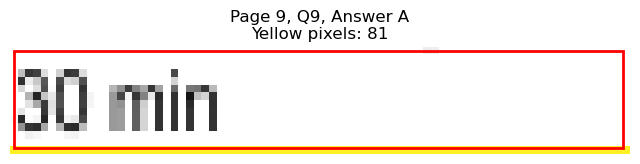

Page 9, Q9 - B: Detected box: x0=82.5, y0=653.1, x1=107.1, y1=665.8
Page 9, Q9, B: Yellow pixels: 912
Page 9, Q9, B: Total non-white pixels: 988
Page 9, Q9, B: Yellow percentage: 92.3%


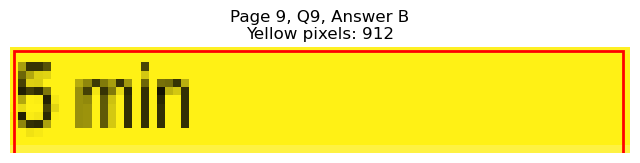

Page 9, Q9 - C: Detected box: x0=82.9, y0=665.7, x1=111.0, y1=678.4
Page 9, Q9, C: Yellow pixels: 80
Page 9, Q9, C: Total non-white pixels: 181
Page 9, Q9, C: Yellow percentage: 44.2%


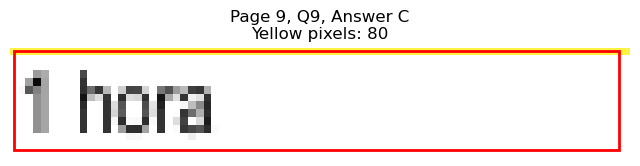

Page 9, Q9 - D: Detected box: x0=334.6, y0=640.5, x1=367.3, y1=653.2
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 149
Page 9, Q9, D: Yellow percentage: 0.0%


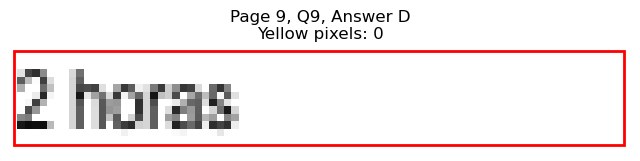

Page 9, Q9 - E: Detected box: x0=334.1, y0=653.1, x1=363.8, y1=665.8
Page 9, Q9, E: Yellow pixels: 0
Page 9, Q9, E: Total non-white pixels: 133
Page 9, Q9, E: Yellow percentage: 0.0%


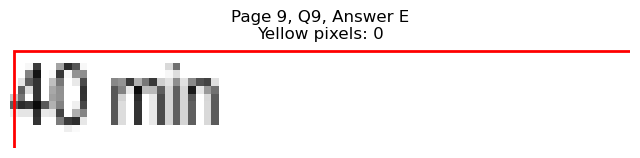


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=70.8, y0=703.7, x1=79.3, y1=716.3
Page 9, Q10, A: Yellow pixels: 679
Page 9, Q10, A: Total non-white pixels: 840
Page 9, Q10, A: Yellow percentage: 80.8%


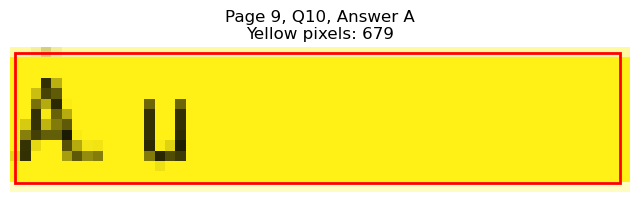

Page 9, Q10 - B: Detected box: x0=70.8, y0=716.3, x1=79.3, y1=728.9
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 123
Page 9, Q10, B: Yellow percentage: 0.0%


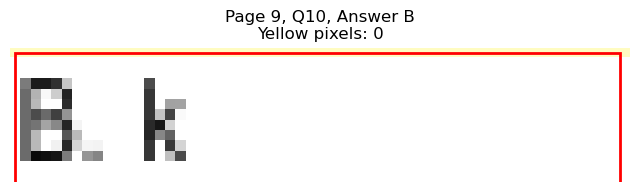

Page 9, Q10 - C: Detected box: x0=70.8, y0=728.9, x1=79.8, y1=741.5
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 68
Page 9, Q10, C: Yellow percentage: 0.0%


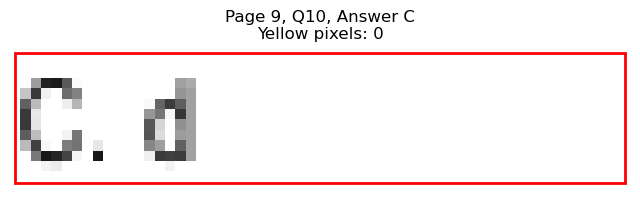

Page 9, Q10 - D: Detected box: x0=334.6, y0=703.7, x1=355.1, y1=716.3
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 87
Page 9, Q10, D: Yellow percentage: 0.0%


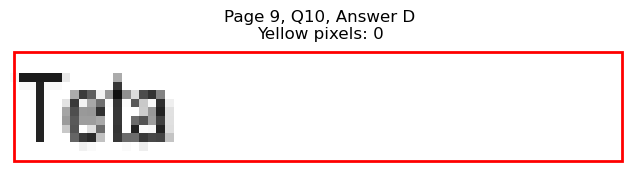

Page 9, Q10 - E: Detected box: x0=322.5, y0=716.3, x1=331.0, y1=728.9
Page 9, Q10, E: Yellow pixels: 0
Page 9, Q10, E: Total non-white pixels: 58
Page 9, Q10, E: Yellow percentage: 0.0%


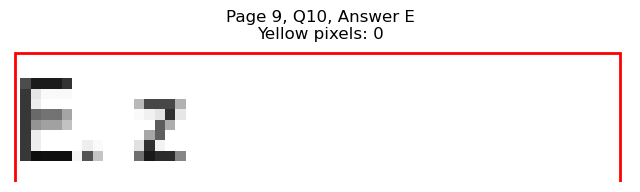


Page 9, Q10 - Selected Answer: A (based on yellow pixel count)





Page 10: Found 10 questions
Page 10, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=126.1, y1=110.4
Page 10, Q1, A: Yellow pixels: 963
Page 10, Q1, A: Total non-white pixels: 1330
Page 10, Q1, A: Yellow percentage: 72.4%


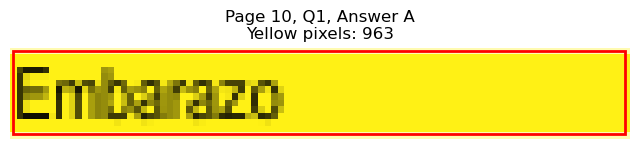

Page 10, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=106.6, y1=123.0
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 195
Page 10, Q1, B: Yellow percentage: 0.0%


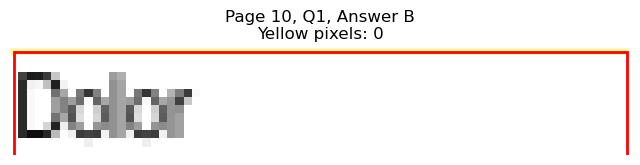

Page 10, Q1 - C: Detected box: x0=82.9, y0=122.9, x1=110.5, y1=135.6
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 134
Page 10, Q1, C: Yellow percentage: 0.0%


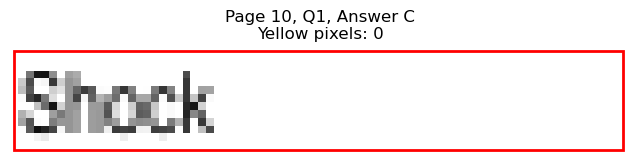

Page 10, Q1 - D: Detected box: x0=334.6, y0=97.7, x1=410.3, y1=110.4
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 402
Page 10, Q1, D: Yellow percentage: 0.0%


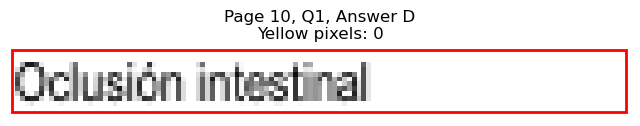

Page 10, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=393.8, y1=123.0
Page 10, Q1, E: Yellow pixels: 0
Page 10, Q1, E: Total non-white pixels: 327
Page 10, Q1, E: Yellow percentage: 0.0%


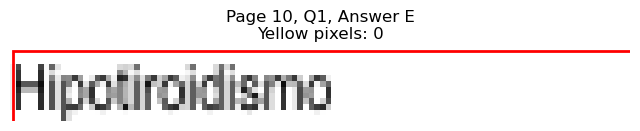


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=82.5, y0=160.8, x1=159.3, y1=173.5
Page 10, Q2, A: Yellow pixels: 128
Page 10, Q2, A: Total non-white pixels: 551
Page 10, Q2, A: Yellow percentage: 23.2%


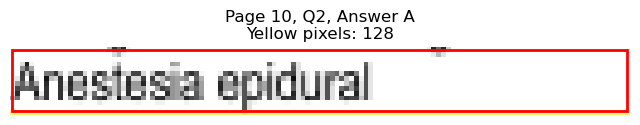

Page 10, Q2 - B: Detected box: x0=82.5, y0=173.4, x1=201.4, y1=186.1
Page 10, Q2, B: Yellow pixels: 1739
Page 10, Q2, B: Total non-white pixels: 2380
Page 10, Q2, B: Yellow percentage: 73.1%


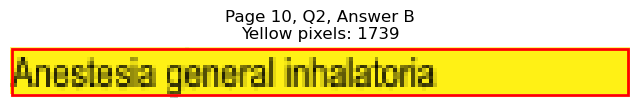

Page 10, Q2 - C: Detected box: x0=82.9, y0=186.0, x1=163.3, y1=198.7
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 539
Page 10, Q2, C: Yellow percentage: 0.0%


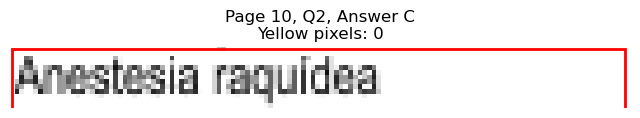

Page 10, Q2 - D: Detected box: x0=334.6, y0=160.8, x1=413.8, y1=173.5
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 384
Page 10, Q2, D: Yellow percentage: 0.0%


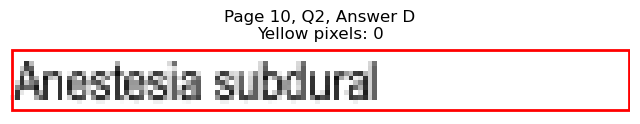

Page 10, Q2 - E: Detected box: x0=334.1, y0=173.4, x1=422.9, y1=186.1
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 452
Page 10, Q2, E: Yellow percentage: 0.0%


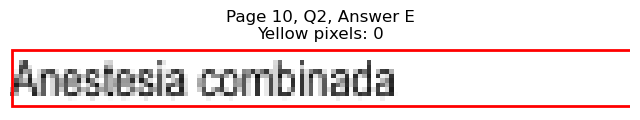


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=82.5, y0=236.5, x1=125.5, y1=249.2
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 218
Page 10, Q3, A: Yellow percentage: 0.0%


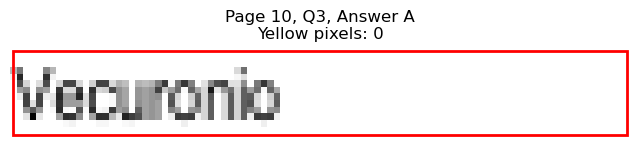

Page 10, Q3 - B: Detected box: x0=82.5, y0=249.1, x1=139.6, y1=261.8
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 380
Page 10, Q3, B: Yellow percentage: 0.0%


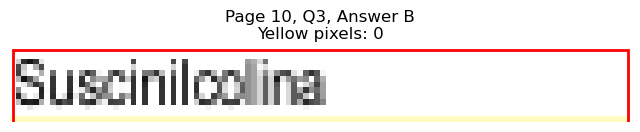

Page 10, Q3 - C: Detected box: x0=82.9, y0=261.7, x1=121.6, y1=274.4
Page 10, Q3, C: Yellow pixels: 1013
Page 10, Q3, C: Total non-white pixels: 1260
Page 10, Q3, C: Yellow percentage: 80.4%


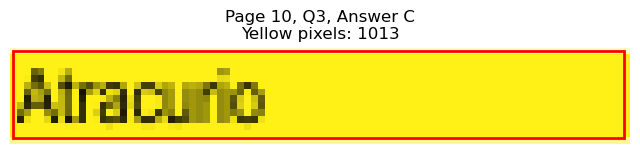

Page 10, Q3 - D: Detected box: x0=334.6, y0=236.5, x1=380.7, y1=249.2
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 239
Page 10, Q3, D: Yellow percentage: 0.0%


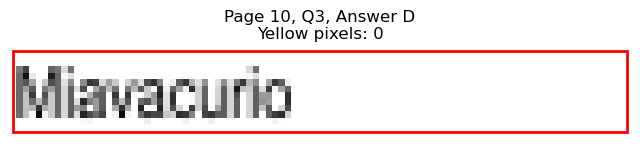

Page 10, Q3 - E: Detected box: x0=334.1, y0=249.1, x1=382.3, y1=261.8
Page 10, Q3, E: Yellow pixels: 0
Page 10, Q3, E: Total non-white pixels: 239
Page 10, Q3, E: Yellow percentage: 0.0%


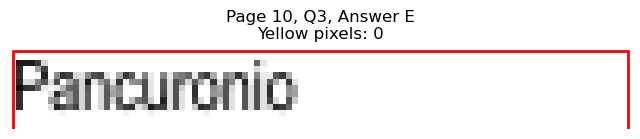


Page 10, Q3 - Selected Answer: C (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=70.8, y0=299.7, x1=79.3, y1=312.3
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 70
Page 10, Q4, A: Yellow percentage: 0.0%


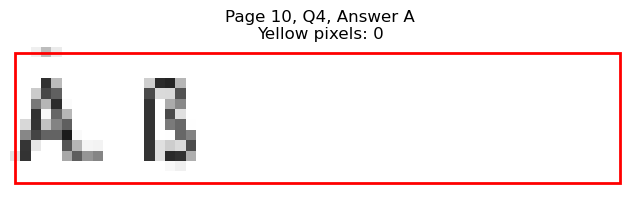

Page 10, Q4 - B: Detected box: x0=70.8, y0=312.3, x1=79.3, y1=324.9
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 127
Page 10, Q4, B: Yellow percentage: 0.0%


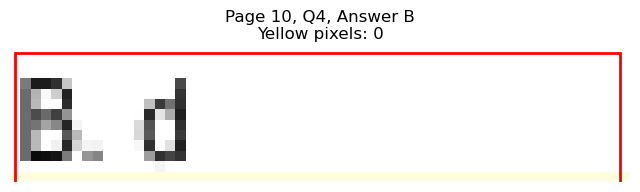

Page 10, Q4 - C: Detected box: x0=70.8, y0=324.9, x1=79.8, y1=337.5
Page 10, Q4, C: Yellow pixels: 731
Page 10, Q4, C: Total non-white pixels: 840
Page 10, Q4, C: Yellow percentage: 87.0%


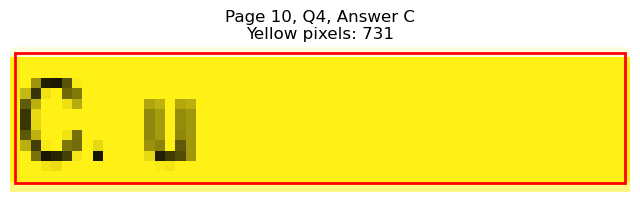

Page 10, Q4 - D: Detected box: x0=322.5, y0=299.7, x1=331.5, y1=312.3
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 67
Page 10, Q4, D: Yellow percentage: 0.0%


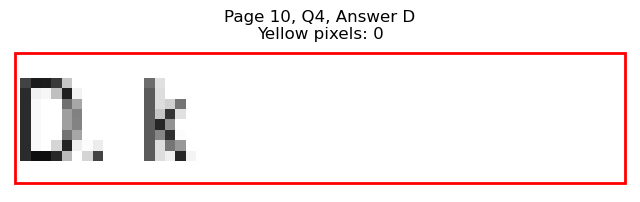

Page 10, Q4 - E: Detected box: x0=334.1, y0=312.3, x1=342.7, y1=324.9
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 39
Page 10, Q4, E: Yellow percentage: 0.0%


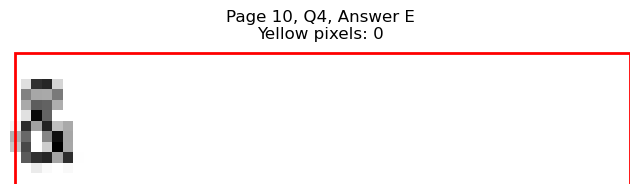


Page 10, Q4 - Selected Answer: C (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=82.5, y0=362.8, x1=95.1, y1=375.5
Page 10, Q5, A: Yellow pixels: 799
Page 10, Q5, A: Total non-white pixels: 896
Page 10, Q5, A: Yellow percentage: 89.2%


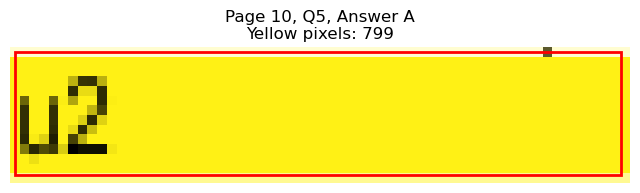

Page 10, Q5 - B: Detected box: x0=70.8, y0=375.4, x1=79.3, y1=388.1
Page 10, Q5, B: Yellow pixels: 60
Page 10, Q5, B: Total non-white pixels: 128
Page 10, Q5, B: Yellow percentage: 46.9%


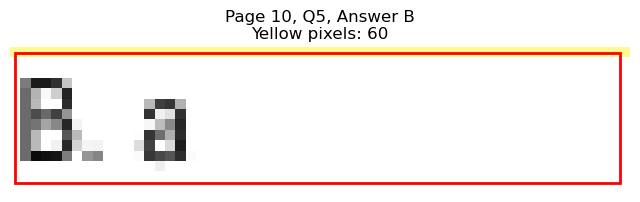

Page 10, Q5 - C: Detected box: x0=70.8, y0=388.0, x1=79.8, y1=400.7
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 67
Page 10, Q5, C: Yellow percentage: 0.0%


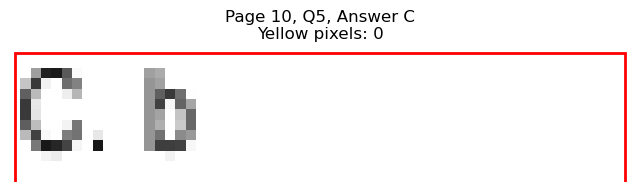

Page 10, Q5 - D: Detected box: x0=322.5, y0=299.7, x1=331.5, y1=312.3
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 67
Page 10, Q5, D: Yellow percentage: 0.0%


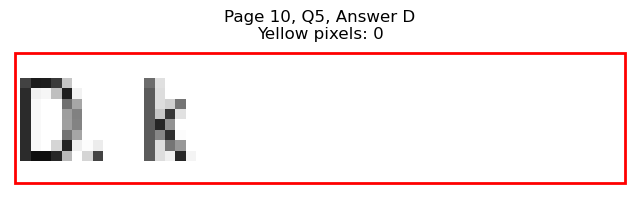

Page 10, Q5 - E: Detected box: x0=322.5, y0=375.4, x1=331.0, y1=388.1
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 66
Page 10, Q5, E: Yellow percentage: 0.0%


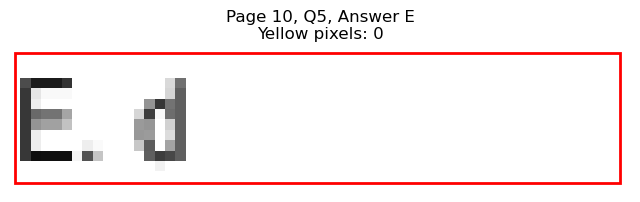


Page 10, Q5 - Selected Answer: A (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=82.5, y0=425.9, x1=128.5, y1=438.6
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 247
Page 10, Q6, A: Yellow percentage: 0.0%


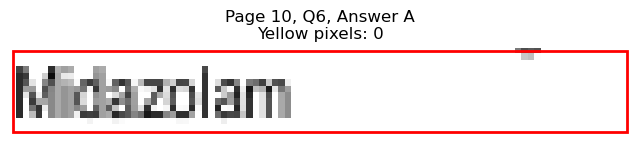

Page 10, Q6 - B: Detected box: x0=82.5, y0=438.5, x1=123.1, y1=451.2
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 209
Page 10, Q6, B: Yellow percentage: 0.0%


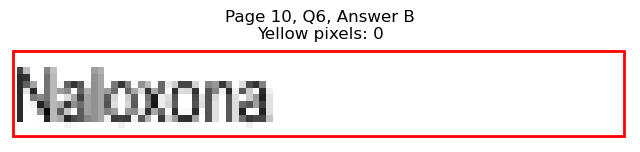

Page 10, Q6 - C: Detected box: x0=82.9, y0=451.1, x1=135.6, y1=463.8
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 283
Page 10, Q6, C: Yellow percentage: 0.0%


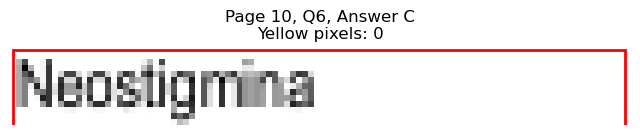

Page 10, Q6 - D: Detected box: x0=334.6, y0=425.9, x1=378.3, y1=438.6
Page 10, Q6, D: Yellow pixels: 95
Page 10, Q6, D: Total non-white pixels: 309
Page 10, Q6, D: Yellow percentage: 30.7%


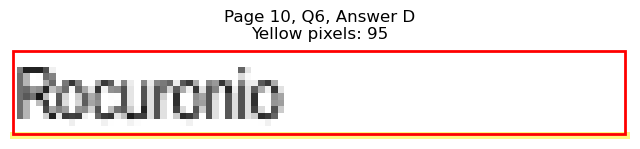

Page 10, Q6 - E: Detected box: x0=334.1, y0=438.5, x1=385.3, y1=451.2
Page 10, Q6, E: Yellow pixels: 1149
Page 10, Q6, E: Total non-white pixels: 1428
Page 10, Q6, E: Yellow percentage: 80.5%


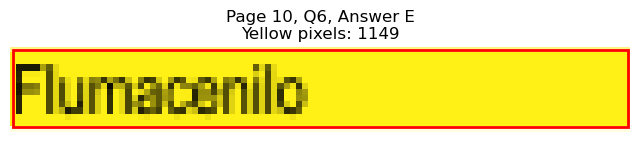


Page 10, Q6 - Selected Answer: E (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=82.5, y0=489.1, x1=135.1, y1=501.7
Page 10, Q7, A: Yellow pixels: 1174
Page 10, Q7, A: Total non-white pixels: 1352
Page 10, Q7, A: Yellow percentage: 86.8%


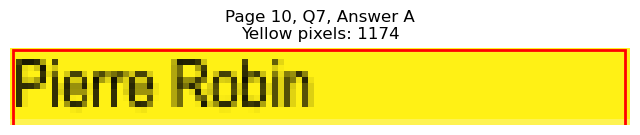

Page 10, Q7 - B: Detected box: x0=82.5, y0=501.7, x1=150.7, y1=514.3
Page 10, Q7, B: Yellow pixels: 119
Page 10, Q7, B: Total non-white pixels: 448
Page 10, Q7, B: Yellow percentage: 26.6%


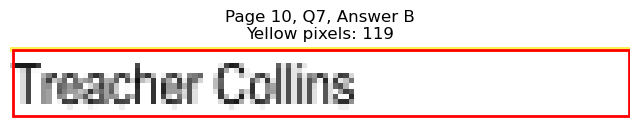

Page 10, Q7 - C: Detected box: x0=82.9, y0=514.3, x1=162.6, y1=526.9
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 413
Page 10, Q7, C: Yellow percentage: 0.0%


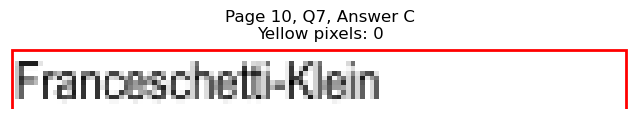

Page 10, Q7 - D: Detected box: x0=334.6, y0=489.1, x1=358.7, y1=501.7
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 119
Page 10, Q7, D: Yellow percentage: 0.0%


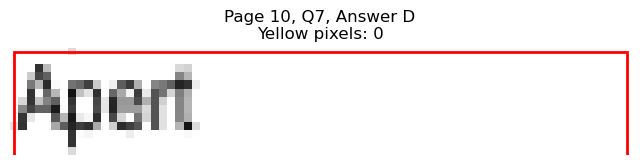

Page 10, Q7 - E: Detected box: x0=334.1, y0=501.7, x1=381.4, y1=514.3
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 272
Page 10, Q7, E: Yellow percentage: 0.0%


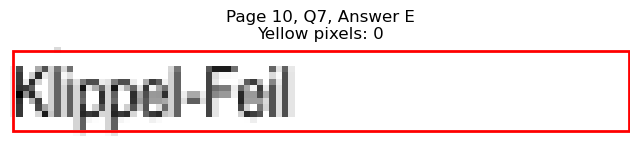


Page 10, Q7 - Selected Answer: A (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=82.5, y0=552.2, x1=187.3, y1=564.8
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 533
Page 10, Q8, A: Yellow percentage: 0.0%


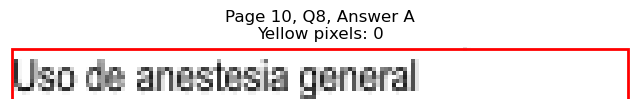

Page 10, Q8 - B: Detected box: x0=82.5, y0=564.8, x1=191.8, y1=577.4
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 543
Page 10, Q8, B: Yellow percentage: 0.0%


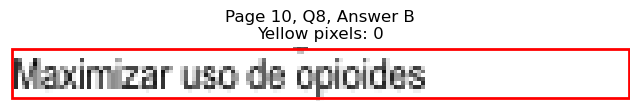

Page 10, Q8 - C: Detected box: x0=82.9, y0=577.4, x1=207.3, y1=590.0
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 623
Page 10, Q8, C: Yellow percentage: 0.0%


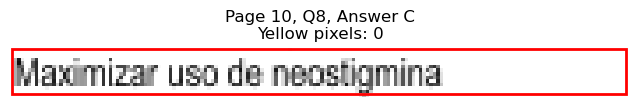

Page 10, Q8 - D: Detected box: x0=334.6, y0=552.2, x1=441.4, y1=564.8
Page 10, Q8, D: Yellow pixels: 1616
Page 10, Q8, D: Total non-white pixels: 2054
Page 10, Q8, D: Yellow percentage: 78.7%


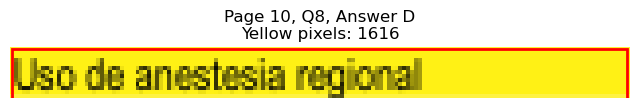

Page 10, Q8 - E: Detected box: x0=334.1, y0=564.8, x1=414.4, y1=577.4
Page 10, Q8, E: Yellow pixels: 127
Page 10, Q8, E: Total non-white pixels: 561
Page 10, Q8, E: Yellow percentage: 22.6%


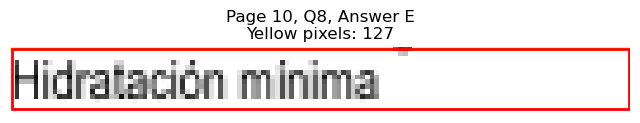


Page 10, Q8 - Selected Answer: D (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=82.5, y0=615.2, x1=132.6, y1=627.8
Page 10, Q9, A: Yellow pixels: 0
Page 10, Q9, A: Total non-white pixels: 260
Page 10, Q9, A: Yellow percentage: 0.0%


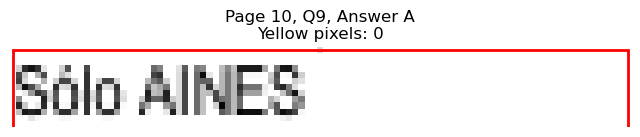

Page 10, Q9 - B: Detected box: x0=82.5, y0=627.9, x1=172.9, y1=640.6
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 440
Page 10, Q9, B: Yellow percentage: 0.0%


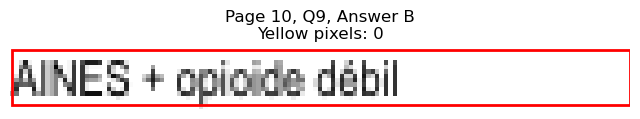

Page 10, Q9 - C: Detected box: x0=82.9, y0=640.5, x1=138.1, y1=653.2
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 294
Page 10, Q9, C: Yellow percentage: 0.0%


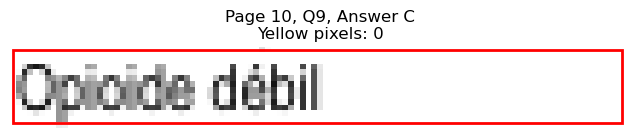

Page 10, Q9 - D: Detected box: x0=334.6, y0=615.2, x1=415.1, y1=627.8
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 390
Page 10, Q9, D: Yellow percentage: 0.0%


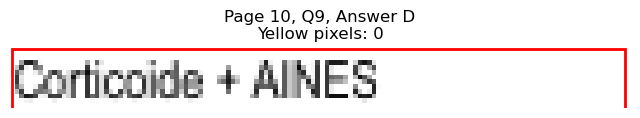

Page 10, Q9 - E: Detected box: x0=334.1, y0=627.9, x1=486.8, y1=640.6
Page 10, Q9, E: Yellow pixels: 1926
Page 10, Q9, E: Total non-white pixels: 2688
Page 10, Q9, E: Yellow percentage: 71.7%


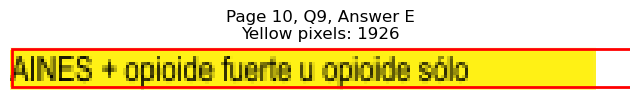


Page 10, Q9 - Selected Answer: E (based on yellow pixel count)




Page 10, Q10 - A: Detected box: x0=82.5, y0=691.1, x1=183.3, y1=703.7
Page 10, Q10, A: Yellow pixels: 0
Page 10, Q10, A: Total non-white pixels: 503
Page 10, Q10, A: Yellow percentage: 0.0%


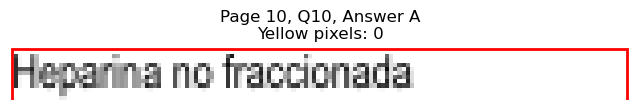

Page 10, Q10 - B: Detected box: x0=82.5, y0=703.7, x1=124.1, y1=716.3
Page 10, Q10, B: Yellow pixels: 0
Page 10, Q10, B: Total non-white pixels: 198
Page 10, Q10, B: Yellow percentage: 0.0%


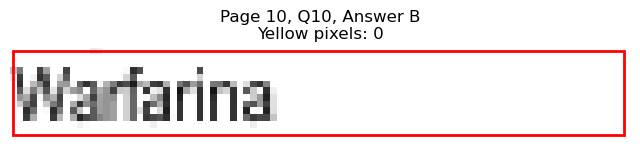

Page 10, Q10 - C: Detected box: x0=82.9, y0=716.3, x1=136.6, y1=728.9
Page 10, Q10, C: Yellow pixels: 0
Page 10, Q10, C: Total non-white pixels: 272
Page 10, Q10, C: Yellow percentage: 0.0%


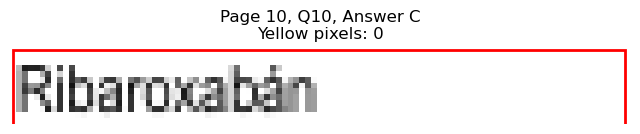

Page 10, Q10 - D: Detected box: x0=334.6, y0=691.1, x1=381.3, y1=703.7
Page 10, Q10, D: Yellow pixels: 3
Page 10, Q10, D: Total non-white pixels: 354
Page 10, Q10, D: Yellow percentage: 0.8%


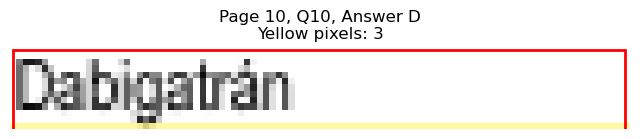

Page 10, Q10 - E: Detected box: x0=334.1, y0=703.7, x1=469.2, y1=716.3
Page 10, Q10, E: Yellow pixels: 1739
Page 10, Q10, E: Total non-white pixels: 2604
Page 10, Q10, E: Yellow percentage: 66.8%


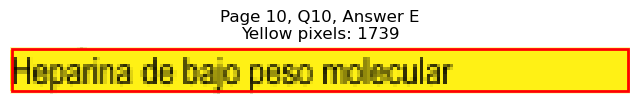


Page 10, Q10 - Selected Answer: E (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Cuál es un efecto adverso relacionado al empl...
1   ¿Por qué se caracteriza el efecto de los halog...
2   ¿Cuál es el agente anestésico que disminuye el...
3   Gestante 38 semanas considerada como categoría...
4   Hombre 40 años que sufre accidente de tránsito...
..                                                ...
95  ¿Qué fármaco es antagonista para sobredosis de...
96  En la intubación difícil, el hallazgo de glopt...
97  ¿Qué se debe tener en cuenta para la reducción...
98  ¿Cuál es el esquema de tratamiento EV para dol...
99  ¿Cuál es el anticoagulante que en el caso de u...

[100 rows x 1 columns]

In [8]:
answers_df

option_A                                    option_B  \
0         Anestesia prolongada                                   Lumbalgia   
1   Aumentan la contractilidad  Tiene escasos efectos sobre la resistencia   
2                     Propofol                               Óxido nitroso   
3         Epidural con catéter                        Epidural sin catéter   
4                           II                                         III   
..                         ...                                         ...   
95                   Midazolam                                    Naloxona   
96                Pierre Robin                            Treacher Collins   
97    Uso de anestesia general                   Maximizar uso de opioides   
98                  Sólo AINES                       AINES + opioide débil   
99     Heparina no fraccionada                                   Warfarina   

                        option_C  \
0       Trastornos de la micción   
1                             No   
2                       Halotano   
3                        Espinal   
4                             IV   
..                           ...   
95                   Neostigmina   
96           Franceschetti-Klein   
97  Maximizar uso de neostigmina   
98                 Opioide débil   
99                   Ribaroxabán   

                                         option_D  \
0                     Perforación de la duramadre   
1           No modifican la circulación coronaria   
2                                       Enflurano   
3   Epidural con catéter previo y luego retirarlo   
4                                               I   
..                                            ...   
95                                      Rocuronio   
96                                          Apert   
97                      Uso de anestesia regional   
98                             Corticoide + AINES   
99                                     Dabigatrán   

                                   option_E  
0                               Mayor dolor  
1   El isoflurano es el menos vasodilatador  
2                                  Ketamina  
3                                   General  
4                                         O  
..                                      ...  
95                              Flumacenilo  
96                             Klippel-Feil  
97                       Hidratación mínima  
98    AINES + opioide fuerte u opioide sólo  
99          Heparina de bajo peso molecular  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               D
1               B
2               A
3               E
4               C
..            ...
95              E
96              A
97              D
98              E
99              E

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   ¿Cuál es un efecto adverso relacionado al empl...   
1   ¿Por qué se caracteriza el efecto de los halog...   
2   ¿Cuál es el agente anestésico que disminuye el...   
3   Gestante 38 semanas considerada como categoría...   
4   Hombre 40 años que sufre accidente de tránsito...   
..                                                ...   
95  ¿Qué fármaco es antagonista para sobredosis de...   
96  En la intubación difícil, el hallazgo de glopt...   
97  ¿Qué se debe tener en cuenta para la reducción...   
98  ¿Cuál es el esquema de tratamiento EV para dol...   
99  ¿Cuál es el anticoagulante que en el caso de u...   

                      option_A                                    option_B  \
0         Anestesia prolongada                                   Lumbalgia   
1   Aumentan la contractilidad  Tiene escasos efectos sobre la resistencia   
2                     Propofol                               Óxido nitroso   
3         Epidural con catéter                        Epidural sin catéter   
4                           II                                         III   
..                         ...                                         ...   
95                   Midazolam                                    Naloxona   
96                Pierre Robin                            Treacher Collins   
97    Uso de anestesia general                   Maximizar uso de opioides   
98                  Sólo AINES                       AINES + opioide débil   
99     Heparina no fraccionada                                   Warfarina   

                        option_C  \
0       Trastornos de la micción   
1                             No   
2                       Halotano   
3                        Espinal   
4                             IV   
..                           ...   
95                   Neostigmina   
96           Franceschetti-Klein   
97  Maximizar uso de neostigmina   
98                 Opioide débil   
99                   Ribaroxabán   

                                         option_D  \
0                     Perforación de la duramadre   
1           No modifican la circulación coronaria   
2                                       Enflurano   
3   Epidural con catéter previo y luego retirarlo   
4                                               I   
..                                            ...   
95                                      Rocuronio   
96                                          Apert   
97                      Uso de anestesia regional   
98                             Corticoide + AINES   
99                                     Dabigatrán   

                                   option_E correct_answer  
0                               Mayor dolor              D  
1   El isoflurano es el menos vasodilatador              B  
2                                  Ketamina              A  
3                                   General              E  
4                                         O              C  
..                                      ...            ...  
95                              Flumacenilo              E  
96                             Klippel-Feil              A  
97                       Hidratación mínima              D  
98    AINES + opioide fuerte u opioide sólo              E  
99          Heparina de bajo peso molecular              E  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2020/ANESTESIOLOGIA.csv
